# From Wright's Generalized Bessel Function to Tweedie's Compound Poisson Distribution

**Table of Contents<a id="toc"></a>:**
- [1 Tweedie Distribution](#tweedie)
- [2 Wright's Generalized Bessel Function](#wright)
  - [2.1 Series Definition with Arbitrary Precision via MPMATH](#series_mpmath)
  - [2.2 Series Expansion with Finite Precision](#series)
  - [2.3 Taylor Series in rho - For small rho](#series_rho_small)
  - [2.4 Asymptotic Expansion](#asymptotic)
  - [2.4 Integral Representation](#integral)
  - [2.6 Taylor Series for large rho and large z](#series_rho_large)
  - [2.7 Check Precision on Data Grid](#grid)
- [3 Asymptotic Expansion](#asymptotic)

## 1 Tweedie Distribution <a id="tweedie"></a>
[back to TOC](#toc)

We start by plotting a few of the most commonly used Tweedie distributions.

In [1]:
import itertools

import numpy as np
import pandas as pd
import scipy.optimize as optimize
import scipy.special as ss
import scipy.stats as stats
import scipy.integrate as integrate

#plotting
import matplotlib.pyplot as plt
import seaborn as sns


plt.ion()
sns.set(style="whitegrid")

Calculate mean and variance of some distributions.

In [2]:
[
    stats.norm(loc=2, scale=1).stats("mv"),
    stats.gamma(a=4, scale=1/2).stats("mv"),
    stats.invgauss(mu=1/4, scale=8).stats("mv"),
]

[(2.0, 1.0), (2.0, 1.0), (2.0, 1.0)]

Text(0.5, 0.98, 'Common Tweedie Distributions: p=0, 1, 2, 3')

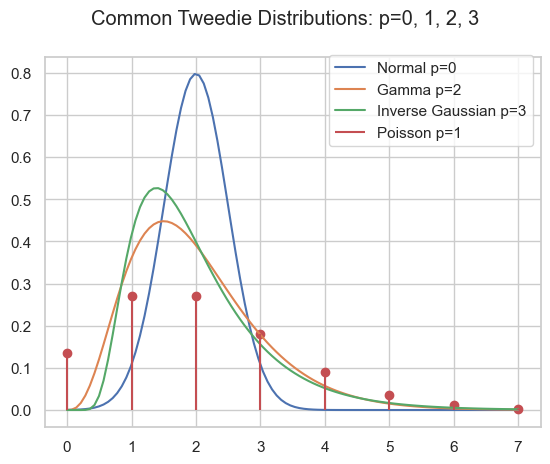

In [3]:
x = np.linspace(1e-10, 7, 100)
fig, ax = plt.subplots()
ax.plot(x, stats.norm(loc=2, scale=1/2).pdf(x), label="Normal p=0")
ax.plot(x, stats.gamma(a=4, scale=1/2).pdf(x), label="Gamma p=2")
ax.plot(x, stats.invgauss(mu=1/4, scale=8).pdf(x), label="Inverse Gaussian p=3")
x = np.arange(8)
ax.scatter(x, stats.poisson(mu=2).pmf(x), color="C3")
ax.vlines(x, 0, stats.poisson(mu=2).pmf(x), color="C3", label="Poisson p=1")
fig.legend(loc="upper right", bbox_to_anchor=(0.9, 0.9))
fig.suptitle("Common Tweedie Distributions: p=0, 1, 2, 3")
# fig.savefig("tweedie.png")

Some special Tweedie distributions are the ones *between* Poisson and Gamma, i.e. $1<p<2$.
This gives a distribution with point mass at zero and otherwise a continuous density on the positive axis.
The PDF is given by:
$$f(y; \mu, \phi, p) = a(y, \phi, p) e^{\frac{y\theta - \kappa}{\phi}}$$
$$\theta = \frac{\mu^{1-p}}{1-p}$$
$$\kappa = \frac{\mu^{2-p}}{2-p}$$
$$a(y, \phi, p) = \frac{\Phi(-\alpha, 0, t)}{y}$$
$$\alpha = \frac{2 - p}{1 - p}$$
$$t = \frac{\left(\frac{(p - 1)\phi}{x}\right)^{\alpha}}{(2-p)\phi}$$
This depends on **Wright's (generalized Bessel) function** $\Phi(\rho, \beta, z)$.

**References:**
- Dunn, P.K., Smyth, G.K. "Series evaluation of Tweedie exponential dispersion model densities". Stat Comput 15, 267–280 (2005). https://doi.org/10.1007/s11222-005-4070-y
- Delong, Ł., Lindholm, M. & Wüthrich, M.V. "Making Tweedie’s compound Poisson model more accessible". Eur. Actuar. J. 11, 185–226 (2021). https://doi.org/10.1007/s13385-021-00264-3

In [4]:
def cpg_pmf(mu, phi, p):
    """Compound Poisson Gamma point mass at zero."""
    return np.exp(-np.power(mu, 2 - p) / (phi * (2 - p)))

def cpg_pdf(x, mu, phi, p):
    """Compound Poisson Gamma pdf."""
    if p == 1:
        theta = np.log(mu)
    else:
        theta = np.power(mu, 1 - p) / (1 - p)

    if p == 2:
        kappa = np.log(mu)
    else:
        kappa = np.power(mu, 2 - p) / (2 - p)

    alpha = (2 - p) / (1 - p)
    t = ((p - 1) * phi / x)**alpha
    t /= (2 - p) * phi
    a = 1 / x * ss.wright_bessel(-alpha, 0, t)
    return a * np.exp((x * theta - kappa) / phi)

To make sure that we got the formulas right by checking that the integral over the pdf plus point mass at zero gives one.

In [5]:
mu, phi, p = 2, 0.3, 1.5
integrate.quad(cpg_pdf, 1e-9, 30, args=(mu, phi, p))[0] + cpg_pmf(mu, phi, p)

0.9999999999964442

Text(0.5, 0.98, 'Tweedie Distributions mu=2')

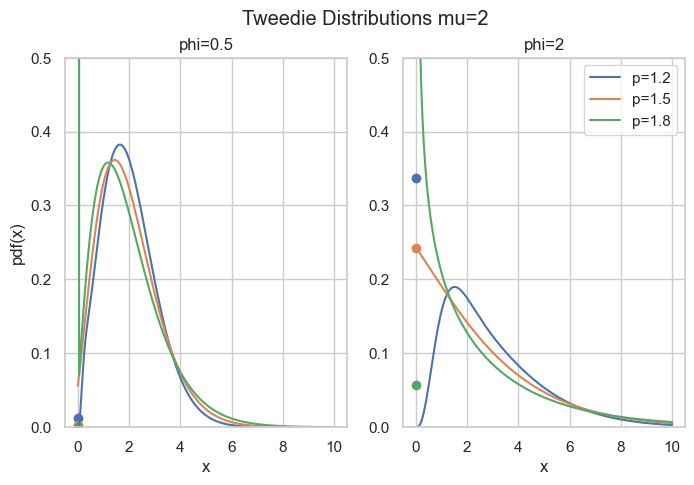

In [6]:
fig, axes = plt.subplots(ncols=2, figsize=[6.4 * 1.25, 4.8])
x = np.linspace(1e-9, 10, 200)
mu = 2
for p in [1.2, 1.5, 1.8]:
    for i, phi in enumerate([0.5, 2]):
        axes[i].plot(x, cpg_pdf(x=x, mu=mu, phi=phi, p=p), label=f"{p=}")
        axes[i].scatter(0, cpg_pmf(mu=mu, phi=phi, p=p))
        axes[i].set_ylim(0, 0.5)
        axes[i].set_title(f"{phi=}")
        if i > 0:
            axes[i].legend()
        else:
            axes[i].set_ylabel("pdf(x)")
        axes[i].set_xlabel("x")
fig.suptitle("Tweedie Distributions mu=2")

## 2 Wright's Function <a id="wright"></a>
[back to TOC](#toc)

Wright's (generalized Bessel) function was introduced in a 1933 paper by E. Wright and is define, see also [DLMF 10.46](https://dlmf.nist.gov/10.46), as
$$\Phi(\rho, \beta, z) = \sum_{k=0}^{\infty} \frac{z^k}{k!\Gamma(\beta+\rho k)}, \quad \rho > -1, \beta \in R, z \in C$$

with [Gamma function](https://en.wikipedia.org/wiki/Gamma_function) $\Gamma(z)$.

**Properties**

$\Phi(\rho, \beta, z)$ is an [entire function](https://en.wikipedia.org/wiki/Entire_function).
For positive, real arguments, it is monotonically increasing with increasing $z$ and with decreasing $\rho$ and $\beta$.

It has the following derivatives
$$\frac{\partial^n}{\partial z^n} \Phi(\rho, \beta, z) = \Phi(\rho, \beta + n \rho, z)$$
and the following recurrence relation
$$\Phi(\rho, \beta-1, z) = \rho z \Phi(\rho, \beta + \rho, z) + (\beta-1) \Phi(\rho, \beta, z)$$

**Numeric Evaluation**
This function is very difficult to evaluate numerically.
We mostly restrict our analysis to non-negative real numbers.
For specific regions of the parameter space, difference evaluation strategies are more appropriate:
- Small $|z|$: Taylor series expansion as given by the definition.
- Small $|\rho|$: Taylor series in $\rho$ (Dunn & Smyth (2005)
- Large $\rho$: Taylor series expansion around the maximum term
- Large $Z = (\rho x)^{\frac{1}{1+\rho}}$: asymptotic expantion in $Z$
- General: integral representation

**References:**
- E. Maitland Wright (1933), "On the Coefficients of Power Series Having Exponential Singularities", J. Lond. Math. Soc. 8 (1933), 71-79, https://doi.org/10.1112/jlms/s1-8.1.71
- Rudolf GORENFLO, Yuri LUCHKO, Francesco MAINARDI (2997), "Analytical properties and applicationsof the Wright function", https://arxiv.org/pdf/math-ph/0701069.pdf
- R. Stankovic (1970) "On the function of E. M. Wright", Pub. L’Institut Mathématique 18(1970) 113–124. http://elib.mi.sanu.ac.rs/files/journals/publ/30/13.pdf

Numerical Evaluation:
- Y. F. Luchko (2008), "Algorithms for Evaluation of the Wright Function for the Real Arguments’ Values",<br>
  Fractional Calculus and Applied Analysis 11(1), https://eudml.org/doc/11309 or [direct link](http://sci-gems.math.bas.bg/jspui/bitstream/10525/1298/1/fcaa-vol11-num1-2008-57p-75p.pdf)

Asymptotic Expansion:
- E. M. Wright (1935), "The asymptotic expansion of the generalized Bessel",<br>
  function. Proc. London Math. Soc. (2) 38, pp. 257–270. https://doi.org/10.1112/plms/s2-38.1.257
- R. B. Paris (2017), The asymptotics of the generalised Bessel function,<br>
  Mathematica Aeterna, Vol. 7, 2017, no. 4, 381 - 406, https://arxiv.org/abs/1711.03006
- Smoothing of Stokes' discontinuity for the generalized Bessel function I, R. Wong and Y.-Q. Zhao, https://doi.org/10.1098/rspa.1999.0365
- Smoothing of Stokes's discontinuity for the generalized Bessel function. II, R. Wong and Y.-Q. Zhao, https://doi.org/10.1098/rspa.1999.0440
- Exponentially small expansions of the Wright function on the Stokes lines, R. B. Paris, [direct link](https://rke.abertay.ac.uk/ws/portalfiles/portal/8558833/Paris_ExponentiallySmallExpansionsOfTheWrightFunction_Author_2014.pdf)
- Asymptotic and structural properties of special cases of the Wright function arising in probability theory, Richard B. Paris, https://arxiv.org/pdf/1508.00863.pdf

For Tweedie:
- Dunn, P.K., Smyth, G.K. Series evaluation of Tweedie exponential dispersion model densities. Stat Comput 15, 267–280 (2005). https://doi.org/10.1007/s11222-005-4070-y
- Vinogradov, V., Paris, R.B. & Yanushkevichiene, O. New properties and representations for members of the power-variance family. I. Lith Math J 52, 444–461 (2012) doi:10.1007/s10986-012-9186-0, https://rke.abertay.ac.uk/files/8536176/Paris_NewPropertiesAndRepresentations_I_Author_2012.pdf
- Vinogradov, V., Paris, R.B. & Yanushkevichiene, O. New properties and representations for members of the power-variance family. II https://rke.abertay.ac.uk/ws/portalfiles/portal/8536555/Paris_NewPropertiesAndRepresentations_Author_2013.pdf


### 2.1 Taylor Series with Arbitrary Precision via mpmath <a id="series_mpmath"></a>
[back to TOC](#toc)
First of all, it is good to have some way to compute high precision results.
We accomplish this with the arbitrary floating point precition library mpmath and the Taylor series by computing enough terms.
This will be our reference to evaluate much faster methods.

In [7]:
from functools import lru_cache
import mpmath
import sympy
from sympy import Rational, S, symbols, gamma, digamma, polygamma, zeta, EulerGamma, pi, series
from sympy.printing.pycode import pycode


def rel_err(x1, x2):
    return float((x1 - x2)/x2)  # x1/x2 - 1

In [8]:
@lru_cache(maxsize=10_000)
def rgamma_cached(x, dps):
    with mpmath.workdps(dps):
        return mpmath.rgamma(x)

def Wright_Series_MPMATH(rho, beta, z, dps=20, method="r+s+e", **kwargs):
    """Compute Wright's generalized Bessel function as Series.
    
    This uses mpmath for arbitrary precision.
    """
    with mpmath.workdps(dps):
        res = mpmath.nsum(lambda k: z**k/mpmath.fac(k) * rgamma_cached(rho*k+beta, dps),
                          [0, mpmath.inf],
                          tol=dps, method=method, **kwargs
                          )
        res = sympy.Float(res)

    return res

In [9]:
Wright_Series_MPMATH(1, Rational(1, 2), 1, dps=20)

2.1225916201773919085

The larger $\rho$ or $\beta$ the smaller $\Phi$.
For $\rho, \beta, x \geq 0$:
$$\Phi(\rho,\beta, x) \leq \Phi(0, \beta, x) = \frac{\exp(x)}{\Gamma(\beta)}$$

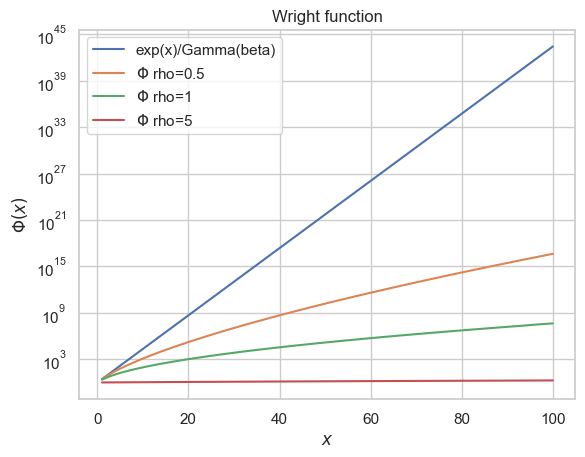

In [10]:
beta = 1
x = np.linspace(1, 100, num=100)
y = np.exp(x) * ss.rgamma(beta)
plt.plot(x, y, label="exp(x)/Gamma(beta)")

for rho in [0.5, 1, 5]:
    y = np.asarray([Wright_Series_MPMATH(rho, beta, z) for z in x])
    plt.plot(x, y, label=f"$\Phi$ rho={rho}")

plt.legend()
plt.xlabel("$x$")
plt.ylabel("$\Phi(x)$")
plt.yscale("log")
plt.title("Wright function")
plt.show()

### 2.2 Tylor Series Expansion with Finite Precision <a id="series"></a>
[back to TOC](#toc)

In [11]:
def Wright_Series(rho, beta, z, nstart=0, nstop=100, tol=1e-20):
    # term k=nstart
    k = nstart
    zk_kk = np.power(z, k) * ss.rgamma(k+1)  # z^k/k!
    res = zk_kk * ss.rgamma(beta + rho*k)
    # term k=1,2,...
    for k in range(1, nstop):
        zk_kk *= z/float(k)
        rg = ss.rgamma(beta + rho*k)
        term = zk_kk * rg
        res += term
        # stop early
        if rg != 0 and term/res < tol:
            return res
        
    return res

In [12]:
# Compare simple examples
for rho, beta, z in [
    [Rational(1, 100), Rational(1, 10), 0.5],
    [Rational(1, 1000), Rational(1, 100), 1 - 1e-10],
    [Rational(1, 1000_000), Rational(1, 2), 1],
]:
    print()  # empty line
    x1 = Wright_Series_MPMATH(rho, beta, z, dps=50, verbose=True, steps=[100])
    x2 = Wright_Series(float(rho), float(beta), float(z), nstop=18, tol=0)
    print(f"{rho=}, {beta=}, {z=} Wright_Series_MPMATH={x1}")
    print(f"Relative error Wright_Series vs Wright_Series_MPMATH = {rel_err(x2, x1):.4e}")


----------------------------------------------------------------------
Adding terms #0-#100
Direct error: 1.76935e-186
rho=1/100, beta=1/10, z=0.5 Wright_Series_MPMATH=0.18238098764255952025993540799874756770882542146653
Relative error Wright_Series vs Wright_Series_MPMATH = -4.1536e-16

----------------------------------------------------------------------
Adding terms #0-#100
Direct error: 1.23229e-157
rho=1/1000, beta=1/100, z=0.9999999999 Wright_Series_MPMATH=0.030090087075305970407133141526014288648667841721763
Relative error Wright_Series vs Wright_Series_MPMATH = -8.6799e-17

----------------------------------------------------------------------
Adding terms #0-#100
Direct error: 6.04652e-157
rho=1/1000000, beta=1/2, z=1 Wright_Series_MPMATH=1.5336293040526887877418842520713751912516629005132
Relative error Wright_Series vs Wright_Series_MPMATH = -1.9335e-16


**MPMATH without steps argument** (`method="s"`) **would terminate early, after 10 summands.**
<br>
For $\rho,\beta \geq 0$ and $0\leq z \leq 1$, 20 terms seem to be sufficient. 

In [13]:
# Compare simple examples
for rho, beta, z in [
    [Rational(1, 100), 100, 1],
    [Rational(1, 1000), 100, 2],
]:
    print()  # empty line
    x1 = Wright_Series_MPMATH(rho, beta, z, dps=50, verbose=True, steps=[1000], method="s")
    x2 = Wright_Series(float(rho), float(beta), float(z), nstop=20, tol=0)
    print(f"{rho=}, {beta=}, {z=} Wright_Series_MPMATH={x1}")
    print(f"Relative error Wright_Series vs Wright_Series_MPMATH = {rel_err(x2, x1):.4e}")

rel_err(x2, x1)


----------------------------------------------------------------------
Adding terms #0-#1000
Direct error: 0.0
rho=1/100, beta=100, z=1 Wright_Series_MPMATH=2.7846121945040783629697798821081706253067994994632E-156
Relative error Wright_Series vs Wright_Series_MPMATH = -1.6634e-14

----------------------------------------------------------------------
Adding terms #0-#1000
Direct error: 0.0
rho=1/1000, beta=100, z=2 Wright_Series_MPMATH=7.8451061181728780948626797436807179201084664493801E-156
Relative error Wright_Series vs Wright_Series_MPMATH = -3.4209e-14


-3.420918547016962e-14

Special case $\rho=1$: Modified Bessel function of the first kind $J_\nu(t)$ of real order $\nu$
$$J_\nu(t) = \left(\frac{1}{2}t\right)^\nu \Phi(1, \nu + 1, -\frac{1}{4}t^2)$$
In Python:
<br>
`iv(v, z) = (1/2*z)**v * Phi(rho=1, beta=v+1, 1/4*z**2)`

By the way, this connection is **the reason for calling it generalized Bessel function**.

In [14]:
beta = 0
x = 10
v = beta - 1
x1 = mpmath.besseli(v, x)
x2 = ss.iv(v, x)
x3 = np.power(0.5*x, v) * Wright_Series(1, 1+v, 1/4*x**2)
print(f"{x=}, {v=} mpmath.besseli={x1}")
print(f"Relative error scipy.special.iv vs mpmath.besseli = {rel_err(x2, x1)}")
print(f"Relative error Bessel via Wright_Series vs mpmath.besseli = {rel_err(x3, x1)}")

x=10, v=-1 mpmath.besseli=2670.98830370125
Relative error scipy.special.iv vs mpmath.besseli = -1.7025434003447693e-16
Relative error Bessel via Wright_Series vs mpmath.besseli = 1.7025434003447693e-16


Cases with large z are difficult for a Taylor Series in z!

In [15]:
rho = 2
beta = 0.145
z = 1000

x1 = Wright_Series_MPMATH(rho, beta, z, dps=50, verbose=True, steps=[100])
x2 = Wright_Series(rho, beta, z, nstart=0, nstop=20, tol=0)

rel_err(x2, x1)

----------------------------------------------------------------------
Adding terms #0-#100
Direct error: 0.0


-1.3448955177431267e-13

In [16]:
rho = 1e-5
beta = 100
z = 1000

x1 = Wright_Series_MPMATH(rho, beta, z, dps=50, verbose=True, steps=[2000], method="s")
x2 = Wright_Series(rho, beta, z, nstart=0, nstop=20, tol=0)

float(x1), rel_err(x2 ,x1)

----------------------------------------------------------------------
Adding terms #0-#2000
Direct error: 5.89438e+108
Shanks error: 1.53676e+272


(2.016045087243279e+278, -1.0)

This shows that we need a different evaluation algorithm.

### 2.3 Taylor Series in rho - For small rho<a id="series_rho_small"></a>
[back to TOC](#toc)
$$\Phi(\rho, \beta, z) = \Phi(0, \beta, z)
    + \rho \frac{\partial}{\partial\rho}\Phi(\rho, \beta, z)\bigg|_{\rho=0}
    + \frac{\rho^2}{2} \frac{\partial^2}{\partial\rho^2}\Phi(\rho, \beta, z)\bigg|_{\rho=0} + O(\rho^3)$$
This gives:
$$\Phi(\rho, \beta, z) = \frac{e^z}{\Gamma(\beta)}
\left[1 - \rho \cdot z\cdot  \Psi(\beta) + \frac{\rho^2}{2}z(1+z)\left(\Psi(\beta)^2 - \Psi^\prime(\beta)\right)
-\frac{\rho^3}{6} z (z^2+3z+1) (\Psi(\beta)^3 - 3 \Psi(\beta) \Psi^\prime(\beta)) + \Psi^{\prime\prime}(\beta)\right]+ O(\rho^4)$$
with [Digamma function](https://en.wikipedia.org/wiki/Digamma_function) $\Psi(z)$.

Very importantly, one needs to take a care for small $\beta$ because ${\Gamma(\beta)}$ and $\Psi^{(n)}(\beta)$ have poles in $\beta = 0$.
One way is a proper series expression in $\beta=0$ by using the Laurent series of $\Psi$ which follows from:
$$\Psi(\beta+1) = \Psi(\beta)+\frac{1}{\beta}$$ and
$$\Psi(\beta+1) = -\gamma_E + \sum_{k=2}(-1)^k \zeta(k) \beta^{k-1}$$

#### 2.3.1 Expansion of $\Phi(\rho, \beta, z)$ in $\rho=0$
Here, we calculate the Series expansion analytically using [sympy](https://www.sympy.org).

In [17]:
rho, beta, z, k = symbols("rho beta z k")
expression = sympy.Sum(z**k/sympy.factorial(k)/gamma(rho * k + beta), (k, 0, S.Infinity))

In [18]:
# 1. term
expression.diff(rho, 1).subs(rho, 0).simplify().doit()

-z*exp(z)*polygamma(0, beta)/gamma(beta)

In [19]:
# 2. term
expression.diff(rho, 2).subs(rho, 0).simplify().doit()

z*(z + 1)*(polygamma(0, beta)**2 - polygamma(1, beta))*exp(z)/gamma(beta)

We could go on, but stop here.

As it would be nice to generate Python code, here is how.

In [20]:
# We devide by the common factor of exp(z)/Gamma(z).
print(pycode(
    gamma(beta)/sympy.exp(z)
    * expression.diff(rho, 2).subs(rho, 0).simplify().doit()
))

  # Not supported in Python:
  # polygamma
  # polygamma
z*(z + 1)*(polygamma(0, beta)**2 - polygamma(1, beta))


#### 2.3.2 Expansion of $\Phi(\rho, \beta, z)$ in $\rho=0$ and $\beta=0$

In [21]:
# Note that polygamma(2, 1) = -2*zeta(3)
tmp = sympy.expand_func(polygamma(2, 1) + 2 * zeta(3), deep=True)
tmp, tmp.n()

(0, 0)

Laurent series are a bit involved. To avoid a PoleError in sympy, we implement it ourselves.

In [22]:
def dg_series(z, n):
    """Laurent series expansion of digamma(z) up to order n"""
    return -1/z - EulerGamma + sympy.summation((-1)**k*sympy.zeta(k)*z**(k-1), (k, 2, n+1))

def pg_series(k, z, n):
    """Laurent series expansion of k-th polygamma up to order n"""
    return sympy.diff(dg_series(z, n+k), z, k)

In [23]:
dg_series(beta, n=3)

pi**4*beta**3/90 - beta**2*zeta(3) + pi**2*beta/6 - EulerGamma - 1/beta

In [24]:
pg_series(1, beta, n=1)

-2*beta*zeta(3) + pi**2/6 + beta**(-2)

In [25]:
# Check for small z
[
    rel_err(
        dg_series(z, n=n).evalf(subs={z: 1e-3}),
        digamma(1e-3)
    ) for n in range(4)
]

[1.6427875487905806e-06,
 -1.2002847594068997e-09,
 1.0806331064071415e-12,
 -1.043006292863358e-15]

In [26]:
# digamma / gamma up to beta^4
tmp = (dg_series(beta, n=10) / gamma(beta)).series(beta, 0, n=5).removeO()
tmp.subs(polygamma(2, 1), -2 * zeta(3)).simplify().collect(beta)

beta**4*(-5*EulerGamma*zeta(3)/3 - pi**4/288 - 5*EulerGamma**4/24 + 5*EulerGamma**2*pi**2/24) + beta**3*(-4*zeta(3)/3 - 2*EulerGamma**3/3 + EulerGamma*pi**2/3) + beta**2*(-3*EulerGamma**2/2 + pi**2/4) - 2*EulerGamma*beta - 1

In [27]:
# Check for small beta
rel_err(
    tmp.evalf(subs={beta: 1e-3}),
    (digamma(beta)/gamma(beta)).evalf(subs={beta: 1e-3}),
)

2.217890011901571e-16

In [28]:
# The 2. order term: (digamma(beta)**2 −polygamma(1, beta)) / gamma(beta)
tmp = (dg_series(beta, 6)**2 - sympy.diff(dg_series(beta, 7), beta)) / gamma(beta)
tmp = tmp.series(beta, 0, n=3).removeO()
tmp

beta**2*(-5*EulerGamma*pi**2/6 + 2*EulerGamma*(-pi**2/12 + EulerGamma**2/2) + EulerGamma**3 + 4*zeta(3)) + beta*(-pi**2/2 + 3*EulerGamma**2) + 2*EulerGamma

And so on ...

In [29]:
def Wright_small_rho(rho, beta, z, order=2):
    if beta <= 1e-3:
        M_EG = float(sympy.EulerGamma.evalf())
        M_PI = float(sympy.pi.evalf())
        M_Z3 = ss.zeta(3)
        M_Z5 = ss.zeta(5)
        # First term of expansion in beta at 0
        # digamma(z)/Gamma(z) = −1 − 2*EulerGamma*z
        #                       + z**2*(-3/2*EulerGamma**2 + pi**2/4) + O(z^3)
        # digamma(z)^2/Gamma(z) = 1/z + 3*EulerGamma
        #                       + z*(−5/12*PI^2+7/2*EulerGamma^2) + O(z^2)
        # polygamma(1, z)/Gamma(z) = 1/z + EulerGamma
        #                          + z*(1/12*PI^2 + 1/2*EulerGamma^2)+ O(z)
        C0 = 1
        C1 = 2*M_EG
        C2 = 3*M_EG**2 - M_PI**2/2
        C3 = 8*M_Z3 + 4*M_EG**3 - 2*M_EG*M_PI**2
        C4 = 40*M_EG*M_Z3 + 5*M_EG**4 - 5*M_EG**2*M_PI**2 + M_PI**4/12
        C5 = 144*M_Z5 + (120*M_EG**2 - 20*M_PI**2)*M_Z3 + 6*M_EG**5 - 10*M_EG**3*M_PI**2 + 1/2*M_EG*M_PI**4
        res = ss.rgamma(beta)
        res += rho*z*(C0 + C1*beta + C2*beta**2/2 + C3*beta**3/6 + C4*beta**4/24)
        res += rho**2/2*z*(1+z) * (C1 + C2*beta + C3*beta**2/2 + C4*beta**3/6)
        res += rho**3/6 * z*(z**2+3*z+1) * (C2 + C3*beta + C4*beta**2/2)
        res += rho**4/24 * z*(z**3+6*z**2+7*z+1) *(C3 + C4*beta)
        res += rho**5/120 * z*(z**4+10*z**3+25*z**2+15*z+1) * C4
        #res += rho**6/720 * z*(z**5 + 15*z**4 + 65*z**3 + 90*z**2 + 31*z + 1) * C5
        res *= np.exp(z)
    else:
        dg = ss.digamma(beta)
        pg1 = ss.polygamma(1, beta)
        if order <= 2:
            res = 1 + rho*z*(-dg + rho/2*(1+z)*(dg**2 - pg1))
        else:
            if order > 5:
                order = 5
            Z1 = z
            Z2 = z*(z + 1)
            Z3 = z*(z*(z + 3) + 1)
            Z4 = z*(z*(z*(z + 6) + 7) + 1)
            Z5 = z*(z*(z*(z*(z + 10) + 25) + 15) + 1)
            
            pg2 = ss.polygamma(2, beta)
            B0 = 1
            B1 = -dg
            B2 = dg**2 - pg1
            B3 = (-dg**2 + 3*pg1)*dg - pg2
            # polyval expects A[0] as coeff of highest order, A[-1] as constant term.
            A = np.zeros(order+1)
            A[order] = 1
            A[order-1] = Z1 * B1
            A[order-2] = Z2 * B2 / 2.
            A[order-3] = Z3 * B3 / 6.
            if order >= 4:
                pg3 = ss.polygamma(3, beta)
                B4 = ((dg**2 - 6*pg1)*dg + 4*pg2)*dg + 3*pg1**2 - pg3
                A[order-4] = Z4 * B4 / 24.
            if order >= 5:
                pg4 = ss.polygamma(4, beta)
                B5 = ((((-dg**2 + 10*pg1)*dg - 10*pg2)*dg - 15*pg1**2
                      + 5*pg3)*dg + 10*pg1*pg2 - pg4)
                A[order-5] = Z5 * B5 / 120.
            res = np.polyval(A, rho)
            
        res *= np.exp(z) * ss.rgamma(beta)
    return res

In [30]:
z = 8
rho = 1e-3
beta = 2e-3
y1 = Wright_Series_MPMATH(rho, beta, z, steps=[1000], method="d", dpi=50)
for order in [3, 4, 5]:
    y2 = Wright_small_rho(rho, beta, z, order=order)
    print(f"order={order} accuracy = {rel_err(y2, y1)}")

order=3 accuracy = 2.9127683001963703e-08
order=4 accuracy = -1.439324771636689e-09
order=5 accuracy = 4.493976545669023e-12


Small beta

In [31]:
# values rho, beta, z
values = [[1e-3, 2e-3, 1],
          [1e-3, 1e-3, 1],
          [1e-3, 1e-4, 1],
          [1e-3, 1e-5, 1]]
y1 = [Wright_Series_MPMATH(rho, beta, z, steps=[1000], method="d") for rho, beta, z in values]
y2 = [Wright_small_rho(rho, beta, z, order=4) for rho, beta, z in values]
np.array(y2)/np.array(y1)-1
[rel_err(x1, x2) for x1, x2 in zip(y1, y2)]

[2.869572173879514e-12,
 -1.8473744127898688e-14,
 -8.970890919131457e-15,
 -8.25252519214719e-15]

In [32]:
# values rho, beta, z
values = [[1e-3, 1e-3, 8],
          [1e-4, 1e-3, 100],
          [1e-5, 1e-3, 700]]
y1 = [Wright_Series_MPMATH(rho, beta, z, steps=[1000], method="d") for rho, beta, z in values]
y2 = [Wright_small_rho(rho, beta, z, order=4) for rho, beta, z in values]
[rel_err(x1, x2) for x1, x2 in zip(y1, y2)]

[-8.056469787620134e-12, -7.641967340484247e-12, -1.4016114725682152e-12]

**order = 2:**
- rho=1e-3 and z<=1e-5 => 1e-11 precision
- rho=1e-4 and z<=1e-2 => 1e-11 precision
- rho=1e-5 and z<=1 => 1e-11 precision

In [33]:
# values rho, beta, z
values = [[1E-3, 2e-3, 1e-5],
          [1E-3, 2e-3, 1e-4],
          [1e-3, 2e-3, 1e-3],
          [1E-4, 2e-3, 1e-3],
          [1E-4, 2e-3, 1e-2],
          [1e-4, 2e-3, 1e-1],
          [1E-5, 2e-3, 1e-1],
          [1E-5, 2e-3, 1e+0],
          [1e-5, 2e-3, 1e+1],
         ]
y1 = [Wright_Series_MPMATH(rho, beta, z, steps=[1000], method="r") for rho, beta, z in values]
y2 = [Wright_small_rho(rho, beta, z, order=2) for rho, beta, z in values]
for i, [rho, beta, z] in enumerate(values):
    print(f"rho={rho:6} z={z:6} rel. error={rel_err(y2[i], y1[i])}")

rho= 0.001 z= 1e-05 rel. error=3.277460877977649e-12
rho= 0.001 z=0.0001 rel. error=3.278291483913837e-11
rho= 0.001 z= 0.001 rel. error=3.2856548861892493e-10
rho=0.0001 z= 0.001 rel. error=3.2893974182895953e-13
rho=0.0001 z=  0.01 rel. error=3.3741242059868164e-12
rho=0.0001 z=   0.1 rel. error=4.2718832164002354e-11
rho= 1e-05 z=   0.1 rel. error=4.29205086358911e-14
rho= 1e-05 z=   1.0 rel. error=1.6303656173787068e-12
rho= 1e-05 z=  10.0 rel. error=4.0885737922325697e-10


**order = 3:**
- rho=1e-3 and z<=1e-1 => 1e-11 precision
- rho=1e-4 and z<=1 => 1e-11 precision
- rho=1e-5 and z<=10 => 1e-11 precision

In [34]:
# values rho, beta, z
values = [[1E-3, 2e-3, 1e-2],
          [1E-3, 2e-3, 1e-1],
          [1e-3, 2e-3, 1e-0],
          [1E-4, 2e-3, 1e0],
          [1E-4, 2e-3, 1e1],
          [1e-4, 2e-3, 1e2],
          [1E-5, 2e-3, 1e1],
          [1E-5, 2e-3, 1e2],
          [1e-5, 2e-3, 709.7827128933840],
         ]
y1 = [Wright_Series_MPMATH(rho, beta, z, steps=[1000], method="r") for rho, beta, z in values]
y2 = [Wright_small_rho(rho, beta, z, order=3) for rho, beta, z in values]
for i, [rho, beta, z] in enumerate(values):
    print(f"rho={rho:6} z={z:6} rel. error={rel_err(y2[i], y1[i])}")

rho= 0.001 z=  0.01 rel. error=2.1360055233561207e-13
rho= 0.001 z=   0.1 rel. error=3.356731167830546e-12
rho= 0.001 z=   1.0 rel. error=1.9844359543260688e-10
rho=0.0001 z=   1.0 rel. error=2.865639421257646e-14
rho=0.0001 z=  10.0 rel. error=2.230519341122717e-11
rho=0.0001 z= 100.0 rel. error=3.390250857710632e-08
rho= 1e-05 z=  10.0 rel. error=3.4477207195072323e-15
rho= 1e-05 z= 100.0 rel. error=1.4177427536374886e-11
rho= 1e-05 z=709.782712893384 rel. error=1.0959241678744838e-08


**order = 4:**
- rho=1e-3 and z<=1 => 1e-11 precision
-  rho=1e-4 and z<=10 => 1e-11 precision
- rho=1e-5 and z<=100 => 1e-11 precision

In [35]:
# values rho, beta, z
values = [[1E-3, 2e-3, 1e0],
          [1E-3, 2e-3, 1e1],
          [1e-3, 2e-3, 1e2],
          [1E-4, 2e-3, 1e0],
          [1E-4, 2e-3, 1e1],
          [1e-4, 2e-3, 1e2],
          [1E-5, 2e-3, 1e1],
          [1E-5, 2e-3, 1e2],
          [1e-5, 2e-3, 709.7827128933840],
         ]
y1 = [Wright_Series_MPMATH(rho, beta, z, steps=[1000], method="r") for rho, beta, z in values]
y2 = [Wright_small_rho(rho, beta, z, order=4) for rho, beta, z in values]
for i, [rho, beta, z] in enumerate(values):
    print(f"rho={rho:6} z={z:6} rel. error={rel_err(y2[i], y1[i])}")

rho= 0.001 z=   1.0 rel. error=-2.8695721738712792e-12
rho= 0.001 z=  10.0 rel. error=-3.0999049728296724e-09
rho= 0.001 z= 100.0 rel. error=-1.65867611697058e-05
rho=0.0001 z=   1.0 rel. error=-1.7821322420843256e-16
rho=0.0001 z=  10.0 rel. error=-1.248544177399762e-13
rho=0.0001 z= 100.0 rel. error=-1.5109579828225948e-09
rho= 1e-05 z=  10.0 rel. error=2.257587590884842e-16
rho= 1e-05 z= 100.0 rel. error=-6.087779743198712e-14
rho= 1e-05 z=709.782712893384 rel. error=-3.310798009077895e-10


**order = 5:**
- rho=1e-3 and z<=10 => 1e-11 precision
- rho=1e-4 and z<=100 => 1e-11 precision
- rho=1e-5 and z<=709 => 1e-11 precision

In [36]:
# values rho, beta, z
values = [[1E-3, 2e-3, 1e0],
          [1E-3, 2e-3, 1e1],
          [1e-3, 2e-3, 1e2],
          [1E-4, 2e-3, 1e1],
          [1E-4, 2e-3, 1e2],
          [1e-4, 2e-3, 709.7827128933840],
          [1E-5, 2e-3, 1e1],
          [1E-5, 2e-3, 1e2],
          [1e-5, 2e-3, 709.7827128933840],
         ]
y1 = [Wright_Series_MPMATH(rho, beta, z, steps=[1000], method="r") for rho, beta, z in values]
y2 = [Wright_small_rho(rho, beta, z, order=5) for rho, beta, z in values]
for i, [rho, beta, z] in enumerate(values):
    print(f"rho={rho:6} z={z:6} rel. error={rel_err(y2[i], y1[i])}")

rho= 0.001 z=   1.0 rel. error=2.8543002728067306e-15
rho= 0.001 z=  10.0 rel. error=1.1370932474205309e-11
rho= 0.001 z= 100.0 rel. error=4.6599564988755687e-07
rho=0.0001 z=  10.0 rel. error=3.0559263797028137e-16
rho=0.0001 z= 100.0 rel. error=4.048505138664529e-12
rho=0.0001 z=709.782712893384 rel. error=7.401359258191381e-08
rho= 1e-05 z=  10.0 rel. error=2.257587590884842e-16
rho= 1e-05 z= 100.0 rel. error=1.799405481649352e-16
rho= 1e-05 z=709.782712893384 rel. error=6.020782175912948e-13


### 2.3 Asymptotic Expansion <a id="asymptotic"></a>
[back to TOC](#toc)

Implementation according to Wright (1935), for $z=x > 0$, $\rho > 0$:
$$Z = (\rho x)^{\frac{1}{1+\rho}}$$
$$\Phi(\rho, \beta, x) \sim H(Z)$$
$$H(Z) = Z^{\frac{1}{2}-\beta} e^{\frac{1+\rho}{\rho}Z} \sum_{k=0} \frac{(-1)^k a_k}{Z^k}$$
$$a_0 = \frac{1}{\sqrt{2\pi(1+\rho)}}$$
See also R. B. Paris (2017) with different notation:
$$\bar{Z} = (1+\rho)(\rho^{-\rho}x)^{\frac{1}{1+\rho}} = \frac{1+\rho}{\rho} Z$$
$$\Phi(\rho, \beta, x) \sim \bar{Z}^{\frac{1}{2}-\beta} e^{\bar{Z}} \sum_{k=0} \frac{A_k}{\bar{Z}^k}$$
$$A_k = A_0 c_k$$
$$A_0 = \left(\frac{\rho}{1+\rho}\right)^{\frac{1}{2}-\beta} a_0$$
$$a_k = (-1)^k \cdot \left(\frac{1+\rho}{\rho}\right)^{\frac{1}{2}-\beta-k} \cdot A_k
= a_0 \cdot \left(-\frac{\rho}{1+\rho}\right)^{k} \cdot c_k$$
The coefficients $c_k$ are given in Paris (2017) up to $c_3$.

#### 2.3.1 Compute Coefficients of Asymptotic Expansion
We first need to analytically/symbolically calculate those coefficients for the asymptotic expansion.

In [37]:
v, m, rho, beta = symbols("v m rho beta")

class g(sympy.Function):
    nargs = 3

    @classmethod
    def eval(cls, n, rho, v):
        if not n >= 0:
            raise ValueError("must have n >= 0")
        
        if n == 0:
            return 1
        else:
            return g(n-1, rho,v) + sympy.gammasimp(gamma(rho+2+n)/gamma(rho+2)) \
                               / sympy.gammasimp(gamma(3+n)/gamma(3))*v**n

# Check for order n=3 in v, i.e. v**3
g(3, rho, v) - (1 + (rho+2)/S(3) * v \
                + ((rho+2)*(rho+3))/S(3*4) * v**2 \
                + ((rho+2)*(rho+3)*(rho+4))/S(3*4*5) * v**3)

0

In [38]:
class a(sympy.Function):
    nargs = 3
    
    @classmethod
    def eval(cls, m, rho, beta):
        if not m >= 0:
            raise ValueError("must have m >= 0")
        
        v = symbols("v")
        expression = (1-v)**(-beta) * g(2*m, rho, v)**(-m-Rational(1, 2))
        res = expression.diff(v, 2*m).subs(v, 0)/sympy.factorial(2*m)
        res = res * (gamma(m + Rational(1, 2)) / (2*pi) * (2/(rho+1))**(m + Rational(1, 2)))
        return res

In [39]:
a0 = a(0, rho, beta)
a0

sqrt(2)*sqrt(1/(rho + 1))/(2*sqrt(pi))

In [40]:
a1 = a(1, rho, beta)
a1

sqrt(2)*(beta*(beta + 1)/2 - beta*(2*rho + 4)/4 - (rho + 2)*(rho + 3)/8 + 5*(2*rho + 4)**2/96)*(1/(rho + 1))**(3/2)/(2*sqrt(pi))

In [41]:
# Check Python fomula against symbolic a1
(a1/( a0 / (24*(rho+1))) - ((2*rho+1)*(2+rho)-12*beta*(1+rho-beta))).simplify()

0

In [42]:
a2 = a(2, rho, beta)
a2

3*sqrt(2)*(-beta*(beta + 1)*(30*(rho + 2)*(rho + 3) - 7*(60*rho + 120)**2/360)/288 - beta*(60*rho + 120)*(beta**2 + 3*beta + 2)/432 - beta*(6*(rho + 2)*(rho + 3)*(rho + 4) - 7*(rho + 2)*(rho + 3)*(60*rho + 120)/12 + 7*(60*rho + 120)**3/43200)/144 + beta*(beta**3 + 6*beta**2 + 11*beta + 6)/24 + 35*(rho + 2)**2*(rho + 3)**2/1152 - (rho + 2)*(rho + 3)*(rho + 4)*(rho + 5)/144 + 7*(rho + 2)*(rho + 3)*(rho + 4)*(60*rho + 120)/8640 - 7*(rho + 2)*(rho + 3)*(60*rho + 120)**2/138240 + 77*(60*rho + 120)**4/8957952000)*(1/(rho + 1))**(5/2)/(2*sqrt(pi))

And so on...

Note that the calculation of those coefficients of the asymptotic series gets time consuming.
`a(3, rho, beta)` already needs some seconds, `a(5, rho, beta)` around a minute, `a(7, rho, beta)` around 1h.

In [43]:
%%time
a3 = a(3, rho, beta)
a3

CPU times: user 2.3 s, sys: 5.32 ms, total: 2.31 s
Wall time: 2.31 s


15*sqrt(2)*(beta*(beta + 1)*(1260*(rho + 2)**2*(rho + 3)**2 - 224*(rho + 2)*(rho + 3)*(rho + 4)*(rho + 5) + 3*(rho + 2)*(rho + 3)*(rho + 4)*(3360*rho + 6720)/5 - 11*(rho + 2)*(rho + 3)*(3360*rho + 6720)**2/13440 + 143*(3360*rho + 6720)**4/2731180032000)/46080 - beta*(3360*rho + 6720)*(beta**4 + 10*beta**3 + 35*beta**2 + 50*beta + 24)/345600 - beta*(1680*(rho + 2)*(rho + 3) - (3360*rho + 6720)**2/2240)*(beta**3 + 6*beta**2 + 11*beta + 6)/138240 - beta*(beta**2 + 3*beta + 2)*(336*(rho + 2)*(rho + 3)*(rho + 4) - 3*(rho + 2)*(rho + 3)*(3360*rho + 6720)/4 + 11*(3360*rho + 6720)**3/135475200)/34560 + beta*(beta**5 + 15*beta**4 + 85*beta**3 + 225*beta**2 + 274*beta + 120)/720 - beta*(-504*(rho + 2)**2*(rho + 3)**2*(rho + 4) + 11*(rho + 2)**2*(rho + 3)**2*(3360*rho + 6720)/16 + 32*(rho + 2)*(rho + 3)*(rho + 4)*(rho + 5)*(rho + 6) - (rho + 2)*(rho + 3)*(rho + 4)*(rho + 5)*(3360*rho + 6720)/10 + 11*(rho + 2)*(rho + 3)*(rho + 4)*(3360*rho + 6720)**2/67200 - 143*(rho + 2)*(rho + 3)*(3360*rho + 672

In [44]:
pycode((a3 / (a0 / (414720*(rho+1)**3))).simplify().collect(beta, sympy.factor))

'8640*beta**6 - 8640*beta**5*(7*rho - 1) + 10800*beta**4*(14*rho**2 - 7*rho - 2) - 1440*beta**3*(112*rho**3 - 147*rho**2 - 63*rho + 8) + 180*beta**2*(364*rho**4 - 1288*rho**3 - 567*rho**2 + 392*rho + 76) - 180*beta*(rho + 1)*(20*rho**4 - 516*rho**3 + 417*rho**2 + 172*rho - 12) - (rho + 2)*(2*rho + 1)*(556*rho**4 + 1628*rho**3 - 9093*rho**2 + 1628*rho + 556)'

Note that the leading term in $\beta$ for the coefficient $a_k$ is given by $\frac{\beta^{2k}}{2^k k! (\rho + 1)^k}$.
So for $k=3$ this is $\frac{\beta^{6}}{48 (\rho + 1)^3}$.
Compare this with the expression for a3 above, which has $\frac{8640}{414720} = \frac{1}{48}$.

#### 2.3.2 Implementation of Asymptotic Expansion

In [45]:
# as in Wright (1935)
def H(Z, rho, beta, order=4, verbose=False):
    a0 = 1./np.sqrt(2. * np.pi * (rho+1))
    
    a1 = a0 / (24 * (rho+1))
    a1 *= (2*rho+1)*(2+rho)-12*beta*(1+rho-beta)
    
    a2 = a0 / (1152 * (rho+1)**2)
    a2 *= ((2+rho)*(1+2*rho)*(2-19*rho+2*rho**2) \
          + 24*beta*(1+rho)*(2+7*rho-6*rho**2) \
          - 24*beta**2*(4-5*rho-20*rho**2)-96*beta**3*(1+5*rho)+144*beta**4)
    
    a3 = a0 / (414720*(rho+1)**3)
    a3 *= 8640*beta**6 - 8640*beta**5*(7*rho - 1) + 10800*beta**4*(14*rho**2 - 7*rho - 2) \
        - 1440*beta**3*(112*rho**3 - 147*rho**2 - 63*rho + 8) \
        + 180*beta**2*(364*rho**4 - 1288*rho**3 - 567*rho**2 + 392*rho + 76) \
        - 180*beta*(rho+1)*(20*rho**4 - 516*rho**3 + 417*rho**2 + 172*rho - 12) \
        - (rho + 2)*(2*rho + 1)*(556*rho**4 + 1628*rho**3 - 9093*rho**2 + 1628*rho + 556)
    
    a4 = a0 / (39813120*(rho+1)**4)
    a4 *= 103680*beta**8 - 414720*beta**7*(3*rho - 1) + 725760*beta**6*rho*(8*rho - 7) \
        - 48384*beta**5*(274*rho**3 - 489*rho**2 + 39*rho + 26) \
        + 30240*beta**4*(500*rho**4 - 1740*rho**3 + 495*rho**2 + 340*rho - 12) \
        - 2880*beta**3*(2588*rho**5 - 19780*rho**4 + 14453*rho**3 + 9697*rho**2 - 1892*rho - 404) \
        + 48*beta**2*(11488*rho**6 - 547836*rho**5 + 1007484*rho**4 + 593353*rho**3 - 411276*rho**2 \
                      - 114396*rho + 4288) \
        + 48*beta*(rho + 1)*(7784*rho**6 + 48180*rho**5 - 491202*rho**4 + 336347*rho**3 \
                             + 163734*rho**2 - 28908*rho - 5560) \
        - (rho + 2)*(2*rho + 1)*(4568*rho**6 - 226668*rho**5 - 465702*rho**4 + 2013479*rho**3 \
                                 - 465702*rho**2 - 226668*rho + 4568)
    
    a5 = a0 / (6688604160.*(rho+1)**5)
    a5 *= 1741824*beta**10 - 2903040*beta**9*(11*rho - 5) + 2177280*beta**8*(110*rho**2 - 121*rho + 14) \
        - 580608*beta**7*(1628*rho**3 - 3333*rho**2 + 1023*rho + 52) \
        + 169344*beta**6*(12364*rho**4 - 43648*rho**3 + 26763*rho**2 + 1232*rho - 788) \
        - 24192*beta**5*(104852*rho**5 - 646624*rho**4 + 721391*rho**3 - 16841*rho**2 - 74096*rho + 148) \
        + 2016*beta**4*(710248*rho**6 - 8878716*rho**5 + 17928834*rho**4 - 3333407*rho**3 \
                        - 4339566*rho**2 + 287364*rho + 89128) \
        - 1344*beta**3*(87824*rho**7 - 7150220*rho**6 + 29202756*rho**5 - 15113527*rho**4 \
                        - 14223011*rho**3 + 3462492*rho**2 + 1137092*rho - 18896) \
        - 84*beta**2*(1690480*rho**8 + 14139136*rho**7 - 232575464*rho**6 + 296712592*rho**5 \
                      + 215856619*rho**4 - 152181392*rho**3 - 47718440*rho**2 + 5813632*rho + 943216) \
        + 84*beta*(rho + 1)*(82224*rho**8 - 5628896*rho**7 - 26466520*rho**6 + 168779208*rho**5 \
                             - 104808005*rho**4 - 56259736*rho**3 + 15879912*rho**2 + 4020640*rho - 63952) \
        + (rho + 2)*(2*rho + 1)*(2622064*rho**8 + 12598624*rho**7 - 167685080*rho**6 - 302008904*rho**5 \
                                 + 1115235367*rho**4 - 302008904*rho**3 - 167685080*rho**2 + 12598624*rho + 2622064)
    
    a6 = a0 / (4815794995200.*(rho+1)**6)
    a6 *= 104509440*beta**12 - 209018880*beta**11*(13*rho - 7) \
        + 574801920*beta**10*(52*rho**2 - 65*rho + 12) \
        - 63866880*beta**9*(2834*rho**3 - 6279*rho**2 + 2769*rho - 134) \
        + 23950080*beta**8*(27404*rho**4 - 98228*rho**3 + 78663*rho**2 - 10868*rho - 1012) \
        - 13685760*beta**7*(105612*rho**5 - 599196*rho**4 + 791843*rho**3 - 224913*rho**2 - 27612*rho + 4540) \
        + 2661120*beta**6*(693680*rho**6 - 6473532*rho**5 + 13736424*rho**4 - 7047469*rho**3 \
                           - 723840*rho**2 + 471588*rho + 7376) \
        - 2661120*beta**5*(432536*rho**7 - 7850804*rho**6 + 27531114*rho**5 - 24234457*rho**4 \
                           - 703001*rho**3 + 3633474*rho**2 - 36244*rho - 45128) \
        + 166320*beta**4*(548912*rho**8 - 75660832*rho**7 + 502902712*rho**6 - 764807992*rho**5 \
                          + 91248287*rho**4 + 217811464*rho**3 - 20365384*rho**2 - 9776416*rho + 37936) \
        + 10080*beta**3*(18759728*rho**9 + 165932208*rho**8 - 4710418440.*rho**7 + 13686052536.*rho**6 \
                         - 5456818809.*rho**5 - 6834514245.*rho**4 + 1919299512*rho**3 + 752176152*rho**2 \
                         - 45661200*rho - 8616848) \
        - 360*beta**2*(32743360*rho**10 - 3381871792.*rho**9 - 21488827776.*rho**8 + 200389923864.*rho**7 \
                       - 198708005340.*rho**6 - 171633799779.*rho**5 + 123124874028.*rho**4 \
                       + 40072774872.*rho**3 - 9137993280.*rho**2 - 1895843248*rho + 18929728) \
        - 360*beta*(rho + 1)*(57685408*rho**10 + 406929456*rho**9 - 6125375760.*rho**8 \
                              - 27094918920.*rho**7 + 128752249410.*rho**6 - 74866710561.*rho**5 \
                              - 42917416470.*rho**4 + 16256951352.*rho**3 + 4375268400.*rho**2 \
                              - 316500688*rho - 47197152) \
        + (rho + 2)*(2*rho + 1)*(167898208*rho**10 - 22774946512.*rho**9 - 88280004528.*rho**8 \
                                 + 611863976472.*rho**7 + 1041430242126.*rho**6 - 3446851131657.*rho**5 \
                                 + 1041430242126.*rho**4 + 611863976472.*rho**3 - 88280004528.*rho**2 \
                                 - 22774946512.*rho + 167898208)
    
    a7 = a0 / (115579079884800.*(rho+1)**7)
    a7 *= (179159040*beta**14 - 1254113280*beta**13*(5*rho - 3) + 1358622720*beta**12*(70*rho**2 - 95*rho + 22)
           - 905748480*beta**11*(904*rho**3 - 2109*rho**2 + 1119*rho - 112) 
           + 1245404160*beta**10*(3532*rho**4 - 12824*rho**3 + 11829*rho**2 - 2824*rho + 44)
           - 59304960*beta**9*(256820*rho**5 - 1397680*rho**4 + 2025545*rho**3 - 869495*rho**2 + 52000*rho + 8788)
           + 14826240*beta**8*(2274536*rho**6 - 18601572*rho**5 + 40698318*rho**4 - 28230079*rho**3 + 3916398*rho**2
                               + 832668*rho - 65176)
           - 59304960*beta**7*(760224*rho**7 - 9849164*rho**6 + 32495784*rho**5 - 34813869*rho**4 + 9175207*rho**3
                               + 1898688*rho**2 - 469788*rho - 13184)
           + 25945920*beta**6*(1167504*rho**8 - 28779840*rho**7 + 149752856*rho**6 - 246026112*rho**5
                               + 111944073*rho**4 + 18341600*rho**3 - 12131496*rho**2 - 274368*rho + 102800)
           - 157248*beta**5*(12341872*rho**9 - 3122991216*rho**8 + 29900054232*rho**7 - 78024816720*rho**6
                             + 58914656739*rho**5 + 4637150811*rho**4 - 11523402480*rho**3 + 236218968*rho**2
                             + 337923216*rho + 1592048)
           - 28080*beta**4*(265154912*rho**10 + 2276098704*rho**9 - 105569461008*rho**8 + 496560666360*rho**7
                            - 627891462858*rho**6 + 41935358025*rho**5 + 203913875814*rho**4 - 23984801544*rho**3
                            - 13869306000*rho**2 + 372786832*rho + 103532640)
           + 1440*beta**3*(310292864*rho**11 - 55169117872*rho**10 - 358957020112*rho**9 + 5714152556088*rho**8
                           - 13241597459352*rho**7 + 4220720097141*rho**6 + 6845418090249*rho**5 - 2129559215808*rho**4
                           - 909225098472*rho**3 + 107518582576*rho**2 + 25619444368*rho - 113832704)
           + 12*beta**2*(135319651136*rho**12 + 1119107842176*rho**11 - 22193518174320*rho**10 - 133421793595520*rho**9
                         + 860103051087996*rho**8 - 703353374803080*rho**7 - 704240127687381*rho**6 + 513111704637960*rho**5
                         + 166909061348316*rho**4 - 57671564069120*rho**3 - 12453426246000*rho**2 + 695901207936*rho + 93786157376)
           - 12*beta*(rho + 1)*(4365353408*rho**12 - 720248637504*rho**11 - 4222331152560*rho**10 + 29413934270560*rho**9
                                + 132123980710980*rho**8 - 511247376962820*rho**7 + 283403639131779*rho**6
                                + 170415792320940*rho**5 - 79274388426588*rho**4 - 21009953050400*rho**3
                                + 3284035340880*rho**2 + 589294339776*rho - 3693760576)
           - (rho + 2)*(2*rho + 1)*(34221025984*rho**12 + 226022948160*rho**11 - 5067505612464*rho**10 - 18868361443936*rho**9
                                    + 86215425028308*rho**8 + 143500920544692*rho**7 - 437682618704613*rho**6
                                    + 143500920544692*rho**5 + 86215425028308*rho**4 - 18868361443936*rho**3
                                    - 5067505612464*rho**2 + 226022948160*rho + 34221025984)
          )
    
    a8 = a0 / (22191183337881600.*(rho+1)**8)
    a8 *= (2149908480.*beta**16 - 5733089280.*beta**15*(17*rho - 11) + 7166361600.*beta**14*(272*rho**2 - 391*rho + 104)
           - 3344302080.*beta**13*(6766*rho**3 - 16371*rho**2 + 9741*rho - 1306)
           + 1811496960.*beta**12*(93092*rho**4 - 341564*rho**3 + 344199*rho**2 - 104924*rho + 6308)
           - 517570560*beta**11*(1626220*rho**5 - 8641508*rho**4 + 13274773*rho**3 - 6952303*rho**2 + 1007420*rho + 5564)
           + 284663808*beta**10*(9979136*rho**6 - 75766892*rho**5 + 169256148*rho**4 - 136824959*rho**3 + 35714348*rho**2
                                 - 463692*rho - 293664)
           - 1423319040.*beta**9*(4466648*rho**7 - 49231116*rho**6 + 157507414*rho**5 - 187114257*rho**4 + 78372295*rho**3
                                  - 4470082*rho**2 - 1913996*rho + 82424)
           + 266872320*beta**8*(33133136*rho**8 - 564264544*rho**7 + 2618606424.*rho**6 - 4491310104.*rho**5
                                + 2853943765.*rho**4 - 374694552*rho**3 - 135365288*rho**2 + 17623968*rho + 696912)
           - 2156544*beta**7*(2914256144.*rho**9 - 93491712432.*rho**8 + 664876176984.*rho**7 - 1661362937880.*rho**6
                              + 1563719627313.*rho**5 - 382840842843.*rho**4 - 115399415640.*rho**3 + 34565562936.*rho**2
                              + 1609337232.*rho - 217321904)
           + 179712*beta**6*(1266018560.*rho**10 - 789261834512.*rho**9 + 10186841596896.*rho**8 - 38877799073352.*rho**7
                             + 54334425968952.*rho**6 - 22529574889533.*rho**5 - 5132942328000.*rho**4 + 3438377465592.*rho**3
                             + 84287641248.*rho**2 - 72493479440.*rho - 807415936)
           + 13824*beta**5*(156356794976.*rho**11 + 1180898077328.*rho**10 - 90615270907936.*rho**9 + 609258947056248.*rho**8
                            - 1312655191366722.*rho**7 + 885900509321745.*rho**6 + 112162151855265.*rho**5
                            - 212803071513258.*rho**4 + 6805217831352.*rho**3 + 10051742651296.*rho**2 - 55035924848.*rho
                            - 52946379296.)
           - 576*beta**4*(143943926464.*rho**12 - 60115486481856.*rho**11 - 376366989757200.*rho**10 + 9534223075576160.*rho**9
                          - 35603777465262396.*rho**8 + 39375990156664980.*rho**7 - 868175004137259.*rho**6
                          - 14279180718355020.*rho**5 + 1985747535239364.*rho**4 + 1264001337603680.*rho**3
                          - 75972792514320.*rho**2 - 23855850572736.*rho - 4996648256.)
           - 384*beta**3*(2038525473856.*rho**13 + 16057322146112.*rho**12 - 502133360559024.*rho**11
                          - 2985686417468080.*rho**10 + 32418922182093292.*rho**9 - 63665380623022452.*rho**8
                          + 16481208821092575.*rho**7 + 34161547357596099.*rho**6 - 11490298497454932.*rho**5
                          - 5117272758337156.*rho**4 + 933703210750480.*rho**3 + 234855186762000.*rho**2
                          - 7860524600000.*rho - 1226607567040.)
           + 96*beta**2*(324439754752.*rho**14 - 77231415197120.*rho**13 - 539102931841856.*rho**12
                         + 4618258299956336.*rho**11 + 28588485529469792.*rho**10 - 141383982651179428.*rho**9
                         + 98783147840417772.*rho**8 + 112831723492305801.*rho**7 - 83329761150975036.*rho**6
                         - 26553582937192900.*rho**5 + 12469117738765952.*rho**4 + 2587165396642160.*rho**3
                         - 340406368038080.*rho**2 - 53659641606080.*rho + 219671272960.)
           + 96*beta*(rho + 1)*(1026630779520.*rho**14 + 8781958472768.*rho**13 - 210659786204384.*rho**12
                             - 1222283505284208.*rho**11 + 5064251967491416.*rho**10 + 24013052207628140.*rho**9
                             - 79710880160087370.*rho**8 + 42596558293213227.*rho**7 + 26570293386695790.*rho**6
                             - 14407831324576884.*rho**5 - 3617322833922440.*rho**4 + 950664948554384.*rho**3
                             + 172358006894496.*rho**2 - 7430887938496.*rho - 889746675584.)
           - (rho + 2)*(2*rho + 1)*(573840801152.*rho**14 - 156998277198784.*rho**13 - 898376974770592.*rho**12
                                + 8622589006459984.*rho**11 + 32874204024803560.*rho**10 - 111492707520083828.*rho**9
                                - 184768503480287646.*rho**8 + 528612016938984183.*rho**7 - 184768503480287646.*rho**6
                                - 111492707520083828.*rho**5 + 32874204024803560.*rho**4 + 8622589006459984.*rho**3
                                - 898376974770592.*rho**2 - 156998277198784.*rho + 573840801152.)
          )
    
    res = a0
    if order >= 1:
        res += - a1/Z
    if order >= 2:
        res += a2/Z**2
    if order >= 3:
        res += - a3/Z**3
    if order >= 4:
        res += a4/Z**4
    if order >= 5:
        res += - a5/Z**5
    if order >= 6:
        res += a6/Z**6
    if order >= 7:
        res += - a7/Z**7
    if order >= 8:
        res += a8/Z**8
        
    #res *= np.power(Z, 0.5 - beta) * np.exp((1+rho)/rho * Z)
    logZ = np.log(Z)
    res *= np.exp(logZ * (0.5 - beta) + (1+rho)/rho * Z)
    
    if verbose is False:
        return res
    else:
        return res, np.array([a0, a1, a2, a3, a4, a5, a6, a7])

def Wright_Asymptotic(rho, beta, z, order=6):
    if z == 0:
        return ss.rgamma(beta)
    #if rho == 0:
    #    return np.exp(z) * ss.rgamma(beta)
    
    # asymptotic expansion
    if rho >= 0:
        Z = np.power(rho * z, 1/(rho+1))
        if z > 0:
            if rho <= 1:
                return H(Z, rho, beta, order=order)
            else:
                return H(Z, rho, beta, order=order)
        else:
            return 0 # not implemented yet
    else:
        return 0 # not implemented yet

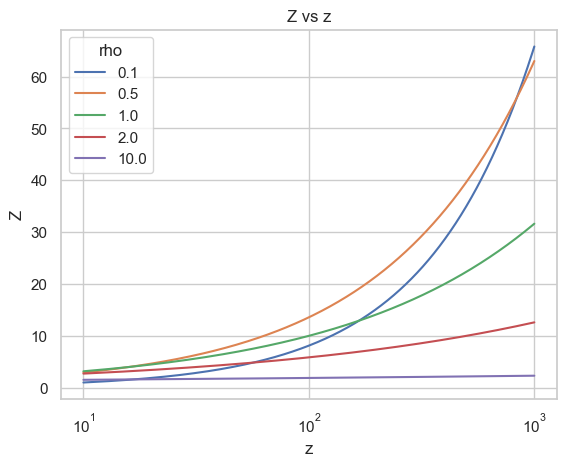

In [46]:
rho = np.array([0.1, 0.5, 1., 2., 10])
z = np.linspace(10., 1e3, 1000)
df = pd.DataFrame(np.asarray(np.meshgrid(rho, z)).T.reshape(-1, 2), columns=["rho", "z"])
df = df.assign(Z = lambda x: np.power(x["rho"] * x["z"], 1/(x["rho"]+1)))
df["rho"] = df["rho"].astype("category")

ax = sns.lineplot(x="z", y="Z", hue="rho", data=df)
ax.set(xscale="log")
ax.set_title("Z vs z");

**It becomes clear that the asymptotic expansion only works when $\rho$ is not too large.**
Otherweise, $Z$ will be too small.

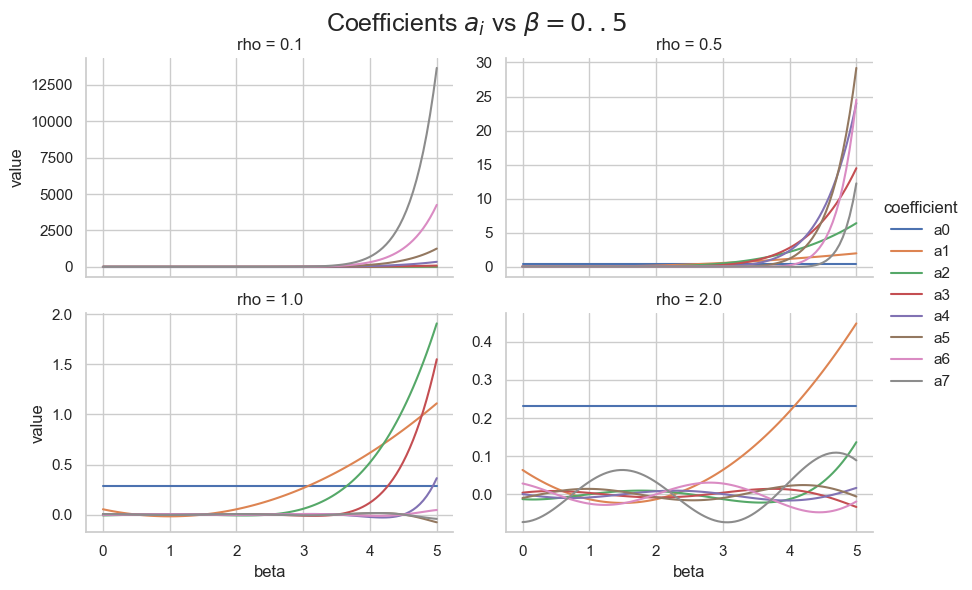

In [47]:
rho = np.array([0.1, 0.5, 1., 2.])
beta = np.linspace(0, 5, 100)
df = pd.DataFrame(
    np.asarray(np.meshgrid(rho, beta)).T.reshape(-1, 2), columns=["rho", "beta"]
)
df["a0"], df["a1"], df["a2"], df["a3"], df["a4"], df["a5"], df["a6"], df["a7"] = [0.] * 8

for row in df.itertuples():
    df.loc[row.Index, ["a0", "a1", "a2", "a3", "a4", "a5", "a6", "a7"]] = (
        H(1., row.rho, row.beta, order=5, verbose=True)[1]
    )

df = df.melt(
    id_vars=["rho", "beta"],
    value_vars=["a0", "a1", "a2", "a3", "a4", "a5", "a6", "a7"],
    var_name="coefficient",
)
g = sns.FacetGrid(
    data=df, col="rho", hue="coefficient", sharey=False, col_wrap=2, aspect=1.5
)
g.map(plt.plot, "beta", "value")
g.add_legend()
g.fig.suptitle("Coefficients $a_i$ vs $\\beta = 0..5$", fontsize=18)
#g.fig.subplots_adjust(hspace=0.3);
g.fig.subplots_adjust(top=0.9);

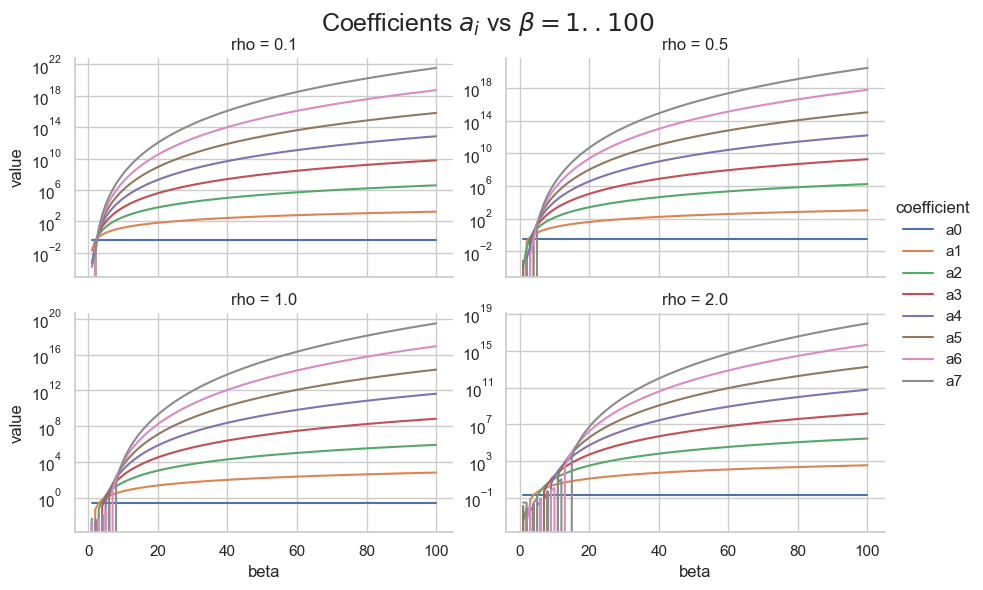

In [48]:
rho = np.array([0.1, 0.5, 1., 2.])
beta = np.linspace(1, 100, 100)
df = pd.DataFrame(
    np.asarray(np.meshgrid(rho, beta)).T.reshape(-1, 2), columns=["rho", "beta"]
)
df["a0"], df["a1"], df["a2"], df["a3"], df["a4"], df["a5"], df["a6"], df["a7"] = [0.] * 8

for row in df.itertuples():
    df.loc[row.Index, ["a0", "a1", "a2", "a3", "a4", "a5", "a6", "a7"]] = (
        H(1., row.rho, row.beta, order=5, verbose=True)[1]
    )

df = df.melt(
    id_vars=["rho", "beta"],
     value_vars=["a0", "a1", "a2", "a3", "a4", "a5", "a6", "a7"],
     var_name="coefficient",
)
g = sns.FacetGrid(
    data=df, col="rho", hue="coefficient", sharey=False, col_wrap=2, aspect=1.5
)
g.map(plt.plot, "beta", "value")
g.set(yscale="log")
g.add_legend()
g.fig.suptitle("Coefficients $a_i$ vs $\\beta=1..100$", fontsize=18)
#g.fig.subplots_adjust(hspace=0.3);
g.fig.subplots_adjust(top=0.9);

In [49]:
# Coefficients (except a0) are zero at rho=1, beta=1/2 ?
H(1., rho=1, beta=1/2, order=7, verbose=True)[1]

array([0.28209479, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        ])

#### 2.3.2 Search for region of convergence $Z > \ldots$
In general, the asymptotic expansion is good only for large $Z$, wich is more likely for smaller $\rho$, say $\rho < 5$.
Additionally, the expansion is good only if the coefficients $a_k$ are not too large.
As the leading term of $a_k$ in $\beta$ is $\frac{\beta^{2k}}{2^k k! (\rho + 1)^k}$, the asymptotic expansion is only good for not too large $\beta$.

Text(0.5, 1.0, 'Accuracy of Asymptotic Expansion')

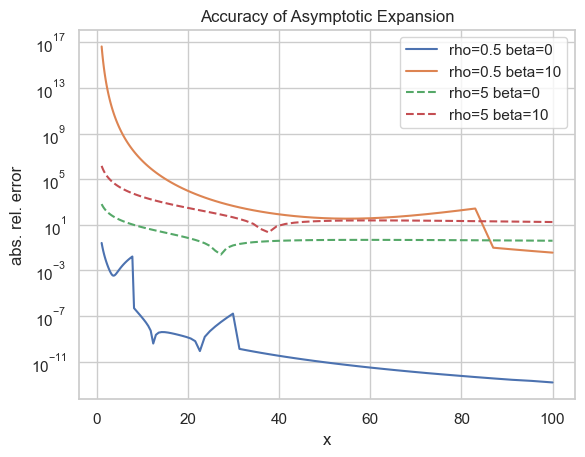

In [50]:
fig, ax = plt.subplots()
x = np.logspace(np.log(1), np.log(100), num=100, base=np.exp(1))
for rho, beta in itertools.product([0.5, 5], [0, 10]):
    y1 = np.array([
        Wright_Series_MPMATH(rho, beta, xx, dps=30, maxterms=2000, method="d") for xx in x
    ])
    y2 = np.array([Wright_Asymptotic(rho, beta, xx, order=8) for xx in x])
    lsty = "solid" if rho == 0.5 else "dashed"
    ax.plot(x, np.abs(y2/y1 - 1), label=f"{rho=} {beta=}", linestyle=lsty)
ax.set(yscale="log")
ax.set_xlabel("x")
ax.set_ylabel("abs. rel. error")
ax.legend()
ax.set_title("Accuracy of Asymptotic Expansion")

In [51]:
%%time
# Grid search for region of convergence
# set Z = 12  + beta**2 / (10*(1+rho))
rho = np.array([1e-2, 1e-1, 0.2, 0.5, 0.7, 0.9, 1, 1.1, 1.5, 2, 5, 10])
beta = np.array([0, 0.1, 0.2, 0.5, 0.7, 0.9, 1, 1.2, 1.5, 2, 5, 10, 100])
df = pd.DataFrame(np.asarray(np.meshgrid(rho, beta)).T.reshape(-1, 2), columns=["rho", "beta"])

df["x"] = np.power(12 + df["beta"]**2 / 4 / (1 + df["rho"]), 1 + df["rho"]) / df["rho"]
df["Z"] = np.power(df["rho"] * df["x"], 1./(df["rho"]+1))

df = df.query("log(Z) * (0.5 - beta) + (1+rho)/rho * Z <= 900")  # protection against overflow
df = df.sort_values(by=["rho", "beta", "x"])

df["a0"], df["a1"], df["a2"], df["a3"], df["a4"], df["a5"], df["a6"], df["a7"] = [0.]*8
df["H_5"] = 0.
df["H_6"] = 0.
df["H_7"] = 0.
df["H_8"] = 0.
df["MPMATH"] = 0.

for row in df.itertuples():
    df.loc[row.Index, ["a0", "a1", "a2", "a3", "a4", "a5", "a6", "a7"]] = \
    H(1., row.rho, row.beta, order=5, verbose=True)[1]
    df.at[row.Index, "H_6"] = H(row.Z, row.rho, row.beta, order=6)
    df.at[row.Index, "H_7"] = H(row.Z, row.rho, row.beta, order=7)
    df.at[row.Index, "H_8"] = H(row.Z, row.rho, row.beta, order=8)
    df.at[row.Index, "MPMATH"] = float(
        Wright_Series_MPMATH(row.rho, row.beta, row.x, dps=30, steps=[200], maxterms=1100, method="s")
    )

df["rel_error_5"] = df["H_5"] / df["MPMATH"] - 1
df["rel_error_6"] = df["H_6"] / df["MPMATH"] - 1
df["rel_error_7"] = df["H_7"] / df["MPMATH"] - 1
df["rel_error_8"] = df["H_8"] / df["MPMATH"] - 1

CPU times: user 6.83 s, sys: 39.8 ms, total: 6.87 s
Wall time: 6.88 s


In [52]:
with pd.option_context("display.max_rows", 40, "display.float_format", "{:.4g}".format):
    display(df
            .sort_values(by=["rho", "beta", "x"])
            .loc[:, ["rho", "beta", "x", "Z", "MPMATH", "rel_error_5", "rel_error_6", "rel_error_7", "rel_error_8"]])

rho  beta         x     Z     MPMATH  rel_error_5  rel_error_6  \
13   0.1     0     153.9    12  2.775e+57           -1   -8.001e-13   
14   0.1   0.1     153.9    12  2.228e+57           -1   -1.032e-11   
15   0.1   0.2       154 12.01  1.879e+57           -1   -1.664e-11   
16   0.1   0.5     154.7 12.06  1.514e+57           -1   -6.403e-12   
17   0.1   0.7     155.4 12.11  1.673e+57           -1      1.2e-11   
..   ...   ...       ...   ...        ...          ...          ...   
151   10   1.5 7.786e+10 12.05       6818           -1      -0.1883   
152   10     2 8.073e+10 12.09       2087           -1       -0.195   
153   10     5 1.236e+11 12.57      1.472           -1     -0.03742   
154   10    10 5.007e+11 14.27  6.886e-06           -1       0.1988   
155   10   100 1.472e+25 239.3 7.158e-125           -1     0.001144   

     rel_error_7  rel_error_8  
13    -1.771e-12   -1.013e-13  
14    -1.735e-12   -2.576e-14  
15    -1.189e-12    8.105e-14  
16     1.334e-12    1.443e-13  
17     1.409e-12   -4.186e-14  
..           ...          ...  
151      -0.1885      -0.1884  
152      -0.1951      -0.1951  
153     -0.03743     -0.03754  
154       0.1989       0.1989  
155   -4.439e-05    7.575e-07  

[135 rows x 9 columns]

In [53]:
# Does a small term (a_k) correspond to small relative error in total? Yes.
# exclude zeros of coefficients: rho=1 and beta=0.5 or beta=1.5
df.loc[
    (np.abs(df["a5"]/df["Z"]**5 / df["a0"]) < 1e-8)
    & ~((df["rho"]==1) & (df["beta"]==0.5))
    & ~((df["rho"]==1) & (df["beta"]==1.5)),
    ["rho", "beta", "x", "Z", "a0", "a1", "a5", "a6", "MPMATH", "rel_error_5", "rel_error_6"]
]

rho  beta           x          Z        a0        a1        a5        a6  \
13  0.1   0.0  153.850662  12.000000  0.380377  0.036309  0.000179 -0.000260   
14  0.1   0.1  153.882715  12.002273  0.380377  0.019019  0.000288 -0.000186   
15  0.1   0.2  153.978876  12.009091  0.380377  0.005187  0.000318 -0.000066   
16  0.1   0.5  154.652157  12.056818  0.380377 -0.015561 -0.000029  0.000246   
17  0.1   0.7  155.421948  12.111364  0.380377 -0.012103 -0.000295  0.000146   
18  0.1   0.9  156.448875  12.184091  0.380377  0.005187 -0.000211 -0.000141   
19  0.1   1.0  157.058903  12.227273  0.380377  0.019019 -0.000029 -0.000245   
20  0.1   1.2  158.472425  12.327273  0.380377  0.057056  0.000322 -0.000168   
21  0.1   1.5  161.077586  12.511364  0.380377  0.140048  0.000020  0.000245   
26  0.2   0.0   98.625110  12.000000  0.364183  0.038947 -0.000155 -0.000186   
27  0.2   0.1   98.645657  12.002083  0.364183  0.022256  0.000028 -0.000278   
28  0.2   0.2   98.707303  12.008333  0.364183  0.008599  0.000194 -0.000303   
29  0.2   0.5   99.139005  12.052083  0.364183 -0.014163  0.000306 -0.000009   
30  0.2   0.7   99.632762  12.102083  0.364183 -0.014163  0.000016  0.000246   
31  0.2   0.9  100.291740  12.168750  0.364183 -0.002023 -0.000305  0.000259   
32  0.2   1.0  100.683350  12.208333  0.364183  0.008599 -0.000365  0.000148   
33  0.2   1.2  101.591211  12.300000  0.364183  0.038947 -0.000155 -0.000186   
34  0.2   1.5  103.266036  12.468750  0.364183  0.107232  0.000448 -0.000233   
35  0.2   2.0  106.899918  12.833333  0.364183  0.281736  0.001068  0.000060   
39  0.5   0.0   83.138439  12.000000  0.325735  0.045241 -0.000417  0.000630   
40  0.5   0.1   83.155760  12.001667  0.325735  0.030040 -0.000601  0.000680   
41  0.5   0.2   83.207730  12.006667  0.325735  0.017011 -0.000682  0.000624   
42  0.5   0.5   83.571827  12.041667  0.325735 -0.009048 -0.000326  0.000005   
43  0.5   0.7   83.988586  12.081667  0.325735 -0.015563  0.000182 -0.000445   
44  0.5   0.9   84.545338  12.135000  0.325735 -0.013391  0.000570 -0.000609   
45  0.5   1.0   84.876490  12.166667  0.325735 -0.009048  0.000637 -0.000538   
46  0.5   1.2   85.645021  12.240000  0.325735  0.006153  0.000444 -0.000130   
47  0.5   1.5   87.065843  12.375000  0.325735  0.045241 -0.000417  0.000630   
48  0.5   2.0   90.161994  12.666667  0.325735  0.153819 -0.000287 -0.000203   
52  0.7   0.0   97.613543  12.000000  0.305975  0.048596  0.000504 -0.000196   
53  0.7   0.1   97.633880  12.001471  0.305975  0.034197  0.000079  0.000251   
54  0.7   0.2   97.694902  12.005882  0.305975  0.021598 -0.000325  0.000639   
57  0.7   0.9   99.266489  12.119118  0.305975 -0.016199 -0.000285  0.000011   
58  0.7   1.0   99.655871  12.147059  0.305975 -0.014399  0.000082 -0.000382   
59  0.7   1.2  100.560005  12.211765  0.305975 -0.005400  0.000759 -0.000989   
61  0.7   2.0  105.886894  12.588235  0.305975  0.102592 -0.000958  0.001223   
68  0.9   0.5  125.447125  12.032895  0.289423 -0.001777 -0.000670  0.000944   
72  0.9   1.2  128.566820  12.189474  0.289423 -0.012440 -0.000653  0.000631   
95  1.1   0.7  169.555005  12.058333  0.275296 -0.010051 -0.000573  0.000508   

          MPMATH  rel_error_5   rel_error_6  
13  2.774655e+57         -1.0 -8.001377e-13  
14  2.227664e+57         -1.0 -1.031542e-11  
15  1.878871e+57         -1.0 -1.663880e-11  
16  1.513574e+57         -1.0 -6.403322e-12  
17  1.673350e+57         -1.0  1.199751e-11  
18  2.247520e+57         -1.0  1.568656e-11  
19  2.801291e+57         -1.0  9.182211e-12  
20  5.031101e+57         -1.0 -1.014966e-11  
21  1.738026e+58         -1.0 -7.161161e-12  
26  2.323892e+31         -1.0  2.521250e-11  
27  1.842651e+31         -1.0  1.954636e-11  
28  1.497080e+31         -1.0  9.622303e-12  
29  9.282391e+30         -1.0 -2.024836e-11  
30  7.609401e+30         -1.0 -1.836808e-11  
31  6.859997e+30         -1.0  1.667999e-12  
32  6.748300e+30         -1.0  1.254685e-11  
33  7.006762e+30     

In [54]:
df.query("abs(rel_error_8) <= 1e-10").loc[:, "rho"].unique()

array([0.1, 0.2, 0.5, 0.7, 0.9, 1. , 1.1, 1.5])

In [55]:
rho, beta, z = 1, 10, 500
Z = np.power(rho * z, 1/(rho+1))
print(f"Z = {Z}, beta**2/(10(1+rho))={beta**2/(10*(1+rho))}")

y1 = float(Wright_Series_MPMATH(rho, beta, z, steps=[5000], dps=40, maxterms=10_000, method="d"))
for order in [6, 7, 8]:
    print(
        f"relaltive error with asymptotic expansion of {order=}: "
        f"{rel_err(Wright_Asymptotic(rho, beta, z, order=order), y1):>9.2e}"
    )

Z = 22.360679774997898, beta**2/(10(1+rho))=5.0
relaltive error with asymptotic expansion of order=6:  4.06e-05
relaltive error with asymptotic expansion of order=7: -1.44e-06
relaltive error with asymptotic expansion of order=8:  1.60e-08


### 2.4 Integral Representation <a id="integral"></a>
[back to TOC](#toc)
<br>
See Luchko (2008).
Note that the definition of $P(\rho, \beta, x, \epsilon, \varphi)$ in Eq. (9) has a misprint.
The $\cos(\varphi(\beta-1))$ at the end of the first line should be removed and the the $−\sin(\varphi(\beta−1))$ at the end of the second line should read $+(1-b)\varphi$.

Here we use $a=\rho$ and $b=\beta$:
$$K(a, b, x, r) = \exp(-r + x \cdot r^{-a} \cos(\pi a)) \cdot r^{-b} \cdot
                  \sin(x \cdot r^{-a} \sin(\pi a) + \pi b)$$
$$P(\epsilon, a, b, x, \varphi) = \exp(\epsilon \cos(\varphi) + x \cdot \epsilon^{-a} \cos(a \varphi))
                          \cdot \cos(\epsilon \sin(\varphi) - x \cdot \epsilon^{-a} \sin(a \varphi)
                              + (1-b) \varphi)$$
Then
$$\Phi(a, b, x) = \frac{1}{\pi} \int_{\epsilon}^\infty K(a, b, x, r) \; dr
        + \frac{\epsilon^{1-b}}{\pi} \int_0^\pi P(\epsilon, a, b, x, \varphi) \; d\varphi$$

for any $\epsilon > 0$.

**Very importantly**, while Luchko (2008) strives to set the limit $\epsilon \rightarrow 0$, we use the freedom to choose it.
In fact, any $\epsilon > 0$ is allowed.

#### 2.4.1 Definition of Integral Representation
Here comes already the full implementation of the integral represantation.
This includes the choice of $\epsilon$.
The next section goes into depth how this is done.

##### Notes on $K$:
Note that we shift the integrand over $K$ by $-\epsilon$:
$$\int_{\epsilon}^\infty K(a, b, x, r) \; dr = \int_{0}^\infty K(a, b, x, r + \epsilon) \; dr = e^{-\epsilon}\int_{0}^\infty e^{-r} K_{mod}(a, b, x, r) \; dr$$
with $K_{mod}(\rho, \beta, x, r) = e^{r+\epsilon} K(\rho, \beta, x, r+\epsilon)$.

This is then integrated via fixed order [Gauss-Laguerre quadrature](https://en.wikipedia.org/wiki/Gauss%E2%80%93Laguerre_quadrature), which thereby absorbes the factor $e^{r}$ as it evaluates integrals as $\int_{0}^\infty e^{-r} f(r) \; dr \approx \sum_i w_i f(x_i)$ with $x_i$ the sample pints and $w_i$ the weights of the Gauss-Laguerr quadrature.

##### Notes on $P$:
This is a *simple* integrand (no infinite bounds), so we use the [Gauss-Legendre quadrature](https://en.wikipedia.org/wiki/Gauss%E2%80%93Legendre_quadrature).

For $P$, the choice of $\epsilon$ is often much more important than for $K$ because of its potential oscillatory behaviour.

In [56]:
def K(rho, beta, x, r):
    r_rho = np.power(r, -rho)
    return (
        np.exp(-r + x * r_rho * np.cos(np.pi*rho))
        * np.power(r, -beta)
        * np.sin(x * r_rho * np.sin(np.pi * rho) + np.pi * beta)
    )

def Kmod(eps, rho, beta, x, r):
    """
    Kmod = K(rho, beta, x, r+eps) / exp(-r-eps)
    """
    r_rho = np.power(r+eps, -rho)
    return (
        np.exp(x * r_rho * np.cos(np.pi*rho))
        * np.power(r+eps, -beta)
        * np.sin(x * r_rho * np.sin(np.pi * rho) + np.pi * beta)
    )

def P(eps, rho, beta, x, phi):
    """Beware of misprints in Luchko!!!"""
    eps_rho = np.power(1. * eps, -rho)
    return (
        np.exp(eps*np.cos(phi) + x * eps_rho * np.cos(rho*phi))
        * np.cos(eps*np.sin(phi) - x * eps_rho * np.sin(rho*phi) + (1-beta)*phi)
    )

def Wright_Integral_quad(rho, beta, z, error_out=False, eps=1e-10, epsrel=1e-10):
    if rho <= -1:
        raise ValueError("rho must be larger than -1.")    
    
    # boundary r0 for integral over K according to Luchko:
    if z * np.cos(np.pi * rho) <= 0:
        if beta >= 0:
            r0 = -np.log(eps)
        else:
            r0 = max(-beta + 1,
                     -2 * np.log(eps * np.power(-2.*beta, beta)/(-beta + 2)))
    elif beta >= 0:
        r0 = max(-2 * np.log(eps*np.power(2., beta-1)),
                 np.power(2 * z * np.cos(rho*np.pi), 1/(1+rho)))
    else:
        r0 = max(2 * (-beta + 1),
                 -4 * np.log(eps * np.power(-4.*beta, beta) / (2*(-beta + 2))),
                 np.power(2 * z * np.cos(rho*np.pi), 1/(1+rho)))

    if z > 0:
        if (rho < 0 and beta <= 1) or (rho == 0 and beta < 1):
            K_int = integrate.quad(lambda r: K(rho, beta, z, r), 0, r0, epsrel=epsrel, limit=1000)
            err = 1./np.pi * K_int[1]
            res = 1./np.pi * K_int[0]
        
            if beta == 1 and rho < 0:
                res += 1.
        else:
            K_int = integrate.quad(lambda r:   K(rho, beta, z, r),   1, r0, epsrel=epsrel, limit=1000)
            P_int = integrate.quad(lambda phi: P(1, rho, beta, z, phi), 0, np.pi,  epsrel=epsrel, limit=1000)
            err = 1./np.pi * (K_int[1] + P_int[1])
            res = 1./np.pi * (K_int[0] + P_int[0])            
    else:
        raise NotImplementedError("z < 0 is not yet implemented.")
        
    if error_out:
        return res, err
    else:
        return res


def _cached_roots_laguerre(n):
    """Cache roots_laguerre results to speed up calls of the fixed_laguerre function.
    """
    if n in _cached_roots_laguerre.cache:
        return _cached_roots_laguerre.cache[n]

    _cached_roots_laguerre.cache[n] = ss.roots_laguerre(n)
    return _cached_roots_laguerre.cache[n]


_cached_roots_laguerre.cache = dict()


def fixed_laguerre(func, args=(), n=5):
    """Compute fixed order Gauss-Laguerre quadruature"""
    x, w = _cached_roots_laguerre(n)
    x = np.real(x)
    return np.sum(w*func(x, *args), axis=-1), None


def eps_select(rho, beta, z):
    """Select an appropriate eps for integration.
    a = rho, b=beta, z = x
    """
    # We use the free choice of eps to make the integral better behaved.
    # 1. Concern is oscillatory behaviour of P. Therefore, we'd like to
    #    make the change in the argument of cosine small, i.e. make arc length
    #    int_0^phi sqrt(1 + f'(phi)^2) dphi small, with
    #    f(phi) = eps * sin(phi) - x * eps^(-a) * sin(a*phi) + (1-b)*phi
    #    Proxy, make |f'(phi)| small.
    # 2. Concern is int_0 K ~ int_0 (r+eps)^(-b) .. dr
    #    This is difficult as r -> 0  for large b. It behaves better for larger
    #    values of eps.
    #
    # 1. Minimize oscillatory behaviour of P.
    #a = [2.25974, 12.3104, 0.975979, 1.57556, 2.42271, 1.94177E-03]
    #eps = a[0] * beta + a[1] * np.power(z, a[2]/(1.+rho)) * np.power(rho, a[3]) * (np.exp(-a[4]*np.sqrt(rho)) + a[5])
    A = [0.41037, 0.30833, 6.9952, 18.382, -2.8566, 2.1122]
    eps = A[0] * beta * np.exp(-0.5*rho) + np.exp(A[1] + 1/(1+rho) * np.log(z) - A[2] * np.exp(-A[3]*rho) + A[4] / (1 + np.exp(A[5]*rho)))
    if rho >= 4 and z >= 100:
        eps += 1  # This part is hard to fit
        
    # 2. Large b
    if beta >= 8:
        # Make P small compared to K by setting eps large enough.
        # int K ~ exp(-eps) and int P ~ eps^(1-b)
        eps = max(eps, np.power(beta, -beta/(1.-beta)) + 0.1 * beta)

    # safeguard, higher better for larger a, lower better for tiny a.
    eps = min(eps, 150.)
    eps = max(eps, 3.)
    return eps


def Wright_Integral(rho, beta, z, n_laguerre=50, n_legendre=50, eps=None):
    """
    Compute Wrights generalized Bessel function via integration.
    
    n_laguerre : order of quadrature rule for gauss-laguerre for integration over K.
    n_legendre : order of quadrature rule for gauss-legendre for integration over P.

    If eps=None, it will be set by eps_select.
    """
    if rho <= -1:
        raise ValueError("rho must be larger than -1.")    

    if z > 0:
        if (rho < 0 and beta <= 1) or (rho == 0 and beta < 1):
            # integrate from 0 to inf
            K_int = fixed_laguerre(lambda r: K(rho, beta, z, r) * np.exp(r), n=n_laguerre)[0]
            res = 1. / np.pi * K_int
        
            if beta == 1 and rho < 0:
                res += 1.
        else:
            if eps is None:
                eps = eps_select(rho, beta, z)
            K_int = fixed_laguerre(lambda r: Kmod(eps, rho, beta, z, r), n=n_laguerre)
            P_int = integrate.fixed_quad(lambda phi: P(eps, rho, beta, z, phi), 0, np.pi, n=n_legendre)
            res = 1. / np.pi * (np.exp(-eps) * K_int[0] + np.power(eps, 1.-beta) * P_int[0])            
    else:
        raise NotImplementedError("z < 0 is not yet implemented.")
        
    return res

In [57]:
rho = 1.
beta = 10.
x = 500.
y1 = Wright_Series_MPMATH(rho, beta, x, steps=[100])
y2 = Wright_Integral(rho, beta, x, n_laguerre=50, n_legendre=50)
print(f"{rho=} {beta=} {x=} Phi={y1}")
print(f"rel. error = {rel_err(y2, y1):.3e} selected eps={eps_select(rho, beta, x):.3}")

rho=1.0 beta=10.0 x=500.0 Phi=454308.62922139864454
rel. error = -2.671e-14 selected eps=24.9


In [58]:
rho = 0.1
beta = 5.
x = 100.
y1 = Wright_Series_MPMATH(rho, beta, x, steps=[100])
y2 = Wright_Integral(rho, beta, x, n_laguerre=50, n_legendre=50)
print(f"{rho=} {beta=} {x=} Phi={y1}")
print(f"rel. error = {rel_err(y2, y1):.3e} selected eps={eps_select(rho, beta, x):.3}")

rho=0.1 beta=5.0 x=100.0 Phi=6.5570973986411541890E+33
rel. error = 4.174e-05 selected eps=10.1


In the following 2 cases, we see the large change of accuracy that comes from a changing $\epsilon$ from the optimized value of 3 to the naive value of 1.

In [59]:
rho = 0.001
beta = 7.
x = 100.
y1 = Wright_Series_MPMATH(rho, beta, x, steps=[200], method="s")
y2 = Wright_Integral(rho, beta, x, n_laguerre=50, n_legendre=50)
y3 = Wright_Integral(rho, beta, x, n_laguerre=50, n_legendre=50, eps=1)
print(f"{rho=} {beta=} {x=} Phi={y1}")
print(f"rel. error = {rel_err(y2, y1):.3e} selected eps={eps_select(rho, beta, x):.3}")
print(f"rel. error = {rel_err(y3, y1):.3e} selected eps=1")

rho=0.001 beta=7.0 x=100.0 Phi=3.0940266655075123862E+40
rel. error = -2.741e-14 selected eps=3.0
rel. error = 3.432e-06 selected eps=1


In [60]:
rho = 0.001
beta = 7.
x = 500.
y1 = Wright_Series_MPMATH(rho, beta, x, steps=[2000], method="s")
y2 = Wright_Integral(rho, beta, x, n_laguerre=50, n_legendre=50)
y3 = Wright_Integral(rho, beta, x, n_laguerre=50, n_legendre=50, eps=1)
print(f"{rho=} {beta=} {x=} Phi={y1}")
print(f"rel. error = {rel_err(y2, y1):.3e} selected eps={eps_select(rho, beta, x):.3}")
print(f"rel. error = {rel_err(y3, y1):.3e} selected eps=1")

rho=0.001 beta=7.0 x=500.0 Phi=7.5076473891660503045E+213
rel. error = -9.355e-15 selected eps=3.04
rel. error = 3.402e-05 selected eps=1


Text(0.5, 1.0, 'Selected epsilon vs x at rho=0.001')

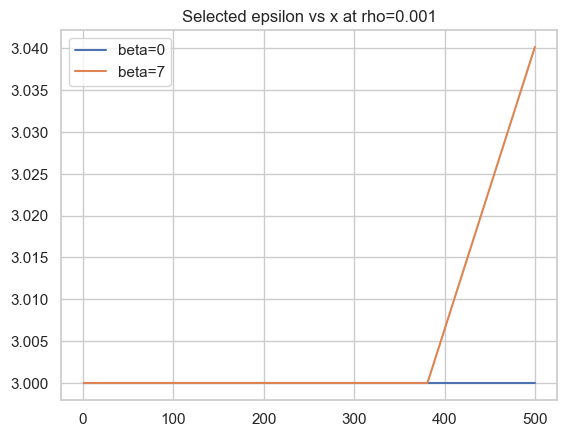

In [61]:
rho = 0.001
fig, ax = plt.subplots()
for beta in [0, 7]:
    x = np.linspace(1, 500, 500)
    ax.plot(x, [eps_select(rho, beta, xx) for xx in x], label=f"{beta=}")
ax.legend()
ax.set_title(f"Selected epsilon vs x at {rho=}")

In [62]:
# for rho < 0 and beta < 1, test integration equivalence
rho = -0.5
beta = 0.1
z = 1
integrate.quad(lambda r: K(rho, beta, z, r), 0, np.inf, epsrel=1e-6, limit=2000)[0], \
integrate.quad(lambda r: K(rho, beta, z, r), 1, np.inf, epsrel=1e-6, limit=2000)[0] \
+ integrate.quad(lambda phi: P(1, rho, beta, z, phi), 0, np.pi,  epsrel=1e-6, limit=1000)[0]

(-0.46574098486097193, -0.46574098486037246)

#### 2.4.2 Choice of epsilon: Integrand P
We have an integral over $K$ and an integral over $P$.
We are looking for a choice of $\epsilon$ that **makes both integrands numerical well behaved at the same time**.
Usually, wildly oscillatory behaviour is the worst case.
So we try to avoid that.

**Integrand P**
Goal: Least oscillatory behaviour of integrand => arc length of argument of $cos(...)$ of $P(\epsilon, a, b, x, \varphi)$ should be minimal.
[Arc length](https://en.wikipedia.org/wiki/Arc_length) of function $f$ is computed as $\int \sqrt{1+f'(t)^2}dt$.

We have $f(\varphi) = \epsilon \sin(\varphi) - x \epsilon^{-\rho} \sin(\rho \varphi) + (1-\beta) \varphi$ and arc length $s = \int_0^\pi \sqrt{1+f^{\prime 2}}d\varphi$.

Why did we only use the arc length of $\sin(\ldots)$ and not of the whole $P$?
Well, it would involve integrating over $P$ such that the arc length would be as hard as the object we want to integrate in the first place.
It turns out that this is a very reasonable approximation.

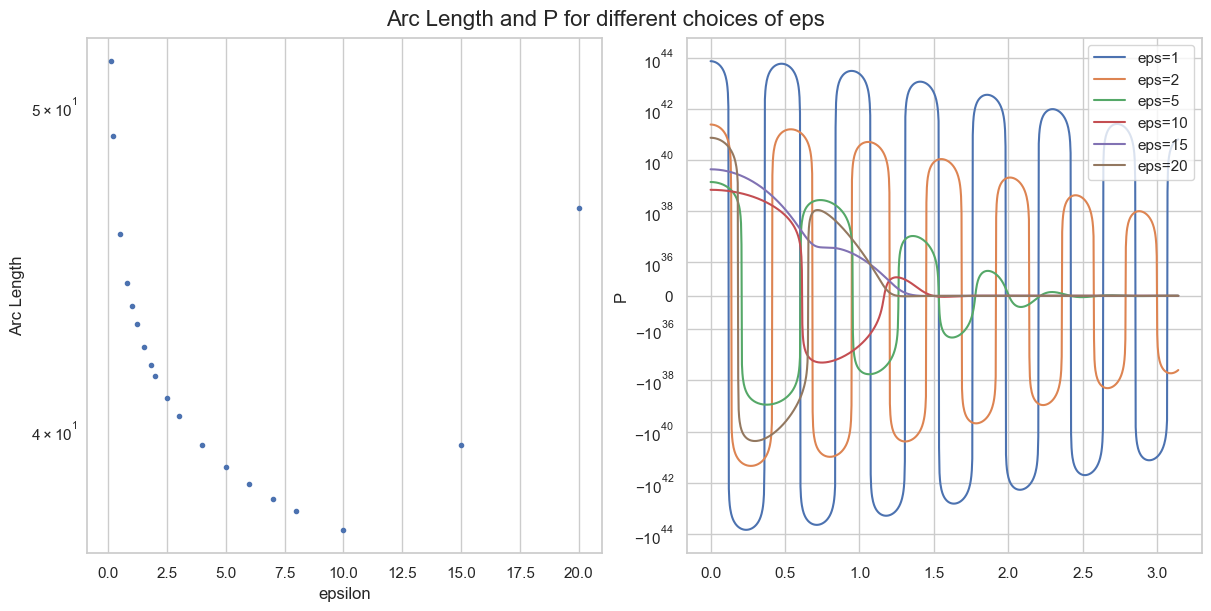

In [63]:
# Arc length of argument of cosine part of P
def f(eps, rho, beta, x, phi):
    """Argument of cosine of P."""
    eps_rho = np.power(1.*eps, -rho)
    return eps*np.sin(phi) - x * eps_rho * np.sin(rho*phi) + (1-beta)*phi


def fp(eps, rho, beta, x, phi):
    """Derivative w.r.t. phi"""
    eps_rho = np.power(1.*eps, -rho)
    return eps*np.cos(phi) - rho* x * eps_rho * np.cos(rho*phi) + (1-beta)

def arclength(eps, rho, beta, x, epsrel=1e-2, limit=100):
    return integrate.quad(lambda phi: np.sqrt(1 + fp(eps, rho, beta, x, phi)**2), 0, np.pi,  epsrel=epsrel, limit=100)[0]


rho = 1e-1
beta = 5
x = 100

fig, axes = plt.subplots(1, 2, figsize=(12, 6), constrained_layout=True)
eps_list = [0.1, 0.2, 0.5, 0.8, 1, 1.2, 1.5, 1.8, 2, 2.5, 3, 4, 5, 6, 7, 8, 10, 15, 20]
eps_list_small = [1, 2, 5, 10, 15, 20]
phi = np.linspace(0, np.pi, 1_000)
res = []
for eps in eps_list:
    res.append(arclength(eps, rho, beta, x))
    # leave out np.power(eps, 1.-beta) as we are only interested in oscillation
    if eps in eps_list_small:
        y2 = P(eps, rho, beta, x, phi)
        axes[1].plot(phi, y2, label=f"eps={eps}")

axes[0].plot(eps_list, res, ".")
axes[0].set_xlabel("epsilon")
axes[0].set_ylabel("Arc Length")
axes[0].set_yscale("log")
axes[1].legend(loc="upper right")
axes[1].set_ylabel("P")
axes[1].set_yscale("asinh", linear_width=1e35, base=10)
fig.suptitle("Arc Length and P for different choices of eps", fontsize=16);

Now we find the $\epsilon$ which gives minimal arc length for some values of $\rho, \beta, x$

In [64]:
rho = 1e-1  # 4.999
beta = 5  # 0
x = 100  # 1e5

eps_opt = optimize.minimize_scalar(
            lambda eps: arclength(eps, rho, beta, x),
            bounds=(1e-3, 1000),
            method="Bounded", options={"xatol":1e-3}).x

y1 = Wright_Series_MPMATH(rho, beta, x, steps=[300])
y2 = Wright_Integral(rho, beta, x, n_laguerre=50, n_legendre=50)
y3 = Wright_Integral(rho, beta, x, n_laguerre=50, n_legendre=50, eps=eps_opt)
{
    "value": y1,
     "abs_rel_fit_esp": rel_err(y2, y1),
     "abs_rel_opt_esp": rel_err(y3, y1),
     "eps": eps_select(rho, beta, x),
     "eps_opt": eps_opt,
}

{'value': 6.5573711198083928606e+33,
 'abs_rel_fit_esp': -1.188792499335535e-14,
 'abs_rel_opt_esp': -3.44853194848744e-15,
 'eps': 10.149627517981061,
 'eps_opt': 11.3836891127056}

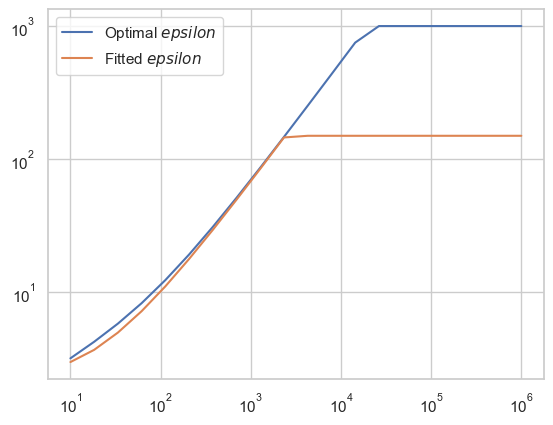

In [65]:
rho = 1e-1  # 4.999
beta = 5  # 0
x_list = np.logspace(1, 6, num=20)
res = []
for x in x_list:
    res.append(
        optimize.minimize_scalar(
            lambda eps: arclength(eps, rho, beta, x),
            bounds=(1e-3, 1000),
            method="Bounded", options={"xatol":1e-3}).x
    )

plt.plot(x_list, res, label="Optimal $epsilon$")
plt.plot(x_list, [eps_select(rho, beta, x) for x in x_list], label="Fitted $epsilon$")

plt.xscale("log")
plt.yscale("log")
plt.legend()

**Now the magic:** We find the optimal $\epsilon$ for a grid of data points and **fit** a function to these points.
If we choose a good functional form (some prior art!!!) that intra- and extrapolates well, then we have found a super choice of $\epsilon$.

In [66]:
%%time
# grid of minimal arc length values
data_rho = [1e-3, 0.1, 0.5, 0.9, 1, 2, 4, 5, 6, 8]
data_beta = [0, 1, 4, 7, 10]
data_x = [1, 1.5, 2, 4, 10, 20, 50, 100, 200, 500, 1e3, 5e3, 1e4]
data_rho, data_beta, data_x = np.meshgrid(data_rho, data_beta, data_x)
data_rho, data_beta, data_x = data_rho.flatten(), data_beta.flatten(), data_x.flatten()
best_eps = []
for i in range(data_x.size):
    best_eps.append(
        optimize.minimize_scalar(
            lambda eps: arclength(eps, data_rho[i], data_beta[i], data_x[i]),
            bounds=(1e-3, 1000),
            method="Bounded",
            options={"xatol":1e-3},
        ).x
    )
best_eps = np.array(best_eps)
df = pd.DataFrame({
    "rho": data_rho,
    "beta": data_beta,
    "x": data_x,
    "eps": best_eps,
})

# with pd.option_context("display.max_rows", 200):
#     display(df.query("eps>=1 and beta <= 8"))

CPU times: user 3.9 s, sys: 14.2 ms, total: 3.91 s
Wall time: 3.92 s


And here is our function that we fit via least squares:
$$f(\rho, \beta, x) = a_1 \beta e^{-\frac{1}{2} \rho} + e^{a_2 + \frac{\log(x)}{1+\rho} - a_3 e^{-a_4 \rho} + \frac{a_5}{1 + e^{a_6 \rho}}}$$
with parameters $a_1, \ldots, a_6$.

In [67]:
def func(data, a1, a2, a3, a4, a5, a6):
    rho = data["rho"]
    beta = data["beta"]
    x = data["x"]
    return (
        a1 * beta * np.exp(-0.5*rho)
        + np.exp(
            a2 + 1/(1+rho) * np.log(x) - a3 * np.exp(-a4*rho) + a5 / (1 + np.exp(a6*rho))
        )
    )

func_params = list(optimize.curve_fit(func, df, df["eps"], method="trf")[0])
func_params

[0.41036929567970204,
 0.3083321464843335,
 6.995192544799408,
 18.382034940021658,
 -2.8566177025334007,
 2.112188446194987]

In [68]:
print("Mean Squared Error")
np.square(
    func(pd.DataFrame({"rho": data_rho, "beta": data_beta, "x": data_x}), *func_params)
    - best_eps
).mean()

Mean Squared Error


1.3893478058360933

The results can be plotted in several ways.

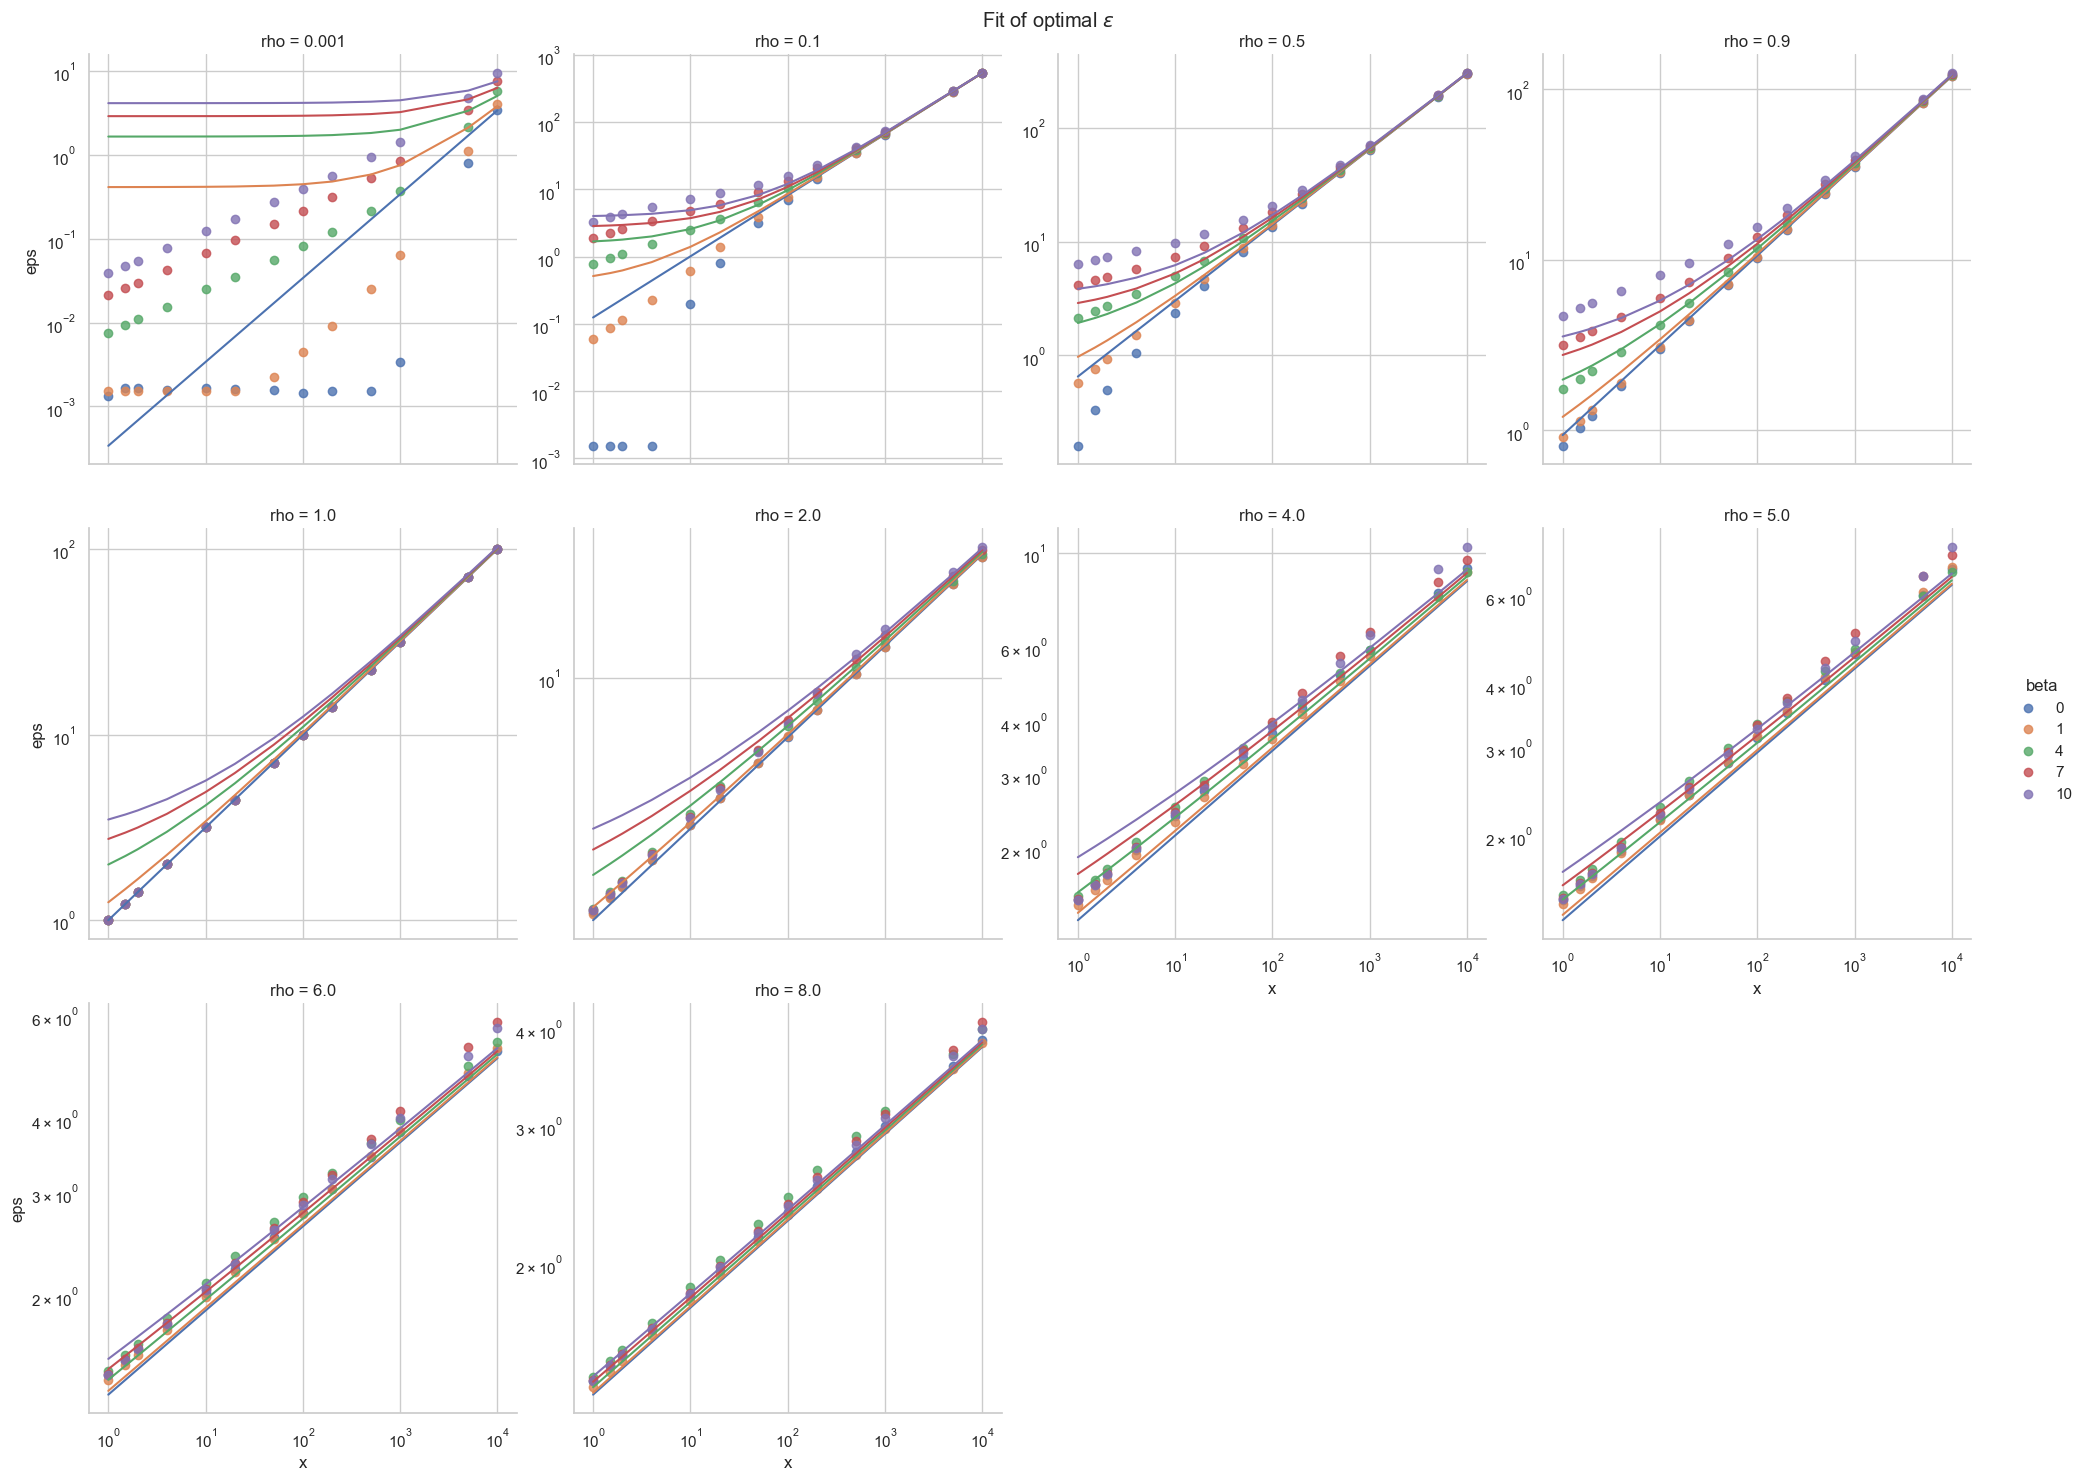

In [69]:
g = sns.lmplot(
    x = "x", y = "eps",
    hue="beta", col="rho",
    data = df,
    fit_reg=False,
    col_wrap=4,
    facet_kws=dict(sharey=False),
)

#g = sns.FacetGrid(df, hue="beta", col="rho")
#g.map(plt.scatter, "x", "eps")

def my_fit(*args, **kwargs):
    x = args[0]
    rho = args[2].iloc[0]
    beta = args[3].iloc[0]
    y = func(pd.DataFrame({"x": x, "rho": rho, "beta": beta}), *func_params)
    kwargs["marker"] = None
    return plt.plot(x, y, **kwargs)

g.map(my_fit, "x", "eps", "rho", "beta")
g.set(xscale = "log", yscale = "log")
g.fig.suptitle("Fit of optimal $\epsilon$")
g.fig.subplots_adjust(top=0.95)

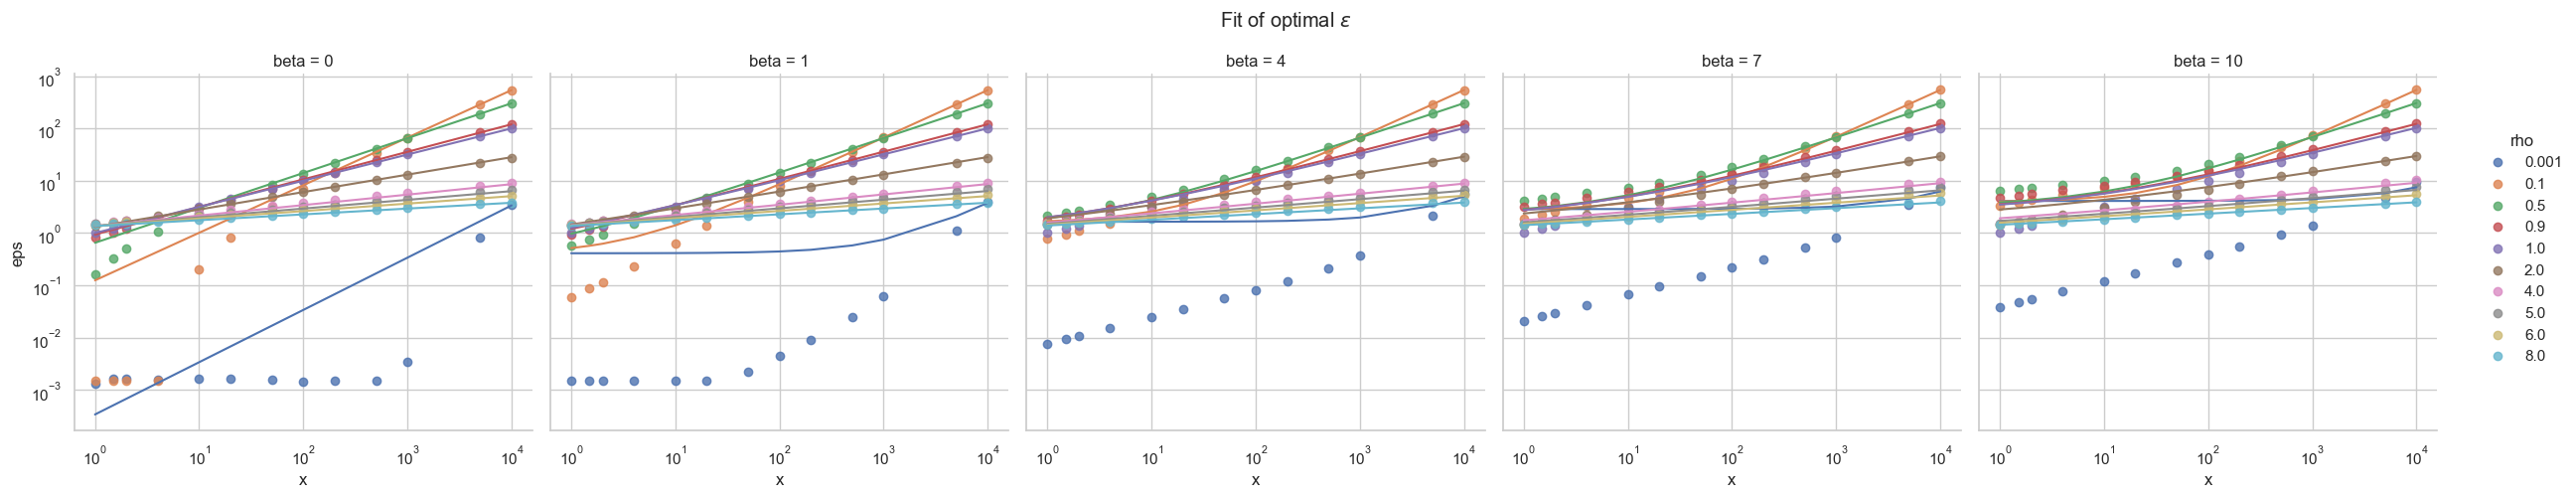

In [70]:
g = sns.lmplot(
    x = "x", y = "eps",
    col="beta", hue="rho",
    data = df,
    fit_reg=False,
    col_wrap=5,
)
g.map(my_fit, "x", "eps", "rho", "beta")
g.set(xscale = "log", yscale = "log")
g.fig.suptitle("Fit of optimal $\epsilon$")
g.fig.subplots_adjust(top=0.85)

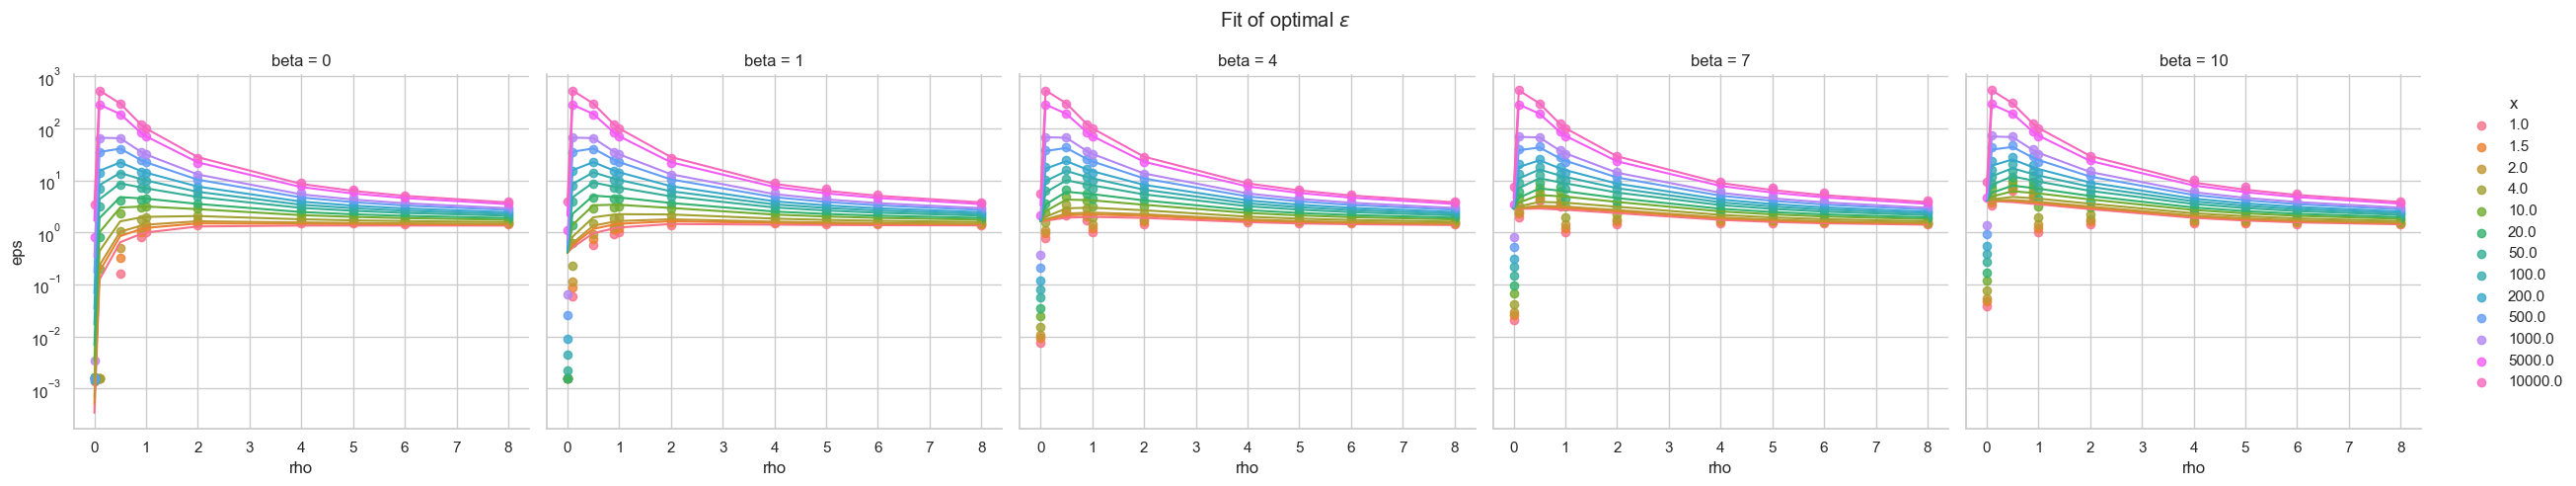

In [71]:
g = sns.lmplot(
    x = "rho", y = "eps",
    col="beta", hue="x",
    data = df,
    fit_reg=False,
    col_wrap=5,
)

def my_fit(*args, **kwargs):
    # Note the change of args order.
    x = args[2]
    rho = args[0]
    beta = args[3]
    y = func(pd.DataFrame({"x": x, "rho": rho, "beta": beta}), *func_params)
    kwargs["marker"] = None
    return plt.plot(rho, y, **kwargs)

g.map(my_fit, "rho", "eps", "x" , "beta")
g.set(yscale="log")
g.fig.suptitle("Fit of optimal $\epsilon$")
g.fig.subplots_adjust(top=0.85)

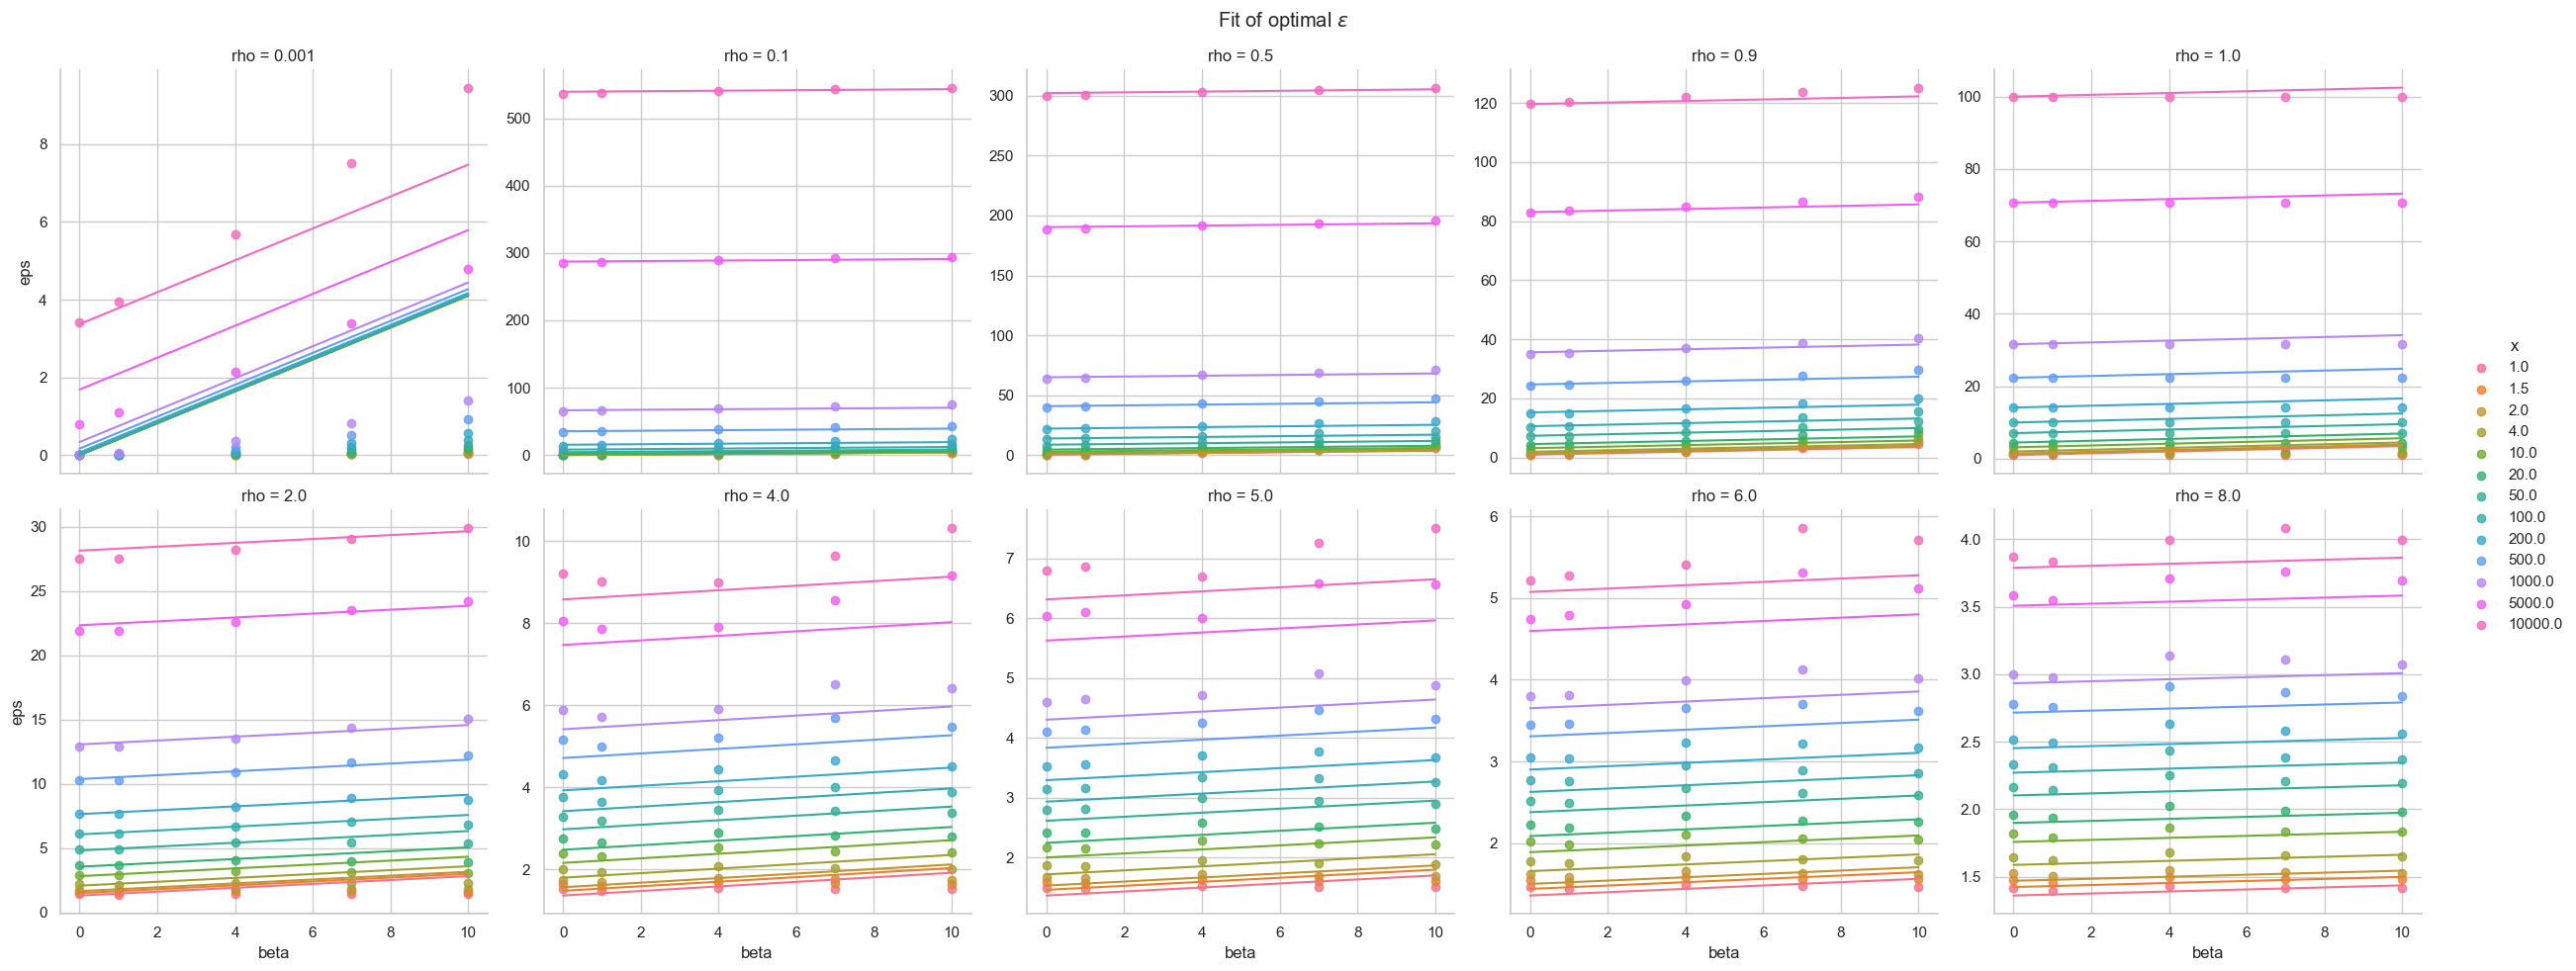

In [72]:
g = sns.lmplot(
    x = "beta", y = "eps",
    col="rho", hue="x",
    data = df,
    fit_reg=False,
    col_wrap=5,
    facet_kws=dict(sharey=False),
)

def my_fit(*args, **kwargs):
    # Note the change of args order.
    x = args[2]
    rho = args[3]
    beta = args[0]
    y = func(pd.DataFrame({"x": x, "rho": rho, "beta": beta}), *func_params)
    kwargs["marker"] = None
    return plt.plot(beta, y, **kwargs)

g.map(my_fit, "beta", "eps", "x" , "rho")
g.fig.suptitle("Fit of optimal $\epsilon$")
g.fig.subplots_adjust(top=0.92)

#### 2.4.3 Choice of epsilon: Integrand K
Potentially probematic is the behaviour for $r \rightarrow 0$ of the term $(r+\epsilon)^{-\beta}$.

Text(0.5, 0.98, 'Integrand K and parts of it')

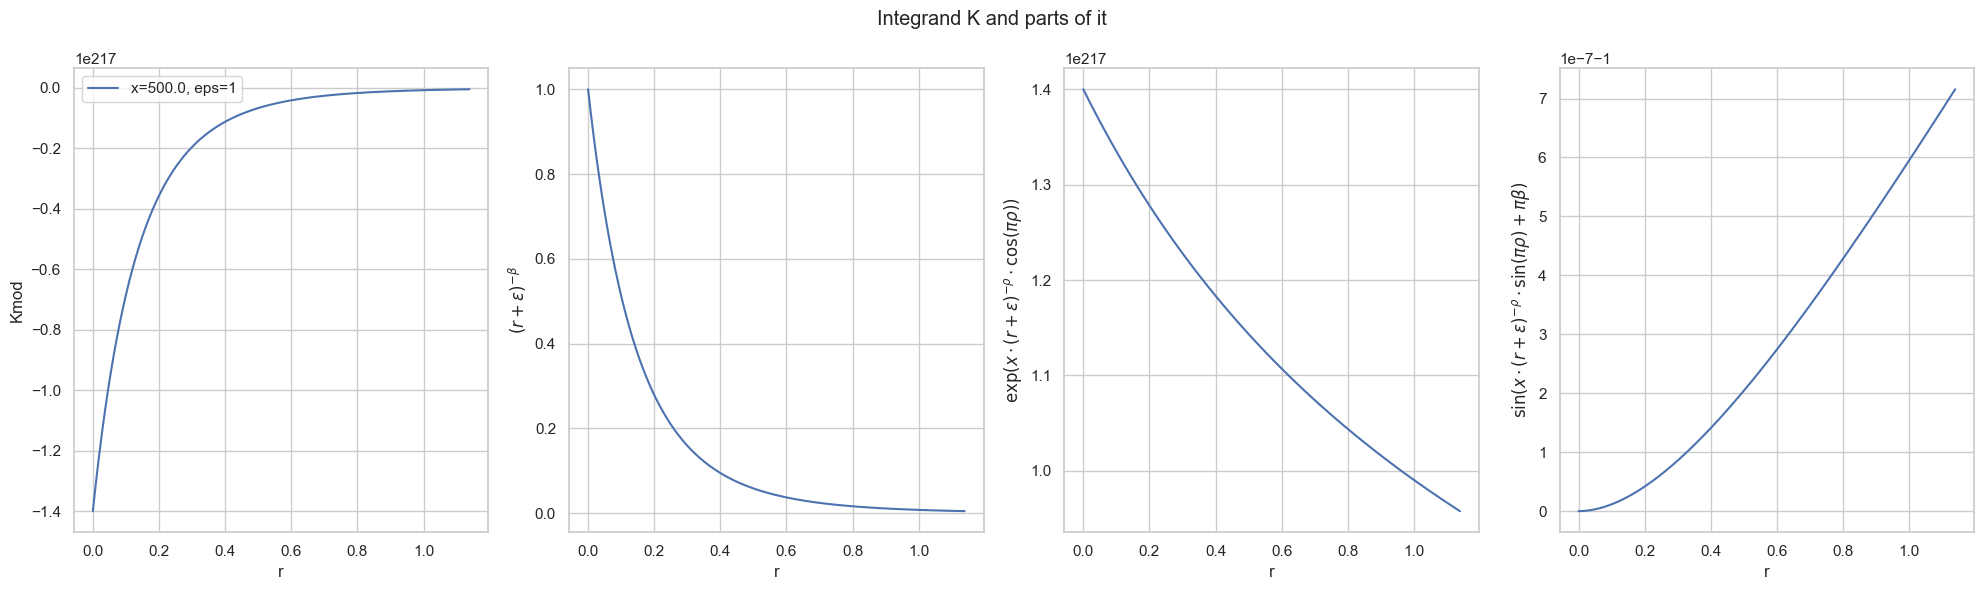

In [73]:
rho = 0.001
beta = 7
x = 500.

fig, axes = plt.subplots(1, 4, figsize=(4*5, 6), tight_layout=True)

eps = 1.
r = np.linspace(0, 1 + np.power(1e-6, 1./beta), 1_000)
y1 = Kmod(eps, rho, beta, x, r)
y2 = np.power(r+eps, -beta)

r_rho = np.power(r+eps, -rho)
y3 = np.exp(x * r_rho * np.cos(np.pi*rho))
y4 = np.sin(x * r_rho * np.sin(np.pi * rho) + np.pi * beta)

axes[0].plot(r, y1, label=f"x={x}, eps={1}")
axes[0].set_xlabel("r")
axes[0].set_ylabel("Kmod")
axes[0].legend()

axes[1].plot(r, y2)
axes[1].set_xlabel("r")
axes[1].set_ylabel(r"$(r+\epsilon)^{-\beta}$")

axes[2].plot(r, y3)
axes[2].set_xlabel("r")
axes[2].set_ylabel(r"$\exp(x \cdot (r+\epsilon)^{-\rho} \cdot \cos(\pi\rho))$")

axes[3].plot(r, y4)
axes[3].set_xlabel("r")
axes[3].set_ylabel(r"$\sin(x \cdot (r+\epsilon)^{-\rho} \cdot \sin(\pi\rho) + \pi\beta)$")

fig.suptitle("Integrand K and parts of it")

Text(0.5, 1.0, 'Abs. Rel. Error of K-integral x=500.0 rho=0.001')

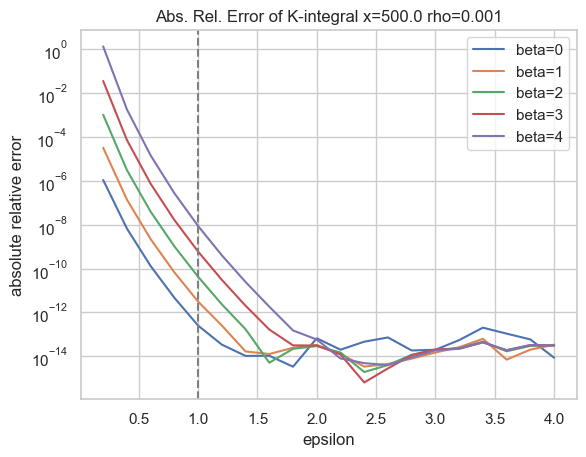

In [74]:
rho = 0.001
x = 500.

fig, ax = plt.subplots()
for beta in range(5):
    y1 = Wright_Series_MPMATH(rho, beta, x, steps=[2000], method="d")
    eps_list = np.linspace(0.2, 4, 20)
    prec = [
        rel_err(
            Wright_Integral(rho, beta, x, n_laguerre=50, n_legendre=50, eps=eps),
            y1,
        ) for eps in eps_list
    ]
    ax.plot(eps_list, np.abs(prec), label=f"{beta=}")
ax.axvline(x=1, color="grey", linestyle="dashed")
ax.set_xlabel("epsilon")
ax.set_xlabel("epsilon")
ax.set_ylabel("absolute relative error")
ax.set_yscale("log")
ax.legend()
ax.set_title(f"Abs. Rel. Error of K-integral {x=} {rho=}")

One can see that the larger $\beta$ the more beneficial it is to set $\epsilon$ larger than 1, e.g. $\epsilon = 2$.
For larger $\rho$, this starts earlier.

#### 2.4.3 Choice of epsilon: Diagnose impact on K and P at the same time

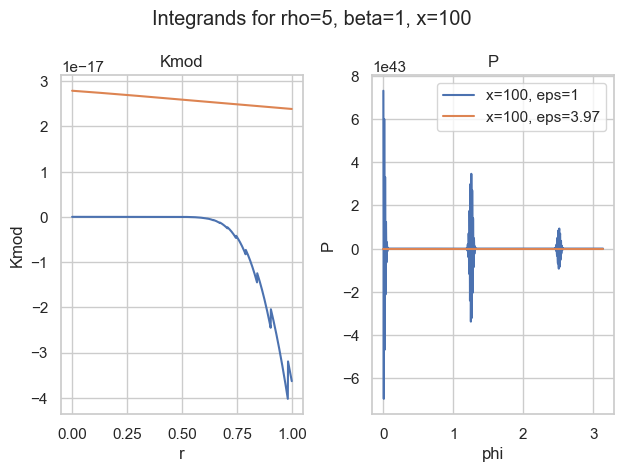

In [75]:
# look at special case
rho = 5 #0.001
beta = 1 #7
x = 100 #500.

fig, axes = plt.subplots(ncols=2, figsize=[6.4, 4.8])# (12, 6))

r = np.linspace(0, 1 + np.power(1e-6, 1./beta), 1_000)
phi = np.linspace(0, np.pi, 1_000)
        
# modified eps
eps = eps_select(rho, beta, x)   
    
axes[0].plot(r, Kmod(1, rho, beta, x, r), label=f"{x=}, eps={1}")
axes[0].plot(r, Kmod(eps, rho, beta, x, r), label=f"{x=}, eps={eps:4.2f}")
axes[0].set_xlabel("r")
axes[0].set_ylabel("Kmod")
axes[0].set_title("Kmod")
axes[1].plot(phi, np.power(eps, 1.-beta) * P(1, rho, beta, x, phi), label=f"{x=}, eps={1}")
axes[1].plot(phi, np.power(eps, 1.-beta) * P(eps, rho, beta, x, phi), label=f"{x=}, eps={eps:4.2f}")
axes[1].set_xlabel("phi")
axes[1].set_ylabel("P")
axes[1].set_title("P")
axes[1].legend()

fig.suptitle(f"Integrands for {rho=}, {beta=}, {x=}")
fig.tight_layout()
#fig.subplots_adjust()

#fig.suptitle(f"Determine good eps for Kmod and P")

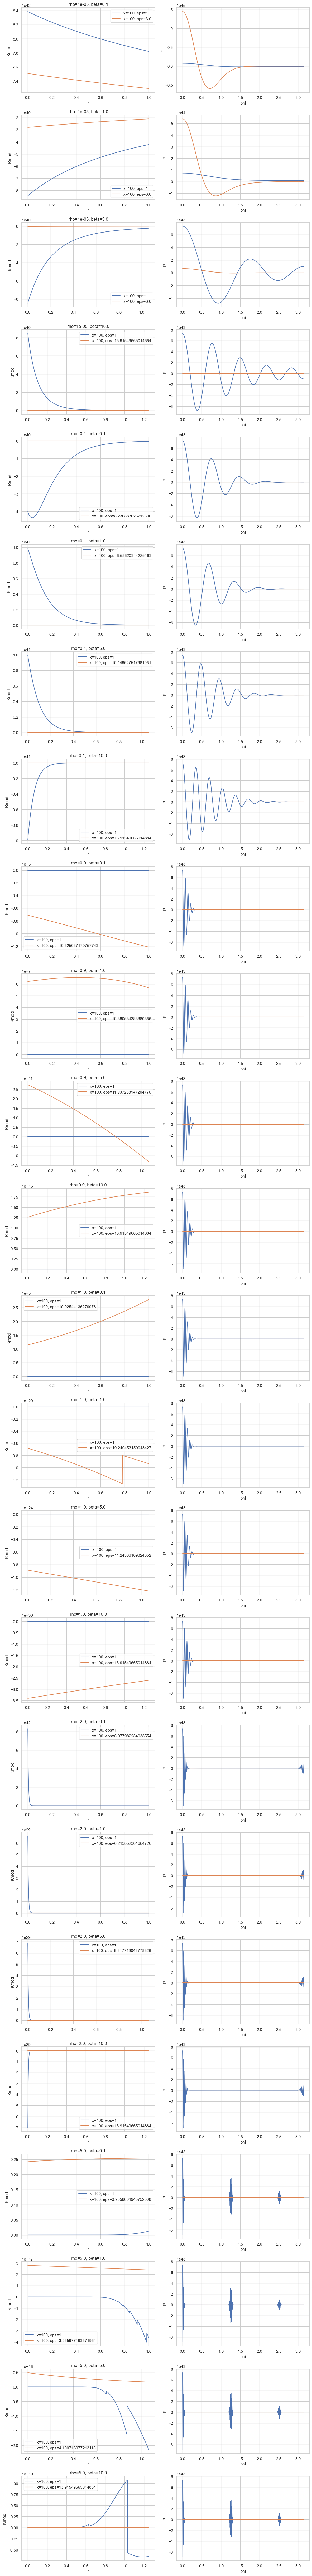

In [76]:
# Which epsilon ?

data_rho = np.array([1e-5, 0.1, 0.9, 1, 2, 5])
data_beta = np.array([0.1, 1, 5, 10])
grid = np.asarray(np.meshgrid(data_rho, data_beta)).T.reshape(-1, 2)

data_x = np.array([100])

fig, axes = plt.subplots(grid.shape[0], 2, figsize=(12, 4 * grid.shape[0] + 2))

for i in range(grid.shape[0]):
    rho, beta = grid[i, :]
    for x in data_x:
        eps = 1.
        r = np.linspace(0, 1 + np.power(1e-6, 1./beta), 1_000)
        y1 = Kmod(eps, rho, beta, x, r)
        phi = np.linspace(0, np.pi, 1_000)
        y2 = np.power(eps, 1.-beta) * P(eps, rho, beta, x, phi)
        
        # modified eps
        eps = eps_select(rho, beta, x)
        
        y3 = Kmod(eps, rho, beta, x, r)
        y4 = np.power(eps, 1.-beta) * P(eps, rho, beta, x, phi)
    
        axes[i, 0].plot(r, y1, label=f"x={x}, eps={1}")
        axes[i, 0].plot(r, y3, label=f"x={x}, eps={eps}")
        axes[i, 1].plot(phi, y2, label=f"rho={x}, eps={1}")
        axes[i, 1].plot(phi, y4, label=f"rho={x}, eps={eps}")
    axes[i, 0].set_xlabel("r")
    axes[i, 0].set_ylabel("Kmod")
    #axes[i, 0].set_yscale("log")
    axes[i, 0].legend()
    axes[i, 0].set_title(f"rho={rho}, beta={beta}")
    axes[i, 1].set_xlabel("phi")
    axes[i, 1].set_ylabel("P")

fig.tight_layout()
#fig.subplots_adjust()

#fig.suptitle(f"Determine good eps for Kmod and P")

In [77]:
# special case rho = 5
rho = 5.
beta = 1
z = 100
y1 = Wright_Series_MPMATH(rho, beta, z, steps=[1000], method="s")
y2 = Wright_Integral(rho, beta, z, n_laguerre=50, n_legendre=50)
rel_err(y2, y1)

-4.662082756725712e-14

In [78]:
# special case rho = 0
# This is a hard one for the integral!!!
rho = 0.
beta = 0.5
z = 1
y1 = np.exp(z)*ss.rgamma(beta)
y2 = Wright_Series_MPMATH(rho, beta, z, steps=[100])
y3 = Wright_Integral(rho, beta, z, n_laguerre=100, n_legendre=50)
y4 = Wright_Integral_quad(rho, beta, z)

rel_err(y2, y1), rel_err(y3, y1), rel_err(y4, y1)

(1.000858091883189e-16, -0.04905879076840681, -2.4323718107480263e-14)

In [79]:
# special case rho = 0
rho = 0.
beta = 1.5
z = 1
y1 = np.exp(z)*ss.rgamma(beta)
y2 = Wright_Series_MPMATH(rho, beta, z, steps=[1000])
y3 = Wright_Integral(rho, beta, z)
rel_err(y2, y1), rel_err(y3, y1)

(1.000858091883189e-16, -1.3899267489988721e-14)

In [80]:
# special case rho = 0, beta=1
rho = 0.
beta = 1
z = 1
y1 = np.exp(z)*ss.rgamma(beta)
y2 = Wright_Series_MPMATH(rho, beta, z, steps=[1000])
y3 = Wright_Integral(rho, beta, z)
rel_err(y2, y1), rel_err(y3, y1)

(5.318242047614969e-17, -2.9733574843683334e-14)

In [81]:
rho = -0.5
beta = 1.
z = 2
y1 = ss.erfc(-z/2.)
y2 = Wright_Series_MPMATH(rho, beta, z, steps=[1000])
y3 = Wright_Integral(rho, beta, z, n_laguerre=100, n_legendre=100)
rel_err(y2, y1), rel_err(y3, y1)

(4.679065537758338e-17, -0.03006494914660659)

In [82]:
rho = -0.5
beta = 0.99
z = 2.
Wright_Series_MPMATH(rho, beta, z), Wright_Integral(rho, beta, z)

(1.8013566827720609548, 0.7782455056728405)

Text(0.5, 1.0, 'Integrand K for rho=-0.5 x=2.0')

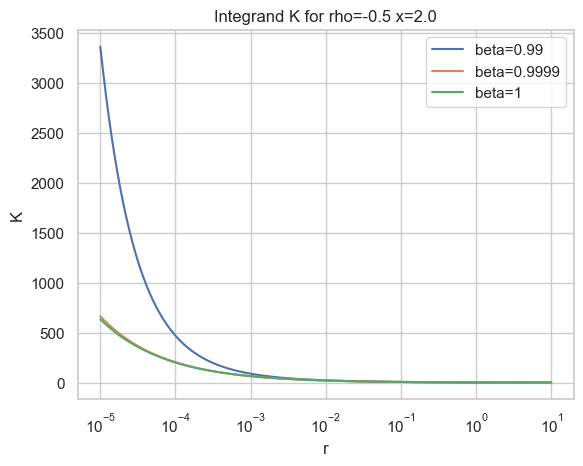

In [83]:
r = np.power(10, np.linspace(-5, 1, 10_000))
rho, x = -0.5, 2.
plt.plot(r, K(rho, 0.99, x, r), label="beta=0.99")
plt.plot(r, K(rho, 0.9999, x, r), label="beta=0.9999")
plt.plot(r, K(rho, 1.0, x, r), label="beta=1")
plt.legend()
plt.xscale("log")
plt.xlabel("r")
plt.ylabel("K")
plt.title(f"Integrand K for {rho=} {x=}")

Text(0.5, 1.0, 'Integrand K for rho=0.5 x=2.0')

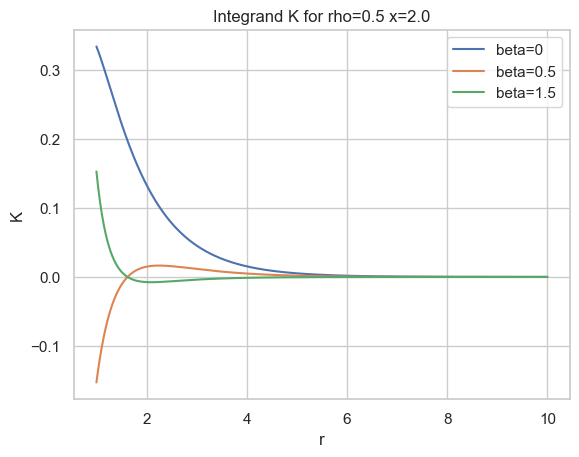

In [84]:
r = np.linspace(1, 10, 1_000)
rho, x = 0.5, 2.
plt.plot(r, K(rho, 0, x, r), label="beta=0")
plt.plot(r, K(rho, 0.5, x, r), label="beta=0.5")
plt.plot(r, K(rho, 1.5, x, r), label="beta=1.5")
plt.legend()
plt.xlabel("r")
plt.ylabel("K")
plt.title(f"Integrand K for {rho=} {x=}")

Text(0.5, 1.0, 'Integrand P for rho=0.5 x=2.0')

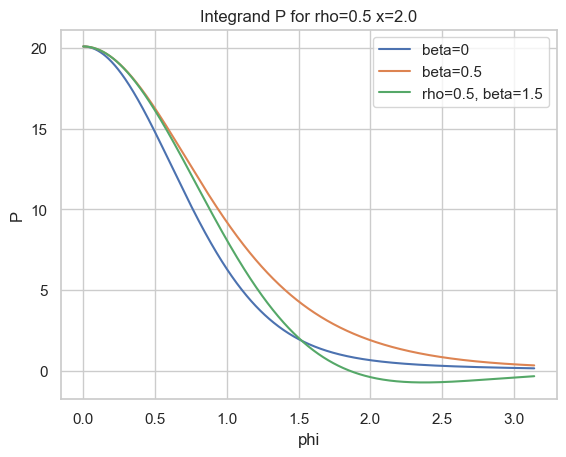

In [85]:
phi = np.linspace(0, np.pi, 1_000)
eps, rho, x = 1., 0.5, 2.
plt.plot(phi, P(eps, rho, 0, x, phi), label="beta=0")
plt.plot(phi, P(eps, rho, 0.5, x, phi), label="beta=0.5")
plt.plot(phi, P(eps, rho, 1.5, x, phi), label="rho=0.5, beta=1.5")
plt.legend()
plt.xlabel("phi")
plt.ylabel("P")
plt.title(f"Integrand P for {rho=} {x=}")

In [86]:
# special case rho=1 => Modified Bessel function of the first kind of real order 
# iv(v, z) = (1/2*z)**v * Phi(rho=1, beta=v+1, 1/4*z**2)
v = -0.5
x = 1.5
[np.power(0.5*x, v) * Wright_Series_MPMATH(1, 1+v, 1/4*x**2),
 np.power(0.5*x, v) * Wright_Integral(1, 1+v, 1/4*x**2),
 ss.iv(v, x)
]

[1.5325243293765750491, 1.5325243293765027, 1.532524329376576]

In [87]:
rho = 0.5
beta = 0.
x = 1.1
y1 = Wright_Series_MPMATH(rho, beta, x, steps=[100])
y2 = Wright_Integral(rho, beta, x)
rel_err(y2, y1)

-1.1283808942461977e-13

In [88]:
rho = 2.3
beta = 0.
x = 50.5
y1 = Wright_Series_MPMATH(rho, beta, x, steps=[1000])
y2 = Wright_Integral(rho, beta, x, n_laguerre=50, n_legendre=50, eps=3)
rel_err(y2, y1)

3.604634309597263e-14

In [89]:
rho = 0.1
beta = 2
x = 100
y1 = Wright_Series_MPMATH(rho, beta, x, steps=[100])
y2 = Wright_Integral(rho, beta, x, n_laguerre=50, n_legendre=50)
rel_err(y2, y1)

6.579880295004158e-05

In [90]:
rho = 1
beta = 0
x = 100
y1 = Wright_Series_MPMATH(rho, beta, x, steps=[100])
y2 = Wright_Integral(rho, beta, x, n_laguerre=50, n_legendre=50)
rel_err(y2, y1)

-1.5145713044772207e-14

Text(0.5, 0.98, 'K and P for rho=0.1, x=100.0, eps=8.24')

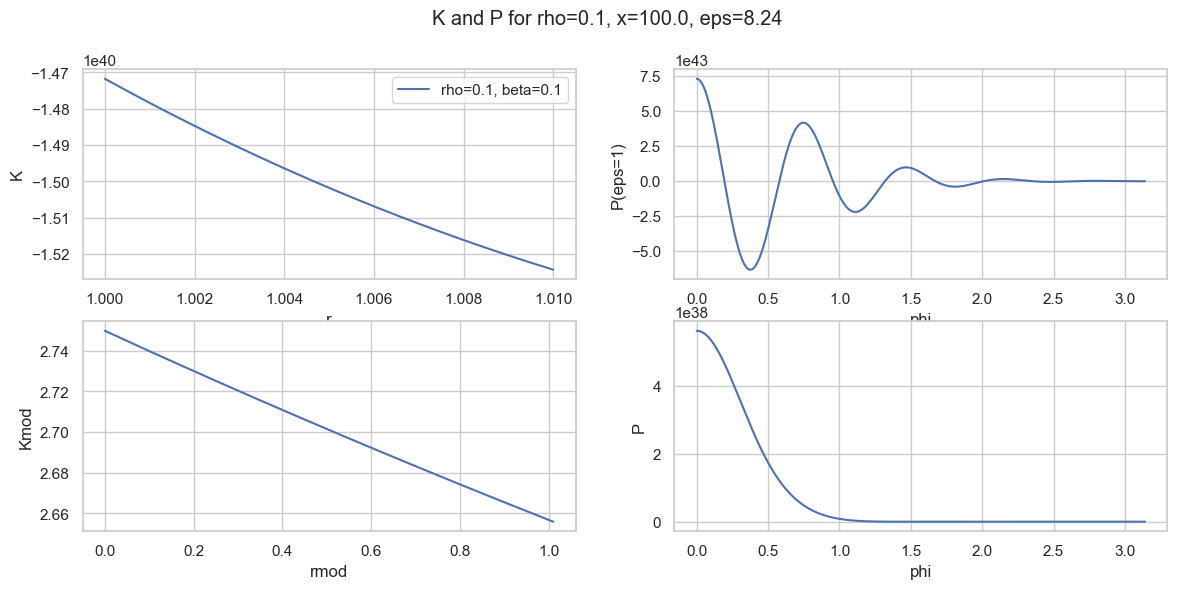

In [91]:
rho = 0.1
beta = 0.1
x = 100.

eps = eps_select(rho, beta, x)

r = np.linspace(1, 1.01, 1_000)
y1 = K(rho, beta, x, r)

r2 = np.linspace(0, 1.01, 1_000)
y2 = Kmod(eps, rho, beta, z, r2)

phi = np.linspace(0, np.pi, 1_000)
y3 = P(1, rho, beta, x, phi)
y4 = P(eps, rho, beta, x, phi)

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(14, 6))
ax1.plot(r, y1, label=f"rho={rho}, beta={beta}")
ax1.legend()
ax1.set(xlabel="r", ylabel="K")
ax3.plot(r2, y2, label=f"rho={rho}, beta={beta}")
ax3.set(xlabel="rmod", ylabel="Kmod")

ax2.plot(phi, y3, label=f"rho={rho}, beta={beta}")
ax2.set(xlabel="phi", ylabel="P(eps=1)")
ax4.plot(phi, y4, label=f"rho={rho}, beta={beta}")
ax4.set(xlabel="phi", ylabel="P")
fig.suptitle(f"K and P for {rho=}, {x=}, {eps=:.2f}")

In [92]:
rho, beta = 10, 10
x = np.array([1, 2, 10, 100, 500])
y1 = np.array([Wright_Series_MPMATH(rho, beta, z, nstep=[100]) for z in x])
y2 = np.array([Wright_Integral(rho, beta, z) for z in x])
y2/y1 - 1

array([-2.7046736093719152272e-14, -2.7265919421348358553e-14,
       -2.7328841263835144254e-14, -2.6922505159477153058e-14,
       -2.7148629075076161077e-14], dtype=object)

In [93]:
z = 2
y1 = Wright_Series_MPMATH(rho, beta, z, nstep=[1000])
y2 = Wright_Integral(rho, beta, z, n_legendre=50)

eps = 2 * np.power(z, 1/rho)
K_int = fixed_laguerre(lambda r: Kmod(eps, rho, beta, z, r), n=50)
P_int = integrate.fixed_quad(lambda phi: P(eps, rho, beta, z, phi), 0, np.pi, n=50)
res = 1./np.pi * (K_int[0] + np.power(eps, 1.-beta) * P_int[0])
rel_err(y2, y1), rel_err(res, y1)

(-2.7265919537818152e-14, -4.012949772784677e-12)

Text(0.5, 0.98, 'K and P for rho=10, x=1, eps=13.92')

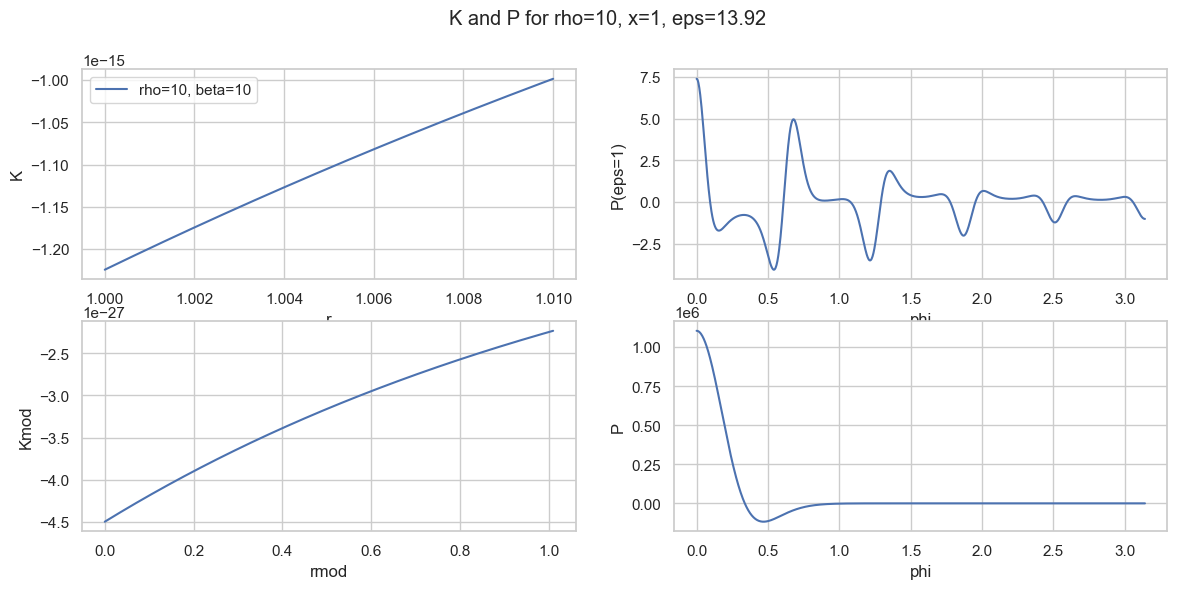

In [94]:
rho = 10
beta = 10
x = 1

eps = eps_select(rho, beta, x)

r = np.linspace(1, 1.01, 1_000)
y1 = K(rho, beta, x, r)

r2 = np.linspace(0, 1.01, 1_000)
y2 = Kmod(eps, rho, beta, z, r2)

phi = np.linspace(0, np.pi, 1_000)
y3 = P(1, rho, beta, x, phi)
y4 = P(eps, rho, beta, x, phi)

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(14, 6))
ax1.plot(r, y1, label=f"rho={rho}, beta={beta}")
ax1.legend()
ax1.set(xlabel="r", ylabel="K")
ax3.plot(r2, y2, label=f"rho={rho}, beta={beta}")
ax3.set(xlabel="rmod", ylabel="Kmod")

ax2.plot(phi, y3, label=f"rho={rho}, beta={beta}")
ax2.set(xlabel="phi", ylabel="P(eps=1)")
ax4.plot(phi, y4, label=f"rho={rho}, beta={beta}")
ax4.set(xlabel="phi", ylabel="P")
fig.suptitle(f"K and P for {rho=}, {x=}, {eps=:.2f}")

In [95]:
rho = 0.1
beta = 10.
x = 2.1
y1 = Wright_Series_MPMATH(rho, beta, x, steps=[100])
y2 = Wright_Integral(rho, beta, x, n_laguerre=50, n_legendre=50)
rel_err(y2, y1)

-2.5466733811592013e-14

Text(0.5, 0.98, 'K and P for rho=0.1, x=2.1, eps=13.92')

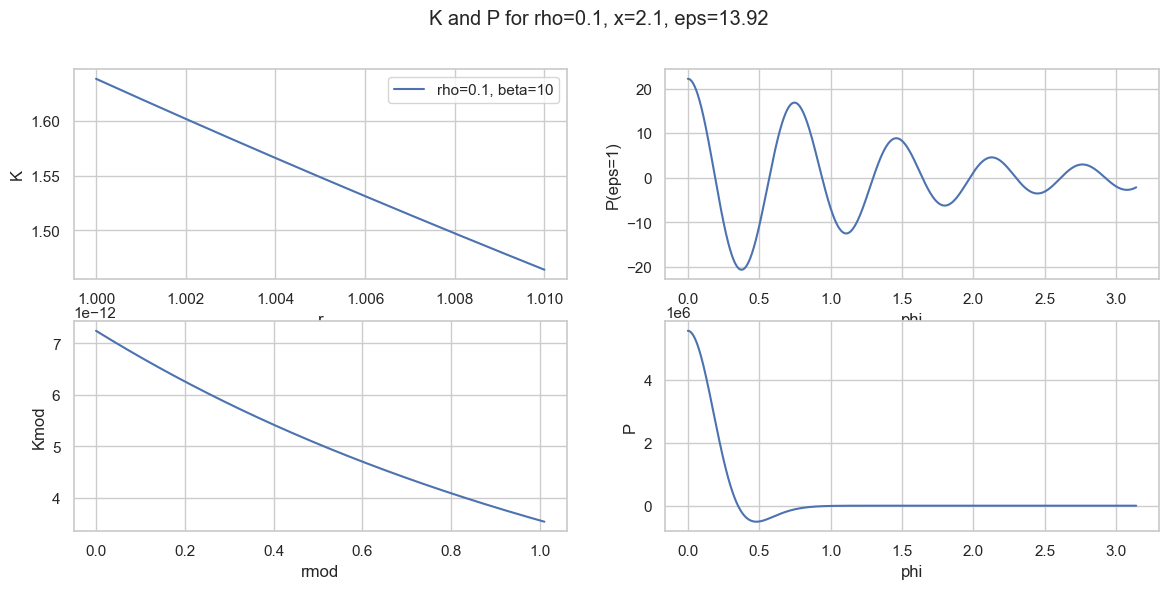

In [96]:
rho = 0.1
beta = 10
x = 2.1

eps = eps_select(rho, beta, x)

r = np.linspace(1, 1.01, 1_000)
y1 = K(rho, beta, x, r)

r2 = np.linspace(0, 1.01, 1_000)
y2 = Kmod(eps, rho, beta, z, r2)

phi = np.linspace(0, np.pi, 1_000)
y3 = P(1, rho, beta, x, phi)
y4 = P(eps, rho, beta, x, phi)

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(14, 6))
ax1.plot(r, y1, label=f"rho={rho}, beta={beta}")
ax1.legend()
ax1.set(xlabel="r", ylabel="K")
ax3.plot(r2, y2, label=f"rho={rho}, beta={beta}")
ax3.set(xlabel="rmod", ylabel="Kmod")

ax2.plot(phi, y3, label=f"rho={rho}, beta={beta}")
ax2.set(xlabel="phi", ylabel="P(eps=1)")
ax4.plot(phi, y4, label=f"rho={rho}, beta={beta}")
ax4.set(xlabel="phi", ylabel="P")
fig.suptitle(f"K and P for {rho=}, {x=}, {eps=:.2f}")

### 2.6 Taylor Series for large rho and large z<a id="series_rho_large"></a>
[back to TOC](#toc)

For $\rho \geq 1$ (and $\rho k > \beta$) we can use a [Stirling approximation](https://en.wikipedia.org/wiki/Stirling%27s_approximation) to find the largest term in $k$ from the series representation:
$$k_{max} = \operatorname{argmax}_k \frac{z^k}{k! \Gamma(\rho k + \beta)}$$
The result is the approximation
$$k_{max} = (z \rho^{-\rho})^{\frac{1}{\rho+1}}$$


See:
- Dunn, P.K., Smyth, G.K. Series evaluation of Tweedie exponential dispersion model densities. Stat Comput 15, 267–280 (2005). https://doi.org/10.1007/s11222-005-4070-y

In [97]:
def Wright_large_rho(rho, beta, z, n=20):
    k_max = int(np.power(np.power(1.*rho, -rho) * z, 1/(1+rho)))
    k_start = max(0, k_max - n//2)
    res = 0
    lnz = np.log(z)
    def log_term(k):
        """Logarithm of a term in the Taylor Series as function of k."""
        return k * lnz - ss.loggamma(k + 1) - ss.loggamma(rho * k + beta)
    # Prevent early overflow
    max_exponent = max(0, log_term(k_max));
    for k in range(k_start, k_start + n):
        exponent = log_term(k) - max_exponent
        res += np.exp(exponent)
    return np.exp(np.log(res) + max_exponent)

In [98]:
rho = 10
beta = 10.3
z = 1e20
y1 = Wright_Series_MPMATH(rho, beta, z, steps=[1_000], method="r")
y2 = Wright_large_rho(rho, beta, z, n=1000)
y3 = Wright_Series(rho, beta, z, nstop=5)
y4 = Wright_Asymptotic(rho, beta, z)
print(f"exact = {y1}")
print(f"relative error Wright_large_rho      = {rel_err(y2, y1):.4e}")
print(f"relative error Wright_Series 5 terms = {rel_err(y3, y1):.4e}")
print(f"relative error Wright_Asymptotic     = {rel_err(y4, y1):.4e}")

exact = 13105081926519195809
relative error Wright_large_rho      = 7.8438e-14
relative error Wright_Series 5 terms = -9.9984e-01
relative error Wright_Asymptotic     = -3.2677e-07


In [99]:
rho = 10
beta = 100
z = 1e20
order = int(np.fmin(np.log10(z) - 5 + beta/10, 30))
print(f"order={order}")
y1 = Wright_Series_MPMATH(rho, beta, z, steps=[1_000], method="r")
y2 = Wright_large_rho(rho, beta, z, n=order)
y1, rel_err(y2, y1)

order=25


(1.8571851438779072711e-156, 6.364461891289432e-15)

In [100]:
# Hardest is low rho, start with rho = 5
rho = 5
beta = 0
z = 1e10
y1 = Wright_Series_MPMATH(rho, beta, z, steps=[1_000], method="r")
y2 = Wright_large_rho(rho, beta, z, n=20)
y3 = Wright_Asymptotic(rho, beta, z)
rel_err(y2, y1), rel_err(y3, y1)

(-1.1718975036433512e-09, 2.3225026291803543e-11)

In [101]:
# Hardest is low rho, start with rho = 5
rho = 10.
beta = 0
z = 1e20
y1 = Wright_Series_MPMATH(rho, beta, z, steps=[1_000], method="r")
y2 = Wright_large_rho(rho, beta, z, n=20)
y3 = Wright_Asymptotic(rho, beta, z)
rel_err(y2, y1), rel_err(y3, y1)

(6.213096651267014e-14, 2.312985341451659e-07)

In [102]:
%%time
# Grid search for region of convergence, hardest is low rho, start with rho=4
rho = np.array([4, 5, 6, 10], dtype=float)
beta = np.array([0, 5], dtype=float)
x = np.power(10., range(1, 16))
n = np.arange(3, 21) * 2
df = pd.DataFrame(
    np.asarray(
        np.meshgrid(rho, beta, x, n)
    ).T.reshape(-1, 4),
    columns=["rho", "beta", "x", "n"],
)

df["n"] = df["n"].astype("int")
df["Wright_large_rho"] = 0.
df["MPMATH"] = 0.

for index, row in df.iterrows():
    # Note: itterrows gives back a copy not a view
    # row[..] = does not work
    df.at[index , "Wright_large_rho"] = Wright_large_rho(
        row["rho"], row["beta"], row["x"], n=int(row["n"])
    )
    df.at[index , "MPMATH"] = float(
        Wright_Series_MPMATH(
            row["rho"], row["beta"], row["x"], dps=30, steps=[200], maxterms=1000, method="s"
        )
    )

df["rel_error"] = df["Wright_large_rho"]/df["MPMATH"] - 1

/var/folders/1c/ynyjslg54654183kt57yfsdw0000gn/T/ipykernel_26528/94820593.py:14: RuntimeWarning: overflow encountered in exp
  return np.exp(np.log(res) + max_exponent)


CPU times: user 1min 2s, sys: 306 ms, total: 1min 2s
Wall time: 1min 2s


In [103]:
with pd.option_context("display.max_rows", 150, "display.float_format", "{:.4g}".format):
    display(df.query("rho >= 10 and abs(rel_error) > 1e-14").sort_values(by=["rho", "beta", "x"]))

rho  beta     x  n  Wright_large_rho    MPMATH  rel_error
102   10     0 1e+13  6         4.575e+08 4.575e+08 -2.232e-14
110   10     0 1e+14  6         6.043e+10 6.043e+10 -1.657e-10
118   10     0 1e+15  6         2.502e+13 2.502e+13 -4.003e-07
111   10     5 1e+14  6              9772      9772 -1.119e-12
119   10     5 1e+15  6         1.398e+06 1.398e+06 -7.832e-09

In [104]:
with pd.option_context("display.max_rows", 150, "display.float_format", "{:.4g}".format):
    display(df.query("5 <= rho < 10 and abs(rel_error) > 1e-11").sort_values(by=["rho", "beta", "x"]))

rho  beta     x   n  Wright_large_rho    MPMATH  rel_error
34      5     0 1e+05   6         1.989e+04 1.989e+04   -7.9e-09
42      5     0 1e+06   6         3.687e+06 3.687e+06 -4.278e-05
162     5     0 1e+06   8         3.687e+06 3.687e+06   -3.3e-10
50      5     0 1e+07   6         6.818e+09 6.982e+09   -0.02348
170     5     0 1e+07   8         6.982e+09 6.982e+09 -1.756e-05
...   ...   ...   ...  ..               ...       ...        ...
1077    6     5 1e+15  22         9.441e+79 9.441e+79 -1.031e-06
1197    6     5 1e+15  24         9.441e+79 9.441e+79 -1.074e-07
1317    6     5 1e+15  26         9.441e+79 9.441e+79 -9.504e-09
1437    6     5 1e+15  28         9.441e+79 9.441e+79 -7.154e-10
1557    6     5 1e+15  30         9.441e+79 9.441e+79 -4.605e-11

[310 rows x 7 columns]

In [105]:
with pd.option_context("display.max_rows", 150, "display.float_format", "{:.4g}".format):
    display(df.query("abs(rel_error) <= 1e-12").groupby(["rho", "beta", "x"]).agg({"n": "min"}))

n
rho beta x        
4   0    10      6
         100     6
         1000    8
         1e+04  10
         1e+05  12
         1e+06  16
         1e+07  20
         1e+08  28
         1e+09  36
    5    10      6
         100     6
         1000    6
         1e+04   8
         1e+05  10
         1e+06  14
         1e+07  20
         1e+08  26
         1e+09  34
5   0    10      6
         100     6
         1000    6
         1e+04   6
         1e+05   8
         1e+06  10
         1e+07  12
         1e+08  16
         1e+09  20
         1e+10  24
         1e+11  30
         1e+12  34
         1e+13  40
    5    10      6
         100     6
         1000    6
         1e+04   6
         1e+05   8
         1e+06   8
         1e+07  12
         1e+08  14
         1e+09  18
         1e+10  24
         1e+11  28
         1e+12  32
         1e+13  40
6   0    10      6
         100     6
         1000    6
         1e+04   6
         1e+05   6
         1e+06   8
         1e+07   8
         1e+08  10
         1e+09  12
         1e+10  14
         1e+11  18
         1e+12  22
         1e+13  26
         1e+14  30
         1e+15  36
    5    10      6
         100     6
         1000    6
         1e+04   6
         1e+05   6
         1e+06   6
         1e+07   8
         1e+08  10
         1e+09  12
         1e+10  14
         1e+11  18
         1e+12  20
         1e+13  24
         1e+14  28
         1e+15  34
10  0    10      6
         100     6
         1000    6
         1e+04   6
         1e+05   6
         1e+06   6
         1e+07   6
         1e+08   6
         1e+09   6
         1e+10   6
         1e+11   6
         1e+12   6
         1e+13   6
         1e+14   8
         1e+15   8
    5    10      6
         100     6
         1000    6
         1e+04   6
         1e+05   6
         1e+06   6
         1e+07   6
         1e+08   6
         1e+09   6
         1e+10   6
         1e+11   6
         1e+12   6
         1e+13   6
         1e+14   8
         1e+15   8

### 2.7 Check Precision on Data Grid <a id="grid"></a>
[back to TOC](#toc)

In this section, we investigate which way of computing Wright's function is the best for which parameter space in $(\rho, \beta, z)$.

#### 2.7.1 Compute Grid

In [106]:
# To avoid context manager each time.
pd.set_option("display.float_format", "{:.4g}".format)

In [107]:
rho = 1.8
beta = 100
z = 1e5
y1 = float(Wright_Series_MPMATH(rho, beta, z, dps=50, steps=[1000], maxterms=2000, method="s"))
y2 = Wright_Series(rho, beta, z, nstart=0, nstop=40)
y3 = Wright_Asymptotic(rho, beta, z, order=8)
y4 = Wright_Integral(rho, beta, z)
y5 = Wright_small_rho(rho, beta, z)
y6 = Wright_large_rho(rho, beta, z)

{
    "Phi":y1,
    "Z": (rho*z)**(1/(1+rho)),
    "Z_limit": 14 + beta**2 / (2 * (1 + rho)),
    "eps_select": eps_select(rho, beta, z),
    "precision Series": rel_err(y2, y1),
    "precision Asympt": rel_err(y3, y1),
    "precision Integral": rel_err(y4, y1),
    "precision small rho": rel_err(y5, y1),
    "precision large rho": rel_err(y6, y1),
}

/var/folders/1c/ynyjslg54654183kt57yfsdw0000gn/T/ipykernel_26528/3132822154.py:64: RuntimeWarning: overflow encountered in exp
  res *= np.exp(z) * ss.rgamma(beta)


{'Phi': 2.7844296176636242e-148,
 'Z': 75.31527003270547,
 'Z_limit': 1799.7142857142858,
 'eps_select': 114.76157527896652,
 'precision Series': -4.588940114077887e-10,
 'precision Asympt': 1.1640425329444341e+17,
 'precision Integral': -1.7853192337388546e-10,
 'precision small rho': inf,
 'precision large rho': -0.9999619112654368}

In [108]:
eps_select(rho, beta, z)

114.76157527896652

In [109]:
rho = 1
beta = 10
z = 1000
y1 = float(Wright_Series_MPMATH(rho, beta, z, dps=50, steps=[1000], maxterms=2000, method="s"))
y2 = Wright_Series(rho, beta, z, nstart=0, nstop=30)
y3 = Wright_Asymptotic(rho, beta, z, order=7)
y4 = Wright_Integral(rho, beta, z, eps=30)
y5 = Wright_small_rho(rho, beta, z)
y6 = Wright_large_rho(rho, beta, z)

{
    "Phi":y1,
    "Z": (rho*z)**(1/(1+rho)),
    "Z_limit": 14 + beta**2 / (2 * (1 + rho)),
    "eps_select": eps_select(rho, beta, z),
    "precision Series": rel_err(y2, y1),
    "precision Asympt": rel_err(y3, y1),
    "precision Integral": rel_err(y4, y1),
    "precision small rho": rel_err(y5, y1),
    "precision large rho": rel_err(y6, y1),
}

/var/folders/1c/ynyjslg54654183kt57yfsdw0000gn/T/ipykernel_26528/3132822154.py:64: RuntimeWarning: overflow encountered in exp
  res *= np.exp(z) * ss.rgamma(beta)


{'Phi': 2446819552254.583,
 'Z': 31.622776601683793,
 'Z_limit': 39.0,
 'eps_select': 34.11353940392128,
 'precision Series': -0.27494552817797435,
 'precision Asympt': -6.897911399665725e-08,
 'precision Integral': -9.459026608101868e-14,
 'precision small rho': inf,
 'precision large rho': -0.04148817263384268}

In [110]:
rho = 1
beta = 100
z = 100_000
y1 = float(Wright_Series_MPMATH(rho, beta, z, dps=50, steps=[1000], maxterms=2000, method="s"))
y2 = Wright_Series(rho, beta, z, nstart=0, nstop=30)
y3 = Wright_Asymptotic(rho, beta, z, order=7)
y4 = Wright_Integral(rho, beta, z, eps=30)
y5 = Wright_small_rho(rho, beta, z)
y6 = Wright_large_rho(rho, beta, z)

{
    "Phi":y1,
    "Z": (rho*z)**(1/(1+rho)),
    "Z_limit": 14 + beta**2 / (2 * (1 + rho)),
    "eps_select": eps_select(rho, beta, z),
    "precision Series": rel_err(y2, y1),
    "precision Asympt": rel_err(y3, y1),
    "precision Integral": rel_err(y4, y1),
    "precision small rho": rel_err(y5, y1),
    "precision large rho": rel_err(y6, y1),
}

/var/folders/1c/ynyjslg54654183kt57yfsdw0000gn/T/ipykernel_26528/2827300597.py:24: RuntimeWarning: overflow encountered in exp
  np.exp(eps*np.cos(phi) + x * eps_rho * np.cos(rho*phi))
/Users/lorentzen/github/python3_general/lib/python3.11/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/var/folders/1c/ynyjslg54654183kt57yfsdw0000gn/T/ipykernel_26528/3132822154.py:64: RuntimeWarning: overflow encountered in exp
  res *= np.exp(z) * ss.rgamma(beta)


{'Phi': 1.0269334596230763e+22,
 'Z': 316.22776601683796,
 'Z_limit': 2514.0,
 'eps_select': 150.0,
 'precision Series': -1.0,
 'precision Asympt': -382299.31505776744,
 'precision Integral': nan,
 'precision small rho': inf,
 'precision large rho': -0.9971996509519786}

In [111]:
eps = 1e-6
data_rho = np.array([eps, 0.1, 0.5, 1-eps, 1, 2, 5, 10, 100])
data_beta = np.array([eps, 0.5, 1-eps, 1, 2, 5, 10, 100])
data_z = np.array([eps, 0.1, 0.5, 1-eps, 1, 2, 5, 10, 100, 500])

grid = np.asarray(np.meshgrid(data_rho, data_beta, data_z)).T.reshape(-1, 3)

# add manually
grid = np.concatenate(
    (
        grid,
        [
            [2, 1, 1000],
            [5, 1, 1000],
            [10, 1, 1000],
        ]
    )
)
grid.shape

(723, 3)

In [112]:
%%time
#rgrid_MPMATH = [Wright_Series_MPMATH(rho, beta, z, dps=40, steps=[200], maxterms=1000, method="s") \
#                for rho, beta, z in grid]
rgrid_MPMATH = []
for i in range(grid.shape[0]):
    rho, beta, z = grid[i, :]
    if z >= 50 and rho < 10:
        steps = 1000
        maxterms = 2000
    else:
        steps = 100
        maxterms = 1000

    rgrid_MPMATH.append(
        Wright_Series_MPMATH(
            rho, beta, z, dps=40, steps=[steps], maxterms=maxterms, method="s")
    )

rgrid_MPMATH = np.asarray(rgrid_MPMATH)

CPU times: user 46 s, sys: 507 ms, total: 46.5 s
Wall time: 46.6 s


In [113]:
%%time
rgrid_Series18 = np.asarray([Wright_Series(rho, beta, z, nstart=0, nstop=18, tol=0) for rho, beta, z in grid])
rgrid_Series20 = np.asarray([Wright_Series(rho, beta, z, nstart=0, nstop=20, tol=0) for rho, beta, z in grid])
rgrid_Asymptotic = np.asarray([Wright_Asymptotic(rho, beta, z, order=6) for rho, beta, z in grid])
rgrid_Integral = np.asarray([Wright_Integral(rho, beta, z) for rho, beta, z in grid])
rgrid_small_rho = np.asarray([Wright_small_rho(rho, beta, z) for rho, beta, z in grid])
rgrid_large_rho = np.asarray([Wright_large_rho(rho, beta, z) for rho, beta, z in grid])

CPU times: user 244 ms, sys: 2.41 ms, total: 246 ms
Wall time: 246 ms


/var/folders/1c/ynyjslg54654183kt57yfsdw0000gn/T/ipykernel_26528/1293522329.py:175: RuntimeWarning: overflow encountered in exp
  res *= np.exp(logZ * (0.5 - beta) + (1+rho)/rho * Z)
/var/folders/1c/ynyjslg54654183kt57yfsdw0000gn/T/ipykernel_26528/1293522329.py:175: RuntimeWarning: overflow encountered in scalar multiply
  res *= np.exp(logZ * (0.5 - beta) + (1+rho)/rho * Z)
/var/folders/1c/ynyjslg54654183kt57yfsdw0000gn/T/ipykernel_26528/3132822154.py:64: RuntimeWarning: overflow encountered in exp
  res *= np.exp(z) * ss.rgamma(beta)


In [114]:
df = pd.DataFrame(grid, columns=["rho", "beta", "z"])

df["MPMATH"] = rgrid_MPMATH
df["Series18"] = rgrid_Series18
df["Series20"] = rgrid_Series20
df["Asympt"] = rgrid_Asymptotic
df["Integral"] = rgrid_Integral
df["small_rho"] = rgrid_small_rho
df["large_rho"] = rgrid_large_rho

df["prec_Series18"]  = (df["Series18"]  / df["MPMATH"] - 1).astype(float).abs()
df["prec_Series20"]  = (df["Series20"]  / df["MPMATH"] - 1).astype(float).abs()
df["prec_Asympt"]    = (df["Asympt"]    / df["MPMATH"] - 1).astype(float).abs()
df["prec_Integral"]  = (df["Integral"]  / df["MPMATH"] - 1).astype(float).abs()
df["prec_small_rho"] = (df["small_rho"] / df["MPMATH"] - 1).astype(float).abs()
df["prec_large_rho"] = (df["large_rho"] / df["MPMATH"] - 1).astype(float).abs()

/Users/lorentzen/github/python3_general/lib/python3.11/site-packages/pandas/core/dtypes/astype.py:134: RuntimeWarning: overflow encountered in cast
  return arr.astype(dtype, copy=True)


#### 2.7.2 Taylor Series

In [115]:
# worst precision of series for z <= 1
idx = df.loc[(df["z"] <= 1), "prec_Series18"].idxmax()
display(df.iloc[idx])

rho                                                        1e-06
beta                                                         100
z                                                              1
MPMATH            2.912653546540608349972994089760195499317e-156
Series18                                              2.913e-156
Series20                                              2.913e-156
Asympt                                                       inf
Integral                                              2.913e-156
small_rho                                             2.913e-156
large_rho                                             2.913e-156
prec_Series18                                          4.447e-14
prec_Series20                                          4.447e-14
prec_Asympt                                                  inf
prec_Integral                                          6.981e-13
prec_small_rho                                         1.298e-15
prec_large_rho           

In [116]:
rho = 1e-5
beta = 100
z = 1

y1 = Wright_Series_MPMATH(rho, beta, z, steps=[100])
y2 = Wright_Series(rho, beta, z, nstart=0, nstop=18, tol=0)
y3 = Wright_small_rho(rho, beta, z)
rel_err(y2, y1), rel_err(y3, y1)

(1.2633667372726404e-14, 8.228792771515071e-14)

In [117]:
# worst precision of series for z <= 1 and rho > 1e-6
idx = df.loc[(df["z"] <= 1) & (df["rho"] > 1e-6), "prec_Series18"].idxmax()
df.iloc[idx]

rho                                                          0.1
beta                                                         100
z                                                              1
MPMATH            2.014338509398109100293351206148654413321e-156
Series18                                              2.014e-156
Series20                                              2.014e-156
Asympt                                                1.639e+115
Integral                                              2.014e-156
small_rho                                             2.189e-156
large_rho                                             2.014e-156
prec_Series18                                          3.804e-14
prec_Series20                                          3.804e-14
prec_Asympt                                           8.135e+270
prec_Integral                                          6.902e-13
prec_small_rho                                           0.08664
prec_large_rho           

In [118]:
# worst precision of series for z <= 2
idx = df.loc[(df["z"] <= 2), "prec_Series20"].idxmax()
df.iloc[idx]

rho                                                        1e-06
beta                                                       1e-06
z                                                              2
MPMATH            0.00002216721521243239310329838655352902434539
Series18                                               2.217e-05
Series20                                               2.217e-05
Asympt                                                 4.541e+27
Integral                                               2.217e-05
small_rho                                              2.217e-05
large_rho                                              2.217e-05
prec_Series18                                          3.944e-11
prec_Series20                                          4.534e-13
prec_Asympt                                            2.049e+32
prec_Integral                                          3.117e-08
prec_small_rho                                         7.157e-17
prec_large_rho           

In [119]:
rho = 1e-6
beta = 1e-6
z = 2

y1 = Wright_Series_MPMATH(rho, beta, z, steps=[100])
y2 = Wright_Series(rho, beta, z, nstart=0, nstop=20, tol=0)
y3 = Wright_small_rho(rho, beta, z)
rel_err(y2, y1), rel_err(y3, y1)

(-4.5340767434563163e-13, -7.157461809498245e-17)

In [120]:
# worst precision of series for z <= 5 & rho >= 1
idx = df.loc[(df["z"] <= 5) & (df["rho"] >= 1) , "prec_Series20"].idxmax()
df.iloc[idx]

rho                                                            1
beta                                                         100
z                                                              5
MPMATH            1.126433863380004396007515798109053161921e-156
Series18                                              1.126e-156
Series20                                              1.126e-156
Asympt                                                  9.87e-19
Integral                                              1.126e-156
small_rho                                             4.696e-152
large_rho                                             1.126e-156
prec_Series18                                          2.072e-15
prec_Series20                                          2.072e-15
prec_Asympt                                           8.762e+137
prec_Integral                                          6.843e-13
prec_small_rho                                         4.168e+04
prec_large_rho           

#### 2.7.3 Series small rho

In [121]:
# worst precision of small rho series for rho <= 1e-3 and z <= 100
idx = df.loc[(df["rho"] <= 1e-3) & (df["z"] <= 100), "prec_small_rho"].idxmax()
df.iloc[idx]

rho                                                        1e-06
beta                                                         100
z                                                            100
MPMATH            2.879020475358926022697194662161724289679e-113
Series18                                              3.621e-137
Series20                                              1.084e-135
Asympt                                                       inf
Integral                                              2.879e-113
small_rho                                             2.879e-113
large_rho                                             1.967e-113
prec_Series18                                                  1
prec_Series20                                                  1
prec_Asympt                                                  inf
prec_Integral                                          6.776e-13
prec_small_rho                                          1.67e-11
prec_large_rho           

#### 2.7.4 Series large rho

In [122]:
# worst precision of large rho series for rho >= 1
idx = df.loc[(df["rho"] >= 1), "prec_large_rho"].idxmax()
df.iloc[idx]

rho                                                            1
beta                                                         100
z                                                            500
MPMATH            1.415608181830990498307985973573740034485e-154
Series18                                              1.416e-154
Series20                                              1.416e-154
Asympt                                                8.981e-107
Integral                                              1.416e-154
small_rho                                              3.981e+67
large_rho                                             4.323e-157
prec_Series18                                          1.358e-06
prec_Series20                                          6.178e-08
prec_Asympt                                            6.344e+47
prec_Integral                                          2.092e-13
prec_small_rho                                        2.812e+221
prec_large_rho           

In [123]:
# worst precision of large rho series for rho >= 5
idx = df.loc[(df["rho"] >= 5), "prec_large_rho"].idxmax()
df.iloc[idx]

rho                                                            5
beta                                                         100
z                                                            100
MPMATH            1.071510297835131722377427434418195861305e-156
Series18                                              1.072e-156
Series20                                              1.072e-156
Asympt                                                 2.028e-33
Integral                                              1.072e-156
small_rho                                             7.685e-107
large_rho                                             1.072e-156
prec_Series18                                          1.279e-15
prec_Series20                                          1.279e-15
prec_Asympt                                           1.893e+123
prec_Integral                                          6.951e-13
prec_small_rho                                         7.172e+49
prec_large_rho           

In [124]:
rho = 5
beta = 1
z = 1e9
print("Z = {}".format(np.power(rho*z, 1/(1+rho))))
y1 = Wright_Series_MPMATH(rho, beta, z, steps=[1000])
print(f"Phi = {y1}")
y2 = Wright_large_rho(rho, beta, z)
y3 = Wright_Asymptotic(rho, beta, z)
y4 = Wright_Integral(rho, beta, z)
rel_err(y2, y1), rel_err(y3, y1), rel_err(y4, y1)

Z = 41.351855420001364
Phi = 89731607525854102066


(-7.674999021961908e-15, 2.0591267362145844e-10, 2.1401427155383185e-11)

In [125]:
rho = 10
beta = 1
z = 1e20

y1 = Wright_Series_MPMATH(rho, beta, z, steps=[1000])
y2 = Wright_large_rho(rho, beta, z)
y3 = Wright_Asymptotic(rho, beta, z)
y4 = Wright_Integral(rho, beta, z)
y1, rel_err(y2, y1), rel_err(y3, y1), rel_err(y4, y1)

(7.4576280919632674035e+36,
 3.204609223401788e-15,
 9.512886194000787e-07,
 -0.015169941356527)

For $\rho \geq 10$ the large-rho-series is even better than the asymptotic series.

#### 2.7.5 Asymptotic Series

In [126]:
# worst precision of asymptotic for z >= 100
idx = df.loc[(df["z"] >= 100), "prec_Asympt"].idxmax()
df.iloc[idx]

rho                                                        1e-06
beta                                                         100
z                                                            100
MPMATH            2.879020475358926022697194662161724289679e-113
Series18                                              3.621e-137
Series20                                              1.084e-135
Asympt                                                       inf
Integral                                              2.879e-113
small_rho                                             2.879e-113
large_rho                                             1.967e-113
prec_Series18                                                  1
prec_Series20                                                  1
prec_Asympt                                                  inf
prec_Integral                                          6.776e-13
prec_small_rho                                          1.67e-11
prec_large_rho           

In [127]:
# worst precision of asymptotic for z >= 100 and 0.1 <= rho <= 5
idx = df.loc[(df["z"] >= 500) & (df["rho"] >= 0.1) & (df["rho"] <= 5), "prec_Asympt"].idxmax()
df.iloc[idx]

rho                                                            5
beta                                                         100
z                                                            500
MPMATH            1.071510336673791611741081962632298914999e-156
Series18                                              1.072e-156
Series20                                              1.072e-156
Asympt                                                 2.915e-45
Integral                                              1.072e-156
small_rho                                              9.959e+68
large_rho                                             1.072e-156
prec_Series18                                          1.283e-15
prec_Series20                                          1.283e-15
prec_Asympt                                           2.721e+111
prec_Integral                                          6.894e-13
prec_small_rho                                        9.294e+224
prec_large_rho           

In [128]:
rho = 5
beta = 100
z = 500
print("Z = {}".format(np.power(rho*z, 1/(1+rho))))

Z = 3.6840314986403864


In [129]:
# worst precision of asymptotic for z >= 100 & rho + beta <= 0.5
idx = df.loc[(df["z"] >= 500) & (df["rho"]<= 0.5) & (df["beta"] <= 0.5), "prec_Asympt"].idxmax()
df.iloc[idx]

rho                                                        1e-06
beta                                                       1e-06
z                                                            500
MPMATH            7.034033446103676460268167396650062895267e+213
Series18                                               3.989e+26
Series20                                               3.253e+29
Asympt                                                5.579e+230
Integral                                              7.034e+213
small_rho                                             7.034e+213
large_rho                                             2.427e+213
prec_Series18                                                  1
prec_Series20                                                  1
prec_Asympt                                            7.932e+16
prec_Integral                                          2.694e-10
prec_small_rho                                         4.432e-16
prec_large_rho           

In [130]:
rho = 1e-6
beta = 1e-6
z = 500

y1 = Wright_Series_MPMATH(rho, beta, z, dps=40, steps=[500], maxterms=2000, method="s")
y2 = Wright_Asymptotic(rho, beta, z, order=5)
y3 = Wright_small_rho(rho, beta, z)
y4 = Wright_Integral(rho, beta, z)
rel_err(y2, y1), rel_err(y3, y1), rel_err(y4, y1)

(-448579052279504.1, 4.432307363698026e-16, -2.6941041420100023e-10)

In [131]:
# worst precision of asymptotic for z >= 100
idx = df.loc[(df["z"] >= 100), "prec_Asympt"].idxmax()
df.iloc[idx]

rho                                                        1e-06
beta                                                         100
z                                                            100
MPMATH            2.879020475358926022697194662161724289679e-113
Series18                                              3.621e-137
Series20                                              1.084e-135
Asympt                                                       inf
Integral                                              2.879e-113
small_rho                                             2.879e-113
large_rho                                             1.967e-113
prec_Series18                                                  1
prec_Series20                                                  1
prec_Asympt                                                  inf
prec_Integral                                          6.776e-13
prec_small_rho                                          1.67e-11
prec_large_rho           

#### 2.7.6 Integral

In [132]:
# worst precision of integral for beta < 50 and z >= 100
idx = df.loc[(df["beta"] <= 50), "prec_Integral"].idxmax()
df.iloc[idx]

rho                                                         1e-06
beta                                                        1e-06
z                                                           1e-06
MPMATH            0.000001000002577218817838843927401023796398533
Series18                                                    1e-06
Series20                                                    1e-06
Asympt                                                  2.781e+61
Integral                                                    1e-06
small_rho                                                   1e-06
large_rho                                                   1e-06
prec_Series18                                           1.264e-16
prec_Series20                                           1.264e-16
prec_Asympt                                             2.781e+67
prec_Integral                                           9.383e-08
prec_small_rho                                          1.264e-16
prec_large

In [133]:
rho = 1e-6
beta = 2.
z = 500.
y1 = Wright_Series_MPMATH(rho, beta, z, steps=[1000], maxterms=200, method="s")
y2 = Wright_Integral(rho, beta, z, n_legendre=1_000)
y1, rel_err(y2, y1)

(1.4032954275295532301e+217, -4.586250269822201e-13)

In [134]:
eps = 1
z = 500.
K_int = fixed_laguerre(lambda r: Kmod(eps, rho, beta, z, r), n=50)
P_int = integrate.fixed_quad(lambda phi: P(eps, rho, beta, z, phi), 0, np.pi, n=50)
y2 = 1./np.pi * (K_int[0] + np.power(eps, 1-beta) * P_int[0])
y1 = Wright_Series_MPMATH(rho, beta, z, steps=[1000], maxterms=1000, method="s")
y1, rel_err(y2, y1)

(1.4032954275295532301e+217, 0.0001275836912626729)

In [135]:
eps = 1
rho = 1e-1
beta = 0.1
z = 100.
K_int = fixed_laguerre(lambda r: Kmod(eps, rho, beta, z, r), n=50)
P_int = integrate.fixed_quad(lambda phi: P(eps, rho, beta, z, phi), 0, np.pi, n=50)
y2 = 1./np.pi * (K_int[0] + np.power(eps, 1-beta) * P_int[0])
y1 = Wright_Series_MPMATH(rho, beta, z, steps=[1000])
y1, rel_err(y2, y1)

(4.9074755093021763476e+38, -3.9760640874827695)

In [136]:
rho = 0.5
beta = 10.
z = 500.
Wright_Integral(rho, beta, z, n_legendre=50), Wright_Series_MPMATH(rho, beta, z, steps=[1000])

(5.322458641324036e+35, 5.3224586413241018583e+35)

In [137]:
np.power(z, 1/(1+rho))

62.996052494743644

In [138]:
# worst precision of integral for rho > 1e-6 and z>=2
idx = df.loc[(df["rho"] > 51e-6) & (df["z"] >= 2), "prec_Integral"].idxmax()
df.iloc[idx]

rho                                                           100
beta                                                        1e-06
z                                                               2
MPMATH            0.000001000000577215008978167397469913343926818
Series18                                                    1e-06
Series20                                                    1e-06
Asympt                                                 -3.079e+06
Integral                                                    1e-06
small_rho                                               5.584e+12
large_rho                                                   1e-06
prec_Series18                                           2.163e-16
prec_Series20                                           2.163e-16
prec_Asympt                                             3.079e+12
prec_Integral                                           9.357e-08
prec_small_rho                                          5.584e+18
prec_large

In [139]:
rho = 100.
beta = 100.
z = 2
Wright_Integral(rho, beta, z, n_legendre=1000), Wright_Series_MPMATH(rho, beta, z, steps=[1000])

(1.0715102881174515e-156, 1.0715102881254669232e-156)

In [140]:
K_int = fixed_laguerre(lambda r: Kmod(eps, rho, beta, z, r), n=100)
P_int = integrate.fixed_quad(lambda phi: P(eps, rho, beta, z, phi), 0, np.pi, n=10)
1./np.pi * (K_int[0] + np.power(eps, 1-beta) * P_int[0]), Wright_Series_MPMATH(rho, beta, z, steps=[1000])

(1.678136800256363, 1.0715102881254669232e-156)

In [141]:
df[(df["z"] <=2) & (np.abs(df["prec_Series18"]) > 1e-14)]

rho  beta   z                                          MPMATH  \
151 1e-06   100 0.5  1.766617740447377647406003359758460955454e-156   
159   0.1   100 0.5  1.469151460530944557177165646484615266997e-156   
223 1e-06   100   1  2.912650633901916685459994838965809685530e-156   
231   0.1   100   1  2.014337237944559066153032406495121506025e-156   
295 1e-06   100   1  2.912653546540608349972994089760195499317e-156   
303   0.1   100   1  2.014338509398109100293351206148654413321e-156   
360 1e-06 1e-06   2  0.00002216721521243239310329838655352902434539   
361 1e-06   0.5   2       4.168844854326239591887808194361726379328   
362 1e-06     1   2       7.389060363995040281180224082073815746676   
363 1e-06     1   2       7.389064629059430579178797141845769376775   
364 1e-06     2   2       7.389049850965976618789167984832322948423   
365 1e-06     5   2      0.3078764100583391910797678923611373820890   
366 1e-06    10   2  0.00002036216606698719088188296386501926714961   
367 1e-06   100   2  7.917376786943299611071614625976311593244e-156   
368   0.1 1e-06   2       1.628958088563662980437045664172694516914   
369   0.1   0.5   2       5.613880752421059027577502431512021886017   
370   0.1     1   2       7.954508835688431642507608362868265449794   
371   0.1     1   2       7.954511198879110418102354655300477148131   
372   0.1     2   2       6.689820259129364048944111852553778180699   
373   0.1     5   2      0.2316043658955719446297469544883734968393   
374   0.1    10   2  0.00001357573252879098838789527687145445722957   
375   0.1   100   2  3.786615483113074449282244189208026512970e-156   
383   0.5   100   2  1.309007572559849474559850995724187981912e-156   

      Series18   Series20     Asympt   Integral  small_rho  large_rho  \
151 1.767e-156 1.767e-156        inf 1.767e-156 1.767e-156 1.767e-156   
159 1.469e-156 1.469e-156 6.467e+143 1.469e-156   1.5e-156 1.469e-156   
223 2.913e-156 2.913e-156        inf 2.913e-156 2.913e-156 2.913e-156   
231 2.014e-156 2.014e-156 1.639e+115 2.014e-156 2.189e-156 2.014e-156   
295 2.913e-156 2.913e-156        inf 2.913e-156 2.913e-156 2.913e-156   
303 2.014e-156 2.014e-156 1.639e+115 2.014e-156 2.189e-156 2.014e-156   
360  2.217e-05  2.217e-05  4.541e+27  2.217e-05  2.217e-05  2.217e-05   
361      4.169      4.169  1.611e+30      4.169      4.169      4.169   
362      7.389      7.389   2.27e+33      7.389      7.389      7.389   
363      7.389      7.389   2.27e+33      7.389      7.389      7.389   
364      7.389      7.389  1.766e+43      7.389      7.389      7.389   
365     0.3079     0.3079  7.074e+64     0.3079     0.3079     0.3079   
366  2.036e-05  2.036e-05  4.297e+96  2.036e-05  2.036e-05  2.036e-05   
367 7.917e-156 7.917e-156        inf 7.917e-156 7.917e-156 7.917e-156   
368      1.629      1.629      -9.35      1.629       1.63      1.629   
369      5.614      5.614      24.55      5.614      5.671      5.614   
370      7.955      7.955     -28.59      7.955      7.951      7.955   
371      7.955      7.955     -28.59      7.955      7.951      7.955   
372       6.69       6.69       9963       6.69      6.661       6.69   
373     0.2316     0.2316  2.388e+11     0.2316      0.234     0.2316   
374  1.358e-05  1.358e-05  9.831e+17  1.358e-05  1.423e-05  1.358e-05   
375 3.787e-156 3.787e-156  7.243e+86 3.787e-156 5.657e-156 3.787e-156   
383 1.309e-156 1.309e-156  1.252e+19 1.309e-156 9.709e-155 1.309e-156   

     prec_Series18  prec_Series20  prec_Asympt  prec_Integral  prec_small_rho  \
151      3.008e-14      3.008e-14          inf      6.957e-13       1.227e-15   
159      2.609e-14      2.609e-14   4.402e+299      6.864e-13         0.02128   
223      4.438e-14      4.438e-14          inf      6.884e-13        1.38e-15   
231      3.802e-14      3.802e-14   8.136e+270      6.802e-13         0.08664   
295      4.447e-14      4.447e-14          inf      6.981e-13       1.298e-15   
303      3.804e-14      3.804e-14   8.135e+270      6.902e-13 

In [142]:
df[(df["z"] >=1) & (np.abs(df["prec_Series18"]) > 1e-14)]

rho  beta    z                                          MPMATH  \
295 1e-06   100    1  2.912653546540608349972994089760195499317e-156   
303   0.1   100    1  2.014338509398109100293351206148654413321e-156   
360 1e-06 1e-06    2  0.00002216721521243239310329838655352902434539   
361 1e-06   0.5    2       4.168844854326239591887808194361726379328   
362 1e-06     1    2       7.389060363995040281180224082073815746676   
..    ...   ...  ...                                             ...   
686     1    10  500       454308.6292213986445404969728192688995617   
687     1   100  500  1.415608181830990498307985973573740034485e-154   
688     2 1e-06  500       2313565.628264446320317587583786919889431   
689     2   0.5  500       747360.0162723390279256173686484890885028   
720     2     1 1000       10513320.79372690808040526682632610146054   

      Series18   Series20     Asympt   Integral   small_rho  large_rho  \
295 2.913e-156 2.913e-156        inf 2.913e-156  2.913e-156 2.913e-156   
303 2.014e-156 2.014e-156 1.639e+115 2.014e-156  2.189e-156 2.014e-156   
360  2.217e-05  2.217e-05  4.541e+27  2.217e-05   2.217e-05  2.217e-05   
361      4.169      4.169  1.611e+30      4.169       4.169      4.169   
362      7.389      7.389   2.27e+33      7.389       7.389      7.389   
..         ...        ...        ...        ...         ...        ...   
686  2.008e+05  3.069e+05  4.543e+05  4.543e+05  2.401e+217  4.458e+05   
687 1.416e-154 1.416e-154 8.981e-107 1.416e-154   3.981e+67 4.323e-157   
688  2.314e+06  2.314e+06  2.314e+06  2.314e+06  2.384e+231  2.314e+06   
689  7.474e+05  7.474e+05  7.474e+05  7.474e+05 -4.267e+222  7.474e+05   
720  1.051e+07  1.051e+07  1.051e+07  1.051e+07        -inf  1.051e+07   

     prec_Series18  prec_Series20  prec_Asympt  prec_Integral  prec_small_rho  \
295      4.447e-14      4.447e-14          inf      6.981e-13       1.298e-15   
303      3.804e-14      3.804e-14   8.135e+270      6.902e-13         0.08664   
360      3.944e-11      4.534e-13    2.049e+32      3.117e-08       7.157e-17   
361      6.189e-12      6.425e-14    3.864e+29      9.536e-14       1.228e-16   
362      6.189e-12      6.434e-14    3.072e+32      2.936e-14       2.851e-17   
..             ...            ...          ...            ...             ...   
686         0.5581         0.3244    4.058e-05      2.671e-14      5.285e+211   
687      1.358e-06      6.178e-08    6.344e+47      2.092e-13      2.812e+221   
688      2.397e-14       1.39e-15    4.054e-08      1.974e-14       1.03e+225   
689      1.323e-14      1.422e-17    2.547e-08      1.946e-14      5.709e+216   
720      4.148e-11      4.926e-14    2.596e-09      2.126e-14             inf   

     prec_large_rho  
295       6.864e-14  
303       2.121e-14  
360       4.543e-13  
361       6.446e-14  
362        6.47e-14  
..              ...  
686         0.01868  
687          0.9969  
688       2.397e-15  
689       2.973e-16  
720       5.103e-14  

[148 rows x 16 columns]